In [1]:
from numpy import save
import mne
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
import autoreject 

def datos(file):    
    
    data = mne.io.read_raw_edf(f'/media/usbdisk/data/ProyectoPSG/data/{file}.edf', preload=True)
    raw_data = data.get_data()
    events, events_id = mne.events_from_annotations(data)
    tmax = 30. - 1. / data.info['sfreq']  # tmax in included
    epochs_train = mne.Epochs(raw=data, events=events,
                                  event_id=events_id, tmin=0., tmax=tmax, baseline=None, event_repeated='merge',preload=True)
    dig_montage = mne.channels.make_standard_montage('standard_alphabetic')
    data.drop_channels([ch for ch in data.ch_names
                       if ch not in dig_montage.ch_names])
    data.set_montage(dig_montage)  # use the standard montage
    epochs = mne.make_fixed_length_epochs(data, duration=30, preload=True)
    ar = autoreject.AutoReject(n_interpolate=[1, 2, 3, 4], random_state=11,
                               n_jobs=2, verbose='tqdm')
    ar.fit(epochs)
    epochs_ar, reject_log = ar.transform(epochs, return_log=True)
    patatuela = epochs_ar.load_data()
    patatuela=patatuela.filter(l_freq=0.3,h_freq=35)
    id_to_class_dict = {value:key for key, value in patatuela.event_id.items()}

    objective_stages = ['Sleep stage N1','Sleep stage N2','Sleep stage N3','Sleep stage R','Sleep stage W']
    epochs_to_df = [a for a in patatuela]
    epochs_to_df = []
    label_to_df = []
    for epoch, label in zip(patatuela, patatuela.events[:,-1]):
        # print(label)
        label = id_to_class_dict[label]
        if label in objective_stages:
            # print("True")
            epochs_to_df.append(epoch)
            label_to_df.append(label)
    dict_to_df = {"Epoch":epochs_to_df,"Label":label_to_df}
    df1=pd.DataFrame(dict_to_df)
    valores=df1.Epoch.values
    channels = epochs_ar.ch_names
    diccionarios=[dict(zip(channels, sublist)) for sublist in valores]
    c3=[d['C3'] for d in diccionarios]
    c4=[d['C4'] for d in diccionarios]
    o1=[d['O1'] for d in diccionarios]
    o2=[d['O2'] for d in diccionarios]

    matriz=np.array([c3,c4,o1,o2])
    matriz=np.transpose(matriz,axes=(0,2,1))

    save(f'datos_{file}.npy', matriz)
    df1.Label.to_csv(f'Etiquetas_{file}.csv',index=None)

    return matriz,channels, df1.Label

In [3]:
data = mne.io.read_raw_edf('/media/usbdisk/data/ProyectoPSG/data/PSG1.edf')
raw_data = data.get_data()
sampling_rate = data.info['sfreq']
events, events_id = mne.events_from_annotations(data, regexp='Sleep stage [A-Z]\d*')
tmax = 30. - 1. / sampling_rate  # tmax is included
channels = ["C3", "C4", "O1", "O2", "A1", "A2", "LOC", "ROC", "LAT1", "LAT2", "RAT1", "RAT2", "CHIN1", "CHIN2"]
epochs = mne.Epochs(raw=data, 
                    events=events,
                    event_id=events_id,
                    tmin=0., 
                    tmax=tmax, 
                    baseline=None, 
                    event_repeated='merge',
                    picks=channels)

epochs.drop_bad()

Extracting EDF parameters from /media/usbdisk/data/ProyectoPSG/data/PSG1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-3-2602d7f15912>:1: RuntimeWarning: Omitted 3 annotation(s) that were outside data range.
  data = mne.io.read_raw_edf('/media/usbdisk/data/ProyectoPSG/data/PSG1.edf')
<ipython-input-3-2602d7f15912>:1: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  data = mne.io.read_raw_edf('/media/usbdisk/data/ProyectoPSG/data/PSG1.edf')


Used Annotations descriptions: ['Sleep stage N1', 'Sleep stage N2', 'Sleep stage N3', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
883 matching events found
No baseline correction applied
0 projection items activated
Loading data for 883 events and 15360 original time points ...
1 bad epochs dropped


Number of events,882
Events,Sleep stage N1: 25Sleep stage N2: 317Sleep stage N3: 193Sleep stage R: 101Sleep stage W: 246
Time range,0.000 – 29.998 sec
Baseline,off


In [4]:
epochs.set_channel_types({
    "LAT1":"eog",
    "LAT2":"eog",
    "RAT1":"eog",
    "RAT2":"eog",
    "CHIN1":"emg",
    "CHIN2":"emg"
})

Number of events,882
Events,Sleep stage N1: 25Sleep stage N2: 317Sleep stage N3: 193Sleep stage R: 101Sleep stage W: 246
Time range,0.000 – 29.998 sec
Baseline,off


In [9]:
epochs.load_data()

Loading data for 882 events and 15360 original time points ...


Number of events,882
Events,Sleep stage N1: 25Sleep stage N2: 317Sleep stage N3: 193Sleep stage R: 101Sleep stage W: 246
Time range,0.000 – 29.998 sec
Baseline,off


In [10]:
montage = mne.channels.make_standard_montage('standard_alphabetic')
channels_not_in_montage = [ch for ch in epochs.ch_names if ch not in montage.ch_names]
epochs.drop_channels(channels_not_in_montage)

Number of events,882
Events,Sleep stage N1: 25Sleep stage N2: 317Sleep stage N3: 193Sleep stage R: 101Sleep stage W: 246
Time range,0.000 – 29.998 sec
Baseline,off


In [11]:
epochs.ch_names

['C3', 'C4', 'O1', 'O2', 'A1', 'A2']

In [14]:
epochs.set_montage(montage)

Number of events,882
Events,Sleep stage N1: 25Sleep stage N2: 317Sleep stage N3: 193Sleep stage R: 101Sleep stage W: 246
Time range,0.000 – 29.998 sec
Baseline,off


In [15]:
picks = mne.pick_types(epochs.info, meg=False, eeg=True, stim=False,
                       eog=False, exclude='bads')
picks

array([0, 1, 2, 3, 4, 5])

In [16]:
from autoreject import AutoReject, compute_thresholds  # noqa

ar = AutoReject(picks=picks, random_state=42, n_jobs=-1, verbose='tqdm')
epochs_ar, reject_log = ar.fit_transform(epochs, return_log=True)

Running autoreject on ch_type=eeg


Computing thresholds ...: 100%|██████████| 6/6 [00:00<00:00, 45.17it/s]


Repairing epochs:   0%|          | 0/882 [00:00<?, ?it/s]

Repairing epochs:  10%|▉         | 87/882 [00:00<00:00, 864.15it/s]

Repairing epochs:  20%|█▉        | 174/882 [00:00<00:00, 863.91it/s]

Repairing epochs:  30%|██▉       | 261/882 [00:00<00:00, 862.22it/s]

Repairing epochs:  40%|███▉      | 349/882 [00:00<00:00, 867.82it/s]

Repairing epochs:  50%|████▉     | 437/882 [00:00<00:00, 870.75it/s]

Repairing epochs:  60%|█████▉    | 525/882 [00:00<00:00, 870.61it/s]

Repairing epochs:  70%|██████▉   | 613/882 [00:00<00:00, 871.01it/s]

Repairing epochs:  79%|███████▉  | 701/882 [00:00<00:00, 868.82it/s]

Repairing epochs:  90%|████████▉ | 790/882 [00:00<00:00, 872.93it/s]

Repairing epochs: 100%|██████████| 882/882 [00:01<00:00, 866.84it/s]

n_interp:   0%|          | 0/3 [00:00<?, ?it/s]

Repairing epochs:   0%|          | 0/882 [00:00<?, ?it/s]

Repairing epochs:   1%|          | 10/882 [00:00<00:09, 96.6

Repairing epochs:  65%|██████▍   | 569/882 [00:11<00:05, 55.90it/s]

Repairing epochs:  65%|██████▌   | 575/882 [00:12<00:05, 54.58it/s]

Repairing epochs:  66%|██████▌   | 581/882 [00:12<00:05, 50.38it/s]

Repairing epochs:  67%|██████▋   | 587/882 [00:12<00:05, 50.28it/s]

Repairing epochs:  67%|██████▋   | 593/882 [00:12<00:05, 49.51it/s]

Repairing epochs:  68%|██████▊   | 598/882 [00:12<00:06, 46.99it/s]

Repairing epochs:  68%|██████▊   | 604/882 [00:12<00:05, 47.54it/s]

Repairing epochs:  69%|██████▉   | 609/882 [00:12<00:05, 45.92it/s]

Repairing epochs:  70%|██████▉   | 614/882 [00:12<00:05, 44.88it/s]

Repairing epochs:  70%|███████   | 619/882 [00:12<00:06, 43.64it/s]

Repairing epochs:  71%|███████   | 624/882 [00:13<00:05, 43.25it/s]

Repairing epochs:  71%|███████▏  | 630/882 [00:13<00:05, 47.39it/s]

Repairing epochs:  73%|███████▎  | 640/882 [00:13<00:04, 57.72it/s]

Repairing epochs:  73%|███████▎  | 648/882 [00:13<00:03, 63.42it/s]

Repairing epochs:  74%|███████▍  |

Repairing epochs:  42%|████▏     | 374/882 [00:07<00:12, 41.78it/s]

Repairing epochs:  43%|████▎     | 379/882 [00:07<00:11, 43.53it/s]

Repairing epochs:  44%|████▎     | 384/882 [00:07<00:11, 44.62it/s]

Repairing epochs:  44%|████▍     | 391/882 [00:07<00:09, 49.37it/s]

Repairing epochs:  45%|████▌     | 399/882 [00:07<00:08, 57.32it/s]

Repairing epochs:  46%|████▌     | 407/882 [00:07<00:07, 62.70it/s]

Repairing epochs:  47%|████▋     | 414/882 [00:07<00:09, 46.90it/s]

Repairing epochs:  48%|████▊     | 420/882 [00:08<00:11, 40.84it/s]

Repairing epochs:  48%|████▊     | 425/882 [00:08<00:11, 39.28it/s]

Repairing epochs:  49%|████▉     | 430/882 [00:08<00:12, 36.85it/s]

Repairing epochs:  50%|████▉     | 437/882 [00:08<00:10, 41.93it/s]

Repairing epochs:  50%|█████     | 443/882 [00:08<00:09, 44.16it/s]

Repairing epochs:  51%|█████     | 448/882 [00:08<00:10, 42.17it/s]

Repairing epochs:  51%|█████▏    | 454/882 [00:08<00:09, 44.35it/s]

Repairing epochs:  52%|█████▏    |

Repairing epochs:  15%|█▌        | 134/882 [00:01<00:10, 71.07it/s]

Repairing epochs:  16%|█▌        | 143/882 [00:02<00:12, 57.55it/s]

Repairing epochs:  17%|█▋        | 150/882 [00:02<00:12, 59.46it/s]

Repairing epochs:  18%|█▊        | 157/882 [00:02<00:13, 53.49it/s]

Repairing epochs:  19%|█▊        | 164/882 [00:02<00:13, 52.81it/s]

Repairing epochs:  19%|█▉        | 170/882 [00:02<00:13, 52.42it/s]

Repairing epochs:  20%|█▉        | 176/882 [00:02<00:13, 51.33it/s]

Repairing epochs:  21%|██        | 182/882 [00:02<00:14, 48.72it/s]

Repairing epochs:  21%|██▏       | 188/882 [00:03<00:14, 48.04it/s]

Repairing epochs:  22%|██▏       | 193/882 [00:03<00:15, 45.37it/s]

Repairing epochs:  23%|██▎       | 199/882 [00:03<00:14, 47.86it/s]

Repairing epochs:  23%|██▎       | 204/882 [00:03<00:15, 43.54it/s]

Repairing epochs:  24%|██▎       | 209/882 [00:03<00:18, 37.25it/s]

Repairing epochs:  25%|██▌       | 221/882 [00:03<00:13, 49.59it/s]

Repairing epochs:  26%|██▌       |

Fold:  20%|██        | 2/10 [00:06<00:24,  3.07s/it]


Fold:  30%|███       | 3/10 [00:09<00:21,  3.07s/it]


Fold:  40%|████      | 4/10 [00:12<00:18,  3.07s/it]


Fold:  50%|█████     | 5/10 [00:15<00:15,  3.06s/it]


Fold:  60%|██████    | 6/10 [00:18<00:12,  3.06s/it]


Fold:  70%|███████   | 7/10 [00:21<00:09,  3.06s/it]


Fold:  80%|████████  | 8/10 [00:24<00:06,  3.06s/it]


Fold:  90%|█████████ | 9/10 [00:27<00:03,  3.06s/it]


Fold: 100%|██████████| 10/10 [00:30<00:00,  3.07s/it]

n_interp: 100%|██████████| 3/3 [04:32<00:00, 90.75s/it] 






Estimated consensus=0.90 and n_interpolate=1




Repairing epochs:   0%|          | 0/882 [00:00<?, ?it/s]

Repairing epochs:   1%|          | 8/882 [00:00<00:12, 68.95it/s]

Repairing epochs:   2%|▏         | 15/882 [00:00<00:15, 55.53it/s]

Repairing epochs:   2%|▏         | 21/882 [00:00<00:17, 49.34it/s]

Repairing epochs:   3%|▎         | 29/882 [00:00<00:15, 56.25it/s]

Repairing epochs:   4%|▍         | 35/882 [00:00<00:16, 51.43it/s]

Repairing epochs:   5%|▍         | 41/882 [00:00<00:17, 46.94it/s]

Repairing epochs:   5%|▌         | 46/882 [00:00<00:18, 45.46it/s]

Repairing epochs:   6%|▌         | 52/882 [00:01<00:17, 48.69it/s]

Repairing epochs:   6%|▋         | 57/882 [00:01<00:18, 44.51it/s]

Repairing epochs:   7%|▋         | 62/882 [00:01<00:19, 42.84it/s]

Repairing epochs:   8%|▊         | 70/882 [00:01<00:15, 52.30it/s]

Repairing epochs:   9%|▊         | 77/882 [00:01<00:14, 56.64it/s]

Repairing epochs:  10%|▉         | 86/882 [00:01<00:12, 64.06it/s]

Repairing epochs:  11%|█         | 93/882 [00:01<00:12, 

Repairing epochs:  76%|███████▌  | 671/882 [00:13<00:03, 60.16it/s]

Repairing epochs:  77%|███████▋  | 682/882 [00:13<00:02, 72.07it/s]

Repairing epochs:  78%|███████▊  | 690/882 [00:14<00:03, 56.95it/s]

Repairing epochs:  79%|███████▉  | 697/882 [00:14<00:03, 54.42it/s]

Repairing epochs:  80%|███████▉  | 704/882 [00:14<00:03, 49.99it/s]

Repairing epochs:  80%|████████  | 710/882 [00:14<00:03, 49.16it/s]

Repairing epochs:  81%|████████▏ | 718/882 [00:14<00:02, 55.09it/s]

Repairing epochs:  82%|████████▏ | 727/882 [00:14<00:02, 60.40it/s]

Repairing epochs:  83%|████████▎ | 734/882 [00:14<00:02, 56.77it/s]

Repairing epochs:  84%|████████▍ | 740/882 [00:15<00:02, 56.45it/s]

Repairing epochs:  85%|████████▍ | 746/882 [00:15<00:02, 50.70it/s]

Repairing epochs:  85%|████████▌ | 754/882 [00:15<00:02, 55.56it/s]

Repairing epochs:  86%|████████▌ | 760/882 [00:15<00:02, 55.29it/s]

Repairing epochs:  87%|████████▋ | 767/882 [00:15<00:02, 56.83it/s]

Repairing epochs:  88%|████████▊ |

Dropped 61 epochs: 0, 20, 44, 51, 67, 72, 86, 87, 95, 98, 108, 190, 207, 209, 210, 212, 224, 225, 227, 230, 284, 333, 394, 431, 467, 485, 489, 493, 498, 506, 534, 535, 603, 614, 615, 633, 663, 681, 682, 704, 724, 733, 752, 788, 789, 807, 808, 812, 814, 824, 830, 831, 846, 850, 851, 859, 861, 865, 877, 878, 881


In [29]:
patatuela=epochs_ar.filter(l_freq=0.3,h_freq=35)
id_to_class_dict = {value:key for key, value in patatuela.event_id.items()}

objective_stages = ['Sleep stage N1','Sleep stage N2','Sleep stage N3','Sleep stage R','Sleep stage W']
epochs_to_df = [a for a in patatuela]
epochs_to_df = []
label_to_df = []
for epoch, label in zip(patatuela, patatuela.events[:,-1]):
    # print(label)
    label = id_to_class_dict[label]
    if label in objective_stages:
        # print("True")
        epochs_to_df.append(epoch)
        label_to_df.append(label)
dict_to_df = {"Epoch":epochs_to_df,"Label":label_to_df}
df1=pd.DataFrame(dict_to_df)
valores=df1.Epoch.values
channels = epochs_ar.ch_names
diccionarios=[dict(zip(channels, sublist)) for sublist in valores]
c3=[d['C3'] for d in diccionarios]
c4=[d['C4'] for d in diccionarios]
a1=[d['A1'] for d in diccionarios]
a2=[d['A2'] for d in diccionarios]
o1=[d['O1'] for d in diccionarios]
o2=[d['O2'] for d in diccionarios]
dif=(np.array(c3)-np.array(a2))
dif2=(np.array(c4)-np.array(a1))
dif3=(np.array(o1)-np.array(a2))
dif4=(np.array(o2)-np.array(a1))

Setting up band-pass filter from 0.3 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 5633 samples (11.002 sec)



In [32]:
X_psg1=np.transpose(np.array([dif,dif2,dif3,dif4]),axes=(1,2,0))
y_psg1=df1.Label

In [33]:
X2=np.transpose(X_psg1,axes=(2,0,1))
X2_norm=np.array([(x/np.max(abs(x))) for x in X2])
X2_jorge=np.array([(x-np.mean(x)) for x in X2_norm])

X2_sc=np.transpose(X2_jorge,axes=(1,2,0))
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
y_todos_bin=le.fit_transform(y_psg1)

In [34]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X2_sc,y_todos_bin,test_size=0.2,shuffle=True)

In [37]:
from matplotlib.ticker import MaxNLocator
from IPython.display import SVG, display, clear_output
import matplotlib.pyplot as plt

def grafica_entrenamiento(tr_acc, val_acc, tr_loss, val_loss, best_i,
                          figsize=(10,4)):
    plt.figure(figsize=figsize)
    ax = plt.subplot(1,2,1)
    plt.plot(1+np.arange(len(tr_acc)),  100*np.array(tr_acc))
    plt.plot(1+np.arange(len(val_acc)), 100*np.array(val_acc))
    plt.plot(1+best_i, 100*val_acc[best_i], 'or')
    plt.title('tasa de acierto del modelo (%)', fontsize=18)
    plt.ylabel('tasa de acierto (%)', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.subplot(1,2,2)
    plt.plot(1+np.arange(len(tr_acc)), np.array(tr_loss))
    plt.plot(1+np.arange(len(val_acc)), np.array(val_loss))
    plt.plot(1+best_i, val_loss[best_i], 'or')
    plt.title('loss del modelo', fontsize=18)
    plt.ylabel('loss', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [39]:
from tensorflow.keras.regularizers import L1
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import AveragePooling1D,BatchNormalization, UpSampling1D,Input,Dense,LSTM,MaxPooling1D, Dropout,Conv1D, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras import regularizers
import seaborn as sns
import tensorflow
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,auc
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

input1=Input(shape=(15360,4))
conv1=Conv1D(128, kernel_size=256, padding='same', strides=128, activation="relu")(input1)
max1=MaxPooling1D(8)(conv1)
drop1=Dropout(0.5)(max1)
conv2=Conv1D(128, kernel_size=8, padding='same', strides=1, activation="relu")(drop1)
conv3=Conv1D(128, kernel_size=8, padding='same', strides=1, activation="relu")(conv2)
conv4=Conv1D(128, kernel_size=8, padding='same', strides=1, activation="relu")(conv3)
max2=MaxPooling1D(4)(conv4)
drop2=Dropout(0.5)(max2)
lstm1=LSTM(128)(drop2)
dense1=Dense(5,'softmax')(lstm1)
model=Model(input1,dense1)
model.compile(optimizer='adam',metrics=['accuracy'],loss='sparse_categorical_crossentropy')
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 15360, 4)]        0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 120, 128)          131200    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 15, 128)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 15, 128)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 15, 128)           131200    
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 15, 128)           131200    
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 15, 128)           1312

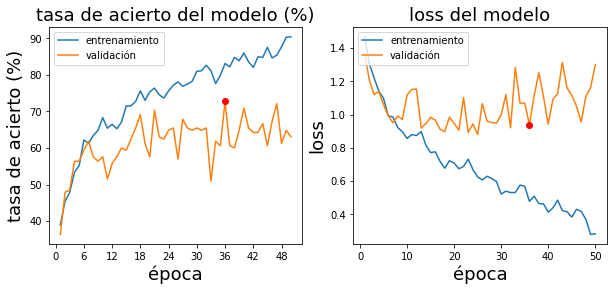

In [40]:
filepath='definitiva.h5'
checkpoint   = [EarlyStopping(monitor='val_loss', patience=30, mode='min', min_delta=0.0001),
                ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True, mode='min')]

acum_tr_acc = []
acum_val_acc = []
best_val_acc = -1000
acum_tr_loss  = []
acum_val_loss = []

epochs=50
batch_size=64


for e in range(epochs):
    history = model.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=1,
                        callbacks=checkpoint,
                        verbose=1,
                        validation_data=(X_test, y_test))

    if history.history['val_accuracy'][-1] > best_val_acc:
        print("Validation accuracy improved from",
              best_val_acc, 'to', history.history['val_accuracy'])
        print("saving weights")
        best_val_acc = history.history['val_accuracy'][-1]

    acum_tr_acc.append(history.history['accuracy'][0])
    acum_val_acc.append(history.history['val_accuracy'][0])
    acum_tr_loss.append(history.history['loss'][0])
    acum_val_loss.append(history.history['val_loss'][0])

    if len(acum_tr_acc) > 1:
        clear_output()
        best_i = np.argmax(acum_val_acc)
        grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

In [41]:
def datos(file):    
    
    data = mne.io.read_raw_edf(f'/media/usbdisk/data/ProyectoPSG/data/{file}.edf')
    raw_data = data.get_data()
    sampling_rate = data.info['sfreq']
    events, events_id = mne.events_from_annotations(data, regexp='Sleep stage [A-Z]\d*')
    tmax = 30. - 1. / sampling_rate  # tmax is included
    channels = ["C3", "C4", "O1", "O2", "A1", "A2", "LOC", "ROC", "LAT1", "LAT2", "RAT1", "RAT2", "CHIN1", "CHIN2"]
    epochs = mne.Epochs(raw=data, 
                        events=events,
                        event_id=events_id,
                        tmin=0., 
                        tmax=tmax, 
                        baseline=None, 
                        event_repeated='merge',
                        picks=channels)

    epochs.drop_bad()
    epochs.set_channel_types({
        "LAT1":"eog",
        "LAT2":"eog",
        "RAT1":"eog",
        "RAT2":"eog",
        "CHIN1":"emg",
        "CHIN2":"emg"
    })
    epochs.load_data()
    montage = mne.channels.make_standard_montage('standard_alphabetic')
    channels_not_in_montage = [ch for ch in epochs.ch_names if ch not in montage.ch_names]
    epochs.drop_channels(channels_not_in_montage)
    epochs.set_montage(montage)
    picks = mne.pick_types(epochs.info, meg=False, eeg=True, stim=False,
                           eog=False, exclude='bads')
    ar = AutoReject(picks=picks, random_state=42, n_jobs=-1, verbose='tqdm')
    epochs_ar, reject_log = ar.fit_transform(epochs, return_log=True)
    patatuela=epochs_ar.filter(l_freq=0.3,h_freq=35)
    id_to_class_dict = {value:key for key, value in patatuela.event_id.items()}

    objective_stages = ['Sleep stage N1','Sleep stage N2','Sleep stage N3','Sleep stage R','Sleep stage W']
    epochs_to_df = [a for a in patatuela]
    epochs_to_df = []
    label_to_df = []
    for epoch, label in zip(patatuela, patatuela.events[:,-1]):
        # print(label)
        label = id_to_class_dict[label]
        if label in objective_stages:
            # print("True")
            epochs_to_df.append(epoch)
            label_to_df.append(label)
    dict_to_df = {"Epoch":epochs_to_df,"Label":label_to_df}
    df1=pd.DataFrame(dict_to_df)
    valores=df1.Epoch.values
    channels = epochs_ar.ch_names
    diccionarios=[dict(zip(channels, sublist)) for sublist in valores]
    c3=[d['C3'] for d in diccionarios]
    c4=[d['C4'] for d in diccionarios]
    a1=[d['A1'] for d in diccionarios]
    a2=[d['A2'] for d in diccionarios]
    o1=[d['O1'] for d in diccionarios]
    o2=[d['O2'] for d in diccionarios]
    dif=(np.array(c3)-np.array(a2))
    dif2=(np.array(c4)-np.array(a1))
    dif3=(np.array(o1)-np.array(a2))
    dif4=(np.array(o2)-np.array(a1))
    X_psg=np.transpose(np.array([dif,dif2,dif3,dif4]),axes=(1,2,0))
    y_psg=df1.Label

    save(f'datos_{file}.npy', X_psg)
    y_psg.to_csv(f'Etiquetas_{file}.csv',index=None)

    return X_psg,y_psg

In [53]:
save('datos_PSG1.npy', X_psg1)
y_psg1.to_csv('Etiquetas_PSG1.csv',index=None)

In [45]:
pss=[f'PSG{i}' for i in range(2,16)]

In [48]:
for p in pss:
    datos(p)

Extracting EDF parameters from /media/usbdisk/data/ProyectoPSG/data/PSG2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-41-057a0828b702>:3: RuntimeWarning: Omitted 6 annotation(s) that were outside data range.
  data = mne.io.read_raw_edf(f'/media/usbdisk/data/ProyectoPSG/data/{file}.edf')
<ipython-input-41-057a0828b702>:3: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  data = mne.io.read_raw_edf(f'/media/usbdisk/data/ProyectoPSG/data/{file}.edf')


Used Annotations descriptions: ['Sleep stage N1', 'Sleep stage N2', 'Sleep stage N3', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
841 matching events found
No baseline correction applied
0 projection items activated
Loading data for 841 events and 15360 original time points ...
1 bad epochs dropped
Loading data for 840 events and 15360 original time points ...
Running autoreject on ch_type=eeg


Computing thresholds ...: 100%|██████████| 6/6 [00:00<00:00, 2467.48it/s]


Repairing epochs:   0%|          | 0/840 [00:00<?, ?it/s]

Repairing epochs:  11%|█         | 90/840 [00:00<00:00, 897.45it/s]

Repairing epochs:  21%|██▏       | 180/840 [00:00<00:00, 875.14it/s]

Repairing epochs:  32%|███▏      | 268/840 [00:00<00:00, 875.68it/s]

Repairing epochs:  42%|████▏     | 356/840 [00:00<00:00, 864.79it/s]

Repairing epochs:  53%|█████▎    | 443/840 [00:00<00:00, 865.72it/s]

Repairing epochs:  63%|██████▎   | 532/840 [00:00<00:00, 872.09it/s]

Repairing epochs:  74%|███████▍  | 620/840 [00:00<00:00, 873.64it/s]

Repairing epochs:  84%|████████▍ | 708/840 [00:00<00:00, 871.66it/s]

Repairing epochs: 100%|██████████| 840/840 [00:00<00:00, 872.55it/s]

n_interp:   0%|          | 0/3 [00:00<?, ?it/s]

Repairing epochs:   0%|          | 0/840 [00:00<?, ?it/s]

Repairing epochs:   2%|▏         | 20/840 [00:00<00:04, 199.60it/s]

Repairing epochs:   5%|▍         | 40/840 [00:00<00:05, 157

Repairing epochs:  70%|██████▉   | 587/840 [00:12<00:05, 49.81it/s]

Repairing epochs:  71%|███████   | 593/840 [00:12<00:05, 45.70it/s]

Repairing epochs:  71%|███████   | 598/840 [00:12<00:05, 43.13it/s]

Repairing epochs:  72%|███████▏  | 603/840 [00:13<00:05, 39.56it/s]

Repairing epochs:  72%|███████▏  | 608/840 [00:13<00:06, 37.62it/s]

Repairing epochs:  73%|███████▎  | 612/840 [00:13<00:06, 37.14it/s]

Repairing epochs:  73%|███████▎  | 616/840 [00:13<00:05, 37.43it/s]

Repairing epochs:  74%|███████▍  | 620/840 [00:13<00:05, 38.03it/s]

Repairing epochs:  74%|███████▍  | 624/840 [00:13<00:05, 37.61it/s]

Repairing epochs:  75%|███████▌  | 633/840 [00:13<00:04, 49.11it/s]

Repairing epochs:  76%|███████▌  | 638/840 [00:13<00:04, 47.36it/s]

Repairing epochs:  77%|███████▋  | 643/840 [00:13<00:04, 45.17it/s]

Repairing epochs:  77%|███████▋  | 648/840 [00:14<00:04, 44.98it/s]

Repairing epochs:  78%|███████▊  | 654/840 [00:14<00:04, 46.08it/s]

Repairing epochs:  78%|███████▊  |

Repairing epochs:  33%|███▎      | 274/840 [00:06<00:16, 34.95it/s]

Repairing epochs:  33%|███▎      | 278/840 [00:06<00:18, 30.78it/s]

Repairing epochs:  34%|███▍      | 284/840 [00:06<00:14, 37.35it/s]

Repairing epochs:  35%|███▌      | 296/840 [00:07<00:09, 54.86it/s]

Repairing epochs:  36%|███▌      | 304/840 [00:07<00:09, 57.95it/s]

Repairing epochs:  37%|███▋      | 311/840 [00:07<00:09, 54.99it/s]

Repairing epochs:  38%|███▊      | 317/840 [00:07<00:10, 50.54it/s]

Repairing epochs:  38%|███▊      | 323/840 [00:07<00:09, 52.13it/s]

Repairing epochs:  40%|███▉      | 332/840 [00:07<00:08, 59.06it/s]

Repairing epochs:  40%|████      | 339/840 [00:07<00:09, 54.55it/s]

Repairing epochs:  41%|████      | 345/840 [00:08<00:10, 49.25it/s]

Repairing epochs:  42%|████▏     | 352/840 [00:08<00:09, 52.17it/s]

Repairing epochs:  43%|████▎     | 358/840 [00:08<00:09, 53.51it/s]

Repairing epochs:  43%|████▎     | 364/840 [00:08<00:09, 49.67it/s]

Repairing epochs:  44%|████▍     |

Repairing epochs:   0%|          | 0/840 [00:00<?, ?it/s]

Repairing epochs:   2%|▏         | 16/840 [00:00<00:06, 137.05it/s]/home/pabloro/anaconda3/envs/tensorflow/lib/python3.8/site-packages/mne/bem.py:974: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/home/pabloro/anaconda3/envs/tensorflow/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/pabloro/anaconda3/envs/tensorflow/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pabloro/anaconda3/envs/tensorflow/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Repairing epochs:   4%|▎         | 30/840 [00:00<00:06, 120.80it/s]

Repairing epochs:   5%|▌         | 43/840 [00:00<00:06, 114.48it/s]

Repairing epochs:   7%|▋  

Repairing epochs:  71%|███████   | 598/840 [00:13<00:04, 50.85it/s]

Repairing epochs:  72%|███████▏  | 604/840 [00:13<00:04, 48.44it/s]

Repairing epochs:  73%|███████▎  | 610/840 [00:14<00:04, 46.69it/s]

Repairing epochs:  73%|███████▎  | 615/840 [00:14<00:04, 45.57it/s]

Repairing epochs:  74%|███████▍  | 620/840 [00:14<00:05, 43.23it/s]

Repairing epochs:  75%|███████▍  | 627/840 [00:14<00:04, 48.34it/s]

Repairing epochs:  76%|███████▌  | 635/840 [00:14<00:03, 55.29it/s]

Repairing epochs:  76%|███████▋  | 641/840 [00:14<00:04, 45.13it/s]

Repairing epochs:  77%|███████▋  | 646/840 [00:14<00:04, 45.60it/s]

Repairing epochs:  78%|███████▊  | 653/840 [00:14<00:03, 49.86it/s]

Repairing epochs:  78%|███████▊  | 659/840 [00:15<00:03, 45.84it/s]

Repairing epochs:  79%|███████▉  | 664/840 [00:15<00:03, 45.20it/s]

Repairing epochs:  80%|███████▉  | 669/840 [00:15<00:03, 43.07it/s]

Repairing epochs:  80%|████████  | 674/840 [00:15<00:03, 42.16it/s]

Repairing epochs:  81%|████████  |





Estimated consensus=0.70 and n_interpolate=4




Repairing epochs:   0%|          | 0/840 [00:00<?, ?it/s]

Repairing epochs:   2%|▏         | 16/840 [00:00<00:06, 133.92it/s]

Repairing epochs:   4%|▎         | 30/840 [00:00<00:07, 114.29it/s]

Repairing epochs:   5%|▌         | 42/840 [00:00<00:07, 103.20it/s]

Repairing epochs:   6%|▋         | 53/840 [00:00<00:08, 91.59it/s] 

Repairing epochs:   8%|▊         | 63/840 [00:00<00:11, 68.93it/s]

Repairing epochs:   8%|▊         | 71/840 [00:00<00:12, 59.44it/s]

Repairing epochs:   9%|▉         | 78/840 [00:01<00:14, 54.31it/s]

Repairing epochs:  10%|█         | 84/840 [00:01<00:15, 50.38it/s]

Repairing epochs:  11%|█         | 90/840 [00:01<00:16, 45.13it/s]

Repairing epochs:  11%|█▏        | 95/840 [00:01<00:21, 34.44it/s]

Repairing epochs:  12%|█▏        | 99/840 [00:01<00:21, 33.92it/s]

Repairing epochs:  12%|█▏        | 103/840 [00:02<00:26, 27.63it/s]

Repairing epochs:  13%|█▎        | 109/840 [00:02<00:24, 30.19it/s]

Repairing epochs:  13%|█▎        | 113/840 [00:02

Repairing epochs:  78%|███████▊  | 655/840 [00:15<00:03, 53.51it/s]

Repairing epochs:  79%|███████▊  | 661/840 [00:15<00:03, 52.09it/s]

Repairing epochs:  79%|███████▉  | 667/840 [00:15<00:03, 47.67it/s]

Repairing epochs:  80%|████████  | 672/840 [00:15<00:03, 45.08it/s]

Repairing epochs:  81%|████████  | 677/840 [00:15<00:03, 43.50it/s]

Repairing epochs:  81%|████████  | 682/840 [00:15<00:03, 42.30it/s]

Repairing epochs:  82%|████████▏ | 687/840 [00:15<00:03, 41.63it/s]

Repairing epochs:  82%|████████▏ | 692/840 [00:15<00:03, 40.87it/s]

Repairing epochs:  83%|████████▎ | 697/840 [00:16<00:03, 37.02it/s]

Repairing epochs:  83%|████████▎ | 701/840 [00:16<00:03, 36.44it/s]

Repairing epochs:  84%|████████▍ | 705/840 [00:16<00:03, 37.09it/s]

Repairing epochs:  85%|████████▍ | 710/840 [00:16<00:03, 37.65it/s]

Repairing epochs:  85%|████████▌ | 715/840 [00:16<00:03, 40.42it/s]

Repairing epochs:  86%|████████▌ | 720/840 [00:16<00:03, 36.00it/s]

Repairing epochs:  86%|████████▌ |

Dropped 39 epochs: 0, 28, 30, 36, 160, 189, 207, 215, 218, 219, 220, 221, 223, 274, 290, 291, 319, 321, 389, 447, 484, 498, 529, 570, 617, 619, 653, 654, 705, 721, 737, 757, 773, 777, 786, 787, 805, 807, 839
Setting up band-pass filter from 0.3 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 5633 samples (11.002 sec)

Extracting EDF parameters from /media/usbdisk/data/ProyectoPSG/data/PSG3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-41-057a0828b702>:3: RuntimeWarning: Omitted 2 annotation(s) that were outside data range.
  data = mne.io.read_raw_edf(f'/media/usbdisk/data/ProyectoPSG/data/{file}.edf')
<ipython-input-41-057a0828b702>:3: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  data = mne.io.read_raw_edf(f'/media/usbdisk/data/ProyectoPSG/data/{file}.edf')


Used Annotations descriptions: ['Sleep stage N1', 'Sleep stage N2', 'Sleep stage N3', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
854 matching events found
No baseline correction applied
0 projection items activated
Loading data for 854 events and 15360 original time points ...
1 bad epochs dropped
Loading data for 853 events and 15360 original time points ...
Running autoreject on ch_type=eeg


Computing thresholds ...: 100%|██████████| 6/6 [00:00<00:00, 6135.01it/s]


Repairing epochs:   0%|          | 0/853 [00:00<?, ?it/s]

Repairing epochs:  10%|█         | 88/853 [00:00<00:00, 872.42it/s]

Repairing epochs:  21%|██        | 176/853 [00:00<00:00, 847.61it/s]

Repairing epochs:  31%|███       | 261/853 [00:00<00:00, 834.18it/s]

Repairing epochs:  40%|████      | 345/853 [00:00<00:00, 826.58it/s]

Repairing epochs:  50%|█████     | 428/853 [00:00<00:00, 823.90it/s]

Repairing epochs:  60%|██████    | 513/853 [00:00<00:00, 832.43it/s]

Repairing epochs:  70%|██████▉   | 597/853 [00:00<00:00, 828.07it/s]

Repairing epochs:  80%|████████  | 683/853 [00:00<00:00, 837.30it/s]

Repairing epochs: 100%|██████████| 853/853 [00:01<00:00, 835.48it/s]

n_interp:   0%|          | 0/3 [00:00<?, ?it/s]

Repairing epochs:   0%|          | 0/853 [00:00<?, ?it/s]

Repairing epochs:   1%|          | 8/853 [00:00<00:11, 75.05it/s]

Repairing epochs:   2%|▏         | 18/853 [00:00<00:09, 87.88

Fold:  30%|███       | 3/10 [00:33<01:18, 11.18s/it]


Fold:  40%|████      | 4/10 [00:44<01:07, 11.18s/it]


Fold:  50%|█████     | 5/10 [00:55<00:55, 11.20s/it]


Fold:  60%|██████    | 6/10 [01:07<00:44, 11.16s/it]


Fold:  70%|███████   | 7/10 [01:18<00:33, 11.14s/it]


Fold:  80%|████████  | 8/10 [01:29<00:22, 11.11s/it]


Fold:  90%|█████████ | 9/10 [01:40<00:11, 11.14s/it]


Fold: 100%|██████████| 10/10 [01:51<00:00, 11.14s/it]

n_interp:  33%|███▎      | 1/3 [02:04<04:08, 124.31s/it]

Repairing epochs:   0%|          | 0/853 [00:00<?, ?it/s]

Repairing epochs:   2%|▏         | 15/853 [00:00<00:06, 132.19it/s]

Repairing epochs:   4%|▎         | 31/853 [00:00<00:07, 109.11it/s]

Repairing epochs:   5%|▌         | 43/853 [00:00<00:08, 94.51it/s] 

Repairing epochs:   6%|▋         | 55/853 [00:00<00:08, 99.02it/s]

Repairing epochs:   8%|▊         | 66/853 [00:00<00:07, 101.55it/s]

Repairing epochs:   9%|▉         | 77/853 [00:00<00:07, 100.70it/s]

Repairing epochs:  10%|█      

Repairing epochs:  29%|██▊       | 244/853 [00:02<00:07, 84.32it/s]

Repairing epochs:  30%|██▉       | 254/853 [00:02<00:07, 76.49it/s]

Repairing epochs:  31%|███       | 263/853 [00:02<00:07, 75.39it/s]

Repairing epochs:  32%|███▏      | 273/853 [00:03<00:07, 80.92it/s]

Repairing epochs:  33%|███▎      | 282/853 [00:03<00:06, 82.62it/s]

Repairing epochs:  34%|███▍      | 293/853 [00:03<00:06, 87.95it/s]

Repairing epochs:  36%|███▌      | 304/853 [00:03<00:05, 93.20it/s]

Repairing epochs:  37%|███▋      | 314/853 [00:03<00:06, 87.24it/s]

Repairing epochs:  38%|███▊      | 325/853 [00:03<00:05, 92.21it/s]

Repairing epochs:  39%|███▉      | 335/853 [00:03<00:06, 83.95it/s]

Repairing epochs:  41%|████      | 346/853 [00:03<00:05, 90.35it/s]

Repairing epochs:  43%|████▎     | 371/853 [00:03<00:03, 132.17it/s]

Repairing epochs:  45%|████▌     | 385/853 [00:04<00:03, 119.19it/s]

Repairing epochs:  47%|████▋     | 399/853 [00:04<00:03, 123.84it/s]

Repairing epochs:  48%|████▊   





Estimated consensus=0.20 and n_interpolate=1




Repairing epochs:   0%|          | 0/853 [00:00<?, ?it/s]

Repairing epochs:   1%|          | 7/853 [00:00<00:13, 60.45it/s]

Repairing epochs:   2%|▏         | 14/853 [00:00<00:13, 62.33it/s]

Repairing epochs:   2%|▏         | 21/853 [00:00<00:12, 65.08it/s]

Repairing epochs:   4%|▍         | 33/853 [00:00<00:10, 79.71it/s]

Repairing epochs:   5%|▍         | 41/853 [00:00<00:11, 67.96it/s]

Repairing epochs:   6%|▌         | 48/853 [00:00<00:13, 60.14it/s]

Repairing epochs:   6%|▋         | 55/853 [00:00<00:13, 59.54it/s]

Repairing epochs:   7%|▋         | 62/853 [00:00<00:13, 58.36it/s]

Repairing epochs:   8%|▊         | 68/853 [00:01<00:13, 57.15it/s]

Repairing epochs:   9%|▊         | 74/853 [00:01<00:13, 55.78it/s]

Repairing epochs:   9%|▉         | 80/853 [00:01<00:14, 53.00it/s]

Repairing epochs:  10%|█         | 86/853 [00:01<00:14, 52.04it/s]

Repairing epochs:  11%|█         | 92/853 [00:01<00:14, 51.54it/s]

Repairing epochs:  11%|█▏        | 98/853 [00:01<00:14, 

Dropped 474 epochs: 0, 1, 2, 3, 4, 5, 6, 7, 14, 15, 17, 27, 29, 30, 32, 33, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 113, 114, 116, 119, 120, 121, 122, 123, 125, 126, 127, 129, 131, 133, 134, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 163, 164, 165, 166, 167, 168, 170, 171, 173, 174, 175, 176, 181, 182, 183, 185, 186, 187, 188, 192, 193, 195, 197, 199, 200, 201, 202, 205, 206, 207, 209, 210, 211, 212, 214, 215, 216, 218, 219, 221, 222, 223, 226, 227, 228, 229, 230, 231, 232, 234, 235, 237, 240, 241, 244, 245, 246, 249, 251, 252, 254, 256, 259, 260, 261, 262, 263, 264, 268, 272, 275, 277, 278, 280, 286, 287, 289, 292, 294, 296, 299, 304, 306, 307, 

<ipython-input-41-057a0828b702>:3: RuntimeWarning: Omitted 39 annotation(s) that were outside data range.
  data = mne.io.read_raw_edf(f'/media/usbdisk/data/ProyectoPSG/data/{file}.edf')
<ipython-input-41-057a0828b702>:3: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  data = mne.io.read_raw_edf(f'/media/usbdisk/data/ProyectoPSG/data/{file}.edf')


Used Annotations descriptions: ['Sleep stage N1', 'Sleep stage N2', 'Sleep stage N3', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
763 matching events found
No baseline correction applied
0 projection items activated
Loading data for 763 events and 15360 original time points ...
1 bad epochs dropped
Loading data for 762 events and 15360 original time points ...
Running autoreject on ch_type=eeg


Computing thresholds ...: 100%|██████████| 6/6 [00:00<00:00, 4053.12it/s]


Repairing epochs:   0%|          | 0/762 [00:00<?, ?it/s]

Repairing epochs:  12%|█▏        | 89/762 [00:00<00:00, 885.58it/s]

Repairing epochs:  23%|██▎       | 179/762 [00:00<00:00, 891.21it/s]

Repairing epochs:  35%|███▌      | 269/762 [00:00<00:00, 893.97it/s]

Repairing epochs:  47%|████▋     | 359/762 [00:00<00:00, 893.97it/s]

Repairing epochs:  59%|█████▉    | 449/762 [00:00<00:00, 890.30it/s]

Repairing epochs:  71%|███████   | 539/762 [00:00<00:00, 890.09it/s]

Repairing epochs:  83%|████████▎ | 629/762 [00:00<00:00, 888.32it/s]

Repairing epochs: 100%|██████████| 762/762 [00:00<00:00, 884.98it/s]

n_interp:   0%|          | 0/3 [00:00<?, ?it/s]

Repairing epochs:   0%|          | 0/762 [00:00<?, ?it/s]

Repairing epochs:   2%|▏         | 13/762 [00:00<00:05, 128.38it/s]

Repairing epochs:   3%|▎         | 26/762 [00:00<00:06, 110.71it/s]

Repairing epochs:   5%|▍         | 38/762 [00:00<00:08, 81.9

Fold:  60%|██████    | 6/10 [00:55<00:37,  9.31s/it]


Fold:  70%|███████   | 7/10 [01:04<00:27,  9.23s/it]


Fold:  80%|████████  | 8/10 [01:14<00:18,  9.22s/it]


Fold:  90%|█████████ | 9/10 [01:23<00:09,  9.19s/it]


Fold: 100%|██████████| 10/10 [01:32<00:00,  9.25s/it]

n_interp:  33%|███▎      | 1/3 [01:45<03:30, 105.04s/it]

Repairing epochs:   0%|          | 0/762 [00:00<?, ?it/s]

Repairing epochs:   1%|          | 8/762 [00:00<00:10, 74.22it/s]

Repairing epochs:   2%|▏         | 18/762 [00:00<00:08, 88.61it/s]

Repairing epochs:   4%|▎         | 27/762 [00:00<00:12, 60.11it/s]

Repairing epochs:   4%|▍         | 34/762 [00:00<00:11, 62.62it/s]

Repairing epochs:   5%|▌         | 41/762 [00:00<00:11, 63.28it/s]

Repairing epochs:   6%|▋         | 48/762 [00:00<00:11, 63.08it/s]

Repairing epochs:   7%|▋         | 55/762 [00:00<00:11, 61.03it/s]

Repairing epochs:   8%|▊         | 64/762 [00:00<00:10, 68.74it/s]

Repairing epochs:  12%|█▏        | 89/762 [00:01<00:05, 119.67it/

Repairing epochs:  62%|██████▏   | 474/762 [00:04<00:02, 137.75it/s]

Repairing epochs:  65%|██████▌   | 498/762 [00:04<00:01, 164.48it/s]

Repairing epochs:  68%|██████▊   | 517/762 [00:04<00:01, 163.17it/s]

Repairing epochs:  70%|███████   | 534/762 [00:04<00:01, 150.31it/s]

Repairing epochs:  72%|███████▏  | 550/762 [00:04<00:01, 123.21it/s]

Repairing epochs:  74%|███████▍  | 564/762 [00:04<00:02, 98.86it/s] 

Repairing epochs:  76%|███████▌  | 576/762 [00:05<00:02, 92.31it/s]

Repairing epochs:  77%|███████▋  | 587/762 [00:05<00:02, 76.78it/s]

Repairing epochs:  78%|███████▊  | 596/762 [00:05<00:02, 68.98it/s]

Repairing epochs:  79%|███████▉  | 604/762 [00:05<00:02, 65.28it/s]

Repairing epochs:  82%|████████▏ | 627/762 [00:05<00:01, 94.27it/s]

Repairing epochs:  84%|████████▎ | 638/762 [00:05<00:01, 94.35it/s]

Repairing epochs:  86%|████████▌ | 654/762 [00:05<00:00, 109.25it/s]

Repairing epochs:  88%|████████▊ | 670/762 [00:06<00:00, 118.46it/s]

Repairing epochs:  90%|███





Estimated consensus=0.20 and n_interpolate=1




Repairing epochs:   0%|          | 0/762 [00:00<?, ?it/s]

Repairing epochs:   1%|▏         | 10/762 [00:00<00:07, 97.25it/s]

Repairing epochs:   3%|▎         | 20/762 [00:00<00:08, 83.31it/s]

Repairing epochs:   4%|▍         | 29/762 [00:00<00:10, 72.11it/s]

Repairing epochs:   5%|▍         | 37/762 [00:00<00:11, 65.61it/s]

Repairing epochs:   6%|▌         | 44/762 [00:00<00:11, 63.85it/s]

Repairing epochs:   7%|▋         | 51/762 [00:00<00:11, 60.45it/s]

Repairing epochs:   8%|▊         | 58/762 [00:00<00:11, 59.32it/s]

Repairing epochs:   8%|▊         | 64/762 [00:01<00:12, 57.92it/s]

Repairing epochs:   9%|▉         | 70/762 [00:01<00:12, 57.28it/s]

Repairing epochs:  10%|▉         | 76/762 [00:01<00:12, 56.58it/s]

Repairing epochs:  11%|█         | 82/762 [00:01<00:12, 56.61it/s]

Repairing epochs:  12%|█▏        | 90/762 [00:01<00:11, 61.02it/s]

Repairing epochs:  13%|█▎        | 97/762 [00:01<00:11, 56.55it/s]

Repairing epochs:  14%|█▎        | 103/762 [00:01<00:11

Dropped 527 epochs: 0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 44, 45, 46, 47, 48, 49, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 86, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 99, 100, 101, 102, 103, 104, 107, 112, 114, 115, 117, 119, 120, 124, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245,

<ipython-input-41-057a0828b702>:3: RuntimeWarning: Omitted 143 annotation(s) that were outside data range.
  data = mne.io.read_raw_edf(f'/media/usbdisk/data/ProyectoPSG/data/{file}.edf')
<ipython-input-41-057a0828b702>:3: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  data = mne.io.read_raw_edf(f'/media/usbdisk/data/ProyectoPSG/data/{file}.edf')


Used Annotations descriptions: ['Sleep stage N1', 'Sleep stage N2', 'Sleep stage N3', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
739 matching events found
No baseline correction applied
0 projection items activated
Loading data for 739 events and 15360 original time points ...
1 bad epochs dropped
Loading data for 738 events and 15360 original time points ...
Running autoreject on ch_type=eeg


Computing thresholds ...: 100%|██████████| 6/6 [00:00<00:00, 4680.27it/s]


Repairing epochs:   0%|          | 0/738 [00:00<?, ?it/s]

Repairing epochs:  12%|█▏        | 92/738 [00:00<00:00, 918.67it/s]

Repairing epochs:  25%|██▍       | 184/738 [00:00<00:00, 911.48it/s]

Repairing epochs:  37%|███▋      | 276/738 [00:00<00:00, 894.69it/s]

Repairing epochs:  50%|████▉     | 366/738 [00:00<00:00, 893.62it/s]

Repairing epochs:  62%|██████▏   | 457/738 [00:00<00:00, 897.66it/s]

Repairing epochs:  74%|███████▍  | 548/738 [00:00<00:00, 898.77it/s]

Repairing epochs:  86%|████████▋ | 638/738 [00:00<00:00, 897.84it/s]

Repairing epochs: 100%|██████████| 738/738 [00:00<00:00, 895.32it/s]

n_interp:   0%|          | 0/3 [00:00<?, ?it/s]

Repairing epochs:   0%|          | 0/738 [00:00<?, ?it/s]

Repairing epochs:   1%|          | 7/738 [00:00<00:11, 66.19it/s]

Repairing epochs:   2%|▏         | 14/738 [00:00<00:11, 60.73it/s]

Repairing epochs:   3%|▎         | 21/738 [00:00<00:13, 51.95it

Repairing epochs:  79%|███████▉  | 582/738 [00:11<00:02, 57.58it/s]

Repairing epochs:  80%|███████▉  | 589/738 [00:11<00:02, 59.68it/s]

Repairing epochs:  81%|████████  | 596/738 [00:12<00:02, 59.47it/s]

Repairing epochs:  82%|████████▏ | 603/738 [00:12<00:02, 54.54it/s]

Repairing epochs:  83%|████████▎ | 612/738 [00:12<00:02, 59.29it/s]

Repairing epochs:  84%|████████▍ | 619/738 [00:12<00:02, 53.39it/s]

Repairing epochs:  85%|████████▌ | 630/738 [00:12<00:01, 63.47it/s]

Repairing epochs:  87%|████████▋ | 639/738 [00:12<00:01, 69.71it/s]

Repairing epochs:  88%|████████▊ | 647/738 [00:12<00:01, 69.31it/s]

Repairing epochs:  89%|████████▉ | 655/738 [00:12<00:01, 71.16it/s]

Repairing epochs:  90%|████████▉ | 663/738 [00:13<00:01, 70.03it/s]

Repairing epochs:  91%|█████████ | 671/738 [00:13<00:00, 71.16it/s]

Repairing epochs:  92%|█████████▏| 679/738 [00:13<00:00, 68.99it/s]

Repairing epochs:  93%|█████████▎| 686/738 [00:13<00:00, 66.03it/s]

Repairing epochs:  94%|█████████▍|

Repairing epochs:  67%|██████▋   | 492/738 [00:10<00:03, 74.26it/s]

Repairing epochs:  68%|██████▊   | 500/738 [00:10<00:03, 69.26it/s]

Repairing epochs:  69%|██████▉   | 508/738 [00:10<00:03, 64.59it/s]

Repairing epochs:  70%|██████▉   | 515/738 [00:10<00:03, 60.75it/s]

Repairing epochs:  71%|███████   | 522/738 [00:10<00:04, 53.35it/s]

Repairing epochs:  72%|███████▏  | 528/738 [00:10<00:04, 51.91it/s]

Repairing epochs:  72%|███████▏  | 534/738 [00:11<00:04, 43.03it/s]

Repairing epochs:  73%|███████▎  | 539/738 [00:11<00:04, 43.32it/s]

Repairing epochs:  74%|███████▍  | 546/738 [00:11<00:03, 48.18it/s]

Repairing epochs:  75%|███████▍  | 552/738 [00:11<00:03, 47.34it/s]

Repairing epochs:  75%|███████▌  | 557/738 [00:11<00:04, 42.06it/s]

Repairing epochs:  76%|███████▌  | 562/738 [00:11<00:04, 41.94it/s]

Repairing epochs:  77%|███████▋  | 570/738 [00:11<00:03, 46.95it/s]

Repairing epochs:  78%|███████▊  | 579/738 [00:12<00:03, 52.48it/s]

Repairing epochs:  80%|███████▉  |

Repairing epochs:  60%|██████    | 443/738 [00:08<00:04, 63.45it/s]

Repairing epochs:  61%|██████    | 450/738 [00:08<00:04, 63.89it/s]

Repairing epochs:  62%|██████▏   | 457/738 [00:09<00:04, 60.83it/s]

Repairing epochs:  63%|██████▎   | 464/738 [00:09<00:04, 59.80it/s]

Repairing epochs:  64%|██████▍   | 471/738 [00:09<00:04, 59.44it/s]

Repairing epochs:  65%|██████▍   | 479/738 [00:09<00:04, 63.14it/s]

Repairing epochs:  66%|██████▌   | 488/738 [00:09<00:03, 69.30it/s]

Repairing epochs:  67%|██████▋   | 496/738 [00:09<00:03, 71.94it/s]

Repairing epochs:  68%|██████▊   | 504/738 [00:09<00:03, 66.76it/s]

Repairing epochs:  69%|██████▉   | 511/738 [00:09<00:03, 59.63it/s]

Repairing epochs:  70%|███████   | 518/738 [00:10<00:03, 55.73it/s]

Repairing epochs:  71%|███████   | 524/738 [00:10<00:04, 49.99it/s]

Repairing epochs:  72%|███████▏  | 530/738 [00:10<00:04, 42.56it/s]

Repairing epochs:  72%|███████▏  | 535/738 [00:10<00:04, 43.19it/s]

Repairing epochs:  73%|███████▎  |





Estimated consensus=0.70 and n_interpolate=4




Repairing epochs:   0%|          | 0/738 [00:00<?, ?it/s]

Repairing epochs:   1%|          | 9/738 [00:00<00:08, 86.24it/s]

Repairing epochs:   2%|▏         | 18/738 [00:00<00:12, 56.69it/s]

Repairing epochs:   3%|▎         | 25/738 [00:00<00:12, 55.75it/s]

Repairing epochs:   4%|▍         | 33/738 [00:00<00:11, 62.68it/s]

Repairing epochs:   5%|▌         | 40/738 [00:00<00:11, 63.26it/s]

Repairing epochs:   7%|▋         | 51/738 [00:00<00:09, 73.17it/s]

Repairing epochs:   8%|▊         | 59/738 [00:01<00:12, 53.03it/s]

Repairing epochs:   9%|▉         | 68/738 [00:01<00:11, 60.12it/s]

Repairing epochs:  10%|█         | 77/738 [00:01<00:10, 62.04it/s]

Repairing epochs:  12%|█▏        | 86/738 [00:01<00:09, 67.43it/s]

Repairing epochs:  13%|█▎        | 94/738 [00:01<00:10, 61.01it/s]

Repairing epochs:  14%|█▎        | 101/738 [00:01<00:11, 57.19it/s]

Repairing epochs:  15%|█▍        | 108/738 [00:01<00:11, 53.08it/s]

Repairing epochs:  15%|█▌        | 114/738 [00:01<00:1

Dropped 6 epochs: 49, 59, 63, 64, 663, 736
Setting up band-pass filter from 0.3 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 5633 samples (11.002 sec)

Extracting EDF parameters from /media/usbdisk/data/ProyectoPSG/data/PSG6.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-41-057a0828b702>:3: RuntimeWarning: Omitted 234 annotation(s) that were outside data range.
  data = mne.io.read_raw_edf(f'/media/usbdisk/data/ProyectoPSG/data/{file}.edf')
<ipython-input-41-057a0828b702>:3: RuntimeWarning: Limited 3 annotation(s) that were expanding outside the data range.
  data = mne.io.read_raw_edf(f'/media/usbdisk/data/ProyectoPSG/data/{file}.edf')


Used Annotations descriptions: ['Sleep stage N1', 'Sleep stage N2', 'Sleep stage N3', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
814 matching events found
No baseline correction applied
0 projection items activated
Loading data for 814 events and 15360 original time points ...
1 bad epochs dropped
Loading data for 813 events and 15360 original time points ...
Running autoreject on ch_type=eeg


Computing thresholds ...: 100%|██████████| 6/6 [00:00<00:00, 5756.14it/s]


Repairing epochs:   0%|          | 0/813 [00:00<?, ?it/s]

Repairing epochs:  11%|█         | 88/813 [00:00<00:00, 877.88it/s]

Repairing epochs:  22%|██▏       | 177/813 [00:00<00:00, 881.36it/s]

Repairing epochs:  33%|███▎      | 266/813 [00:00<00:00, 878.19it/s]

Repairing epochs:  44%|████▎     | 355/813 [00:00<00:00, 881.68it/s]

Repairing epochs:  55%|█████▍    | 445/813 [00:00<00:00, 888.08it/s]

Repairing epochs:  66%|██████▌   | 535/813 [00:00<00:00, 888.36it/s]

Repairing epochs:  77%|███████▋  | 624/813 [00:00<00:00, 888.37it/s]

Repairing epochs:  88%|████████▊ | 714/813 [00:00<00:00, 891.72it/s]

Repairing epochs: 100%|██████████| 813/813 [00:00<00:00, 884.89it/s]

n_interp:   0%|          | 0/3 [00:00<?, ?it/s]

Repairing epochs:   0%|          | 0/813 [00:00<?, ?it/s]

Repairing epochs:   1%|          | 10/813 [00:00<00:08, 95.31it/s]

Repairing epochs:   2%|▏         | 20/813 [00:00<00:10, 79.1

Repairing epochs:  73%|███████▎  | 590/813 [00:11<00:04, 52.58it/s]

Repairing epochs:  73%|███████▎  | 596/813 [00:11<00:04, 52.57it/s]

Repairing epochs:  74%|███████▍  | 602/813 [00:11<00:04, 52.54it/s]

Repairing epochs:  75%|███████▍  | 608/813 [00:11<00:03, 52.51it/s]

Repairing epochs:  76%|███████▌  | 614/813 [00:12<00:03, 52.49it/s]

Repairing epochs:  76%|███████▋  | 620/813 [00:12<00:03, 52.47it/s]

Repairing epochs:  77%|███████▋  | 626/813 [00:12<00:03, 52.53it/s]

Repairing epochs:  78%|███████▊  | 632/813 [00:12<00:03, 53.27it/s]

Repairing epochs:  78%|███████▊  | 638/813 [00:12<00:03, 53.05it/s]

Repairing epochs:  79%|███████▉  | 644/813 [00:12<00:03, 52.88it/s]

Repairing epochs:  80%|███████▉  | 650/813 [00:12<00:03, 52.82it/s]

Repairing epochs:  81%|████████  | 656/813 [00:12<00:02, 52.73it/s]

Repairing epochs:  81%|████████▏ | 662/813 [00:12<00:02, 53.07it/s]

Repairing epochs:  82%|████████▏ | 668/813 [00:13<00:02, 51.81it/s]

Repairing epochs:  83%|████████▎ |

Repairing epochs:  49%|████▊     | 395/813 [00:08<00:07, 53.70it/s]

Repairing epochs:  49%|████▉     | 401/813 [00:08<00:08, 48.03it/s]

Repairing epochs:  50%|█████     | 407/813 [00:08<00:08, 49.08it/s]

Repairing epochs:  51%|█████     | 413/813 [00:08<00:08, 49.52it/s]

Repairing epochs:  52%|█████▏    | 421/813 [00:08<00:06, 56.92it/s]

Repairing epochs:  53%|█████▎    | 427/813 [00:08<00:07, 49.72it/s]

Repairing epochs:  53%|█████▎    | 434/813 [00:08<00:07, 53.35it/s]

Repairing epochs:  54%|█████▍    | 440/813 [00:08<00:07, 52.02it/s]

Repairing epochs:  55%|█████▍    | 446/813 [00:09<00:07, 51.07it/s]

Repairing epochs:  56%|█████▌    | 452/813 [00:09<00:07, 50.96it/s]

Repairing epochs:  56%|█████▋    | 458/813 [00:09<00:06, 52.36it/s]

Repairing epochs:  57%|█████▋    | 464/813 [00:09<00:06, 52.39it/s]

Repairing epochs:  58%|█████▊    | 470/813 [00:09<00:06, 52.38it/s]

Repairing epochs:  59%|█████▊    | 476/813 [00:09<00:06, 52.51it/s]

Repairing epochs:  59%|█████▉    |

Repairing epochs:  12%|█▏        | 99/813 [00:02<00:17, 40.71it/s]

Repairing epochs:  13%|█▎        | 104/813 [00:02<00:21, 33.40it/s]

Repairing epochs:  13%|█▎        | 109/813 [00:02<00:21, 33.34it/s]

Repairing epochs:  14%|█▍        | 113/813 [00:02<00:21, 32.79it/s]

Repairing epochs:  15%|█▍        | 120/813 [00:02<00:16, 41.06it/s]

Repairing epochs:  15%|█▌        | 125/813 [00:03<00:16, 41.58it/s]

Repairing epochs:  16%|█▌        | 130/813 [00:03<00:17, 38.25it/s]

Repairing epochs:  17%|█▋        | 135/813 [00:03<00:19, 35.11it/s]

Repairing epochs:  17%|█▋        | 142/813 [00:03<00:15, 42.94it/s]

Repairing epochs:  18%|█▊        | 147/813 [00:03<00:15, 42.75it/s]

Repairing epochs:  19%|█▊        | 152/813 [00:03<00:16, 40.09it/s]

Repairing epochs:  19%|█▉        | 158/813 [00:03<00:14, 44.29it/s]

Repairing epochs:  20%|██        | 163/813 [00:04<00:14, 45.33it/s]

Repairing epochs:  21%|██        | 168/813 [00:04<00:14, 44.61it/s]

Repairing epochs:  21%|██▏       | 

Repairing epochs:  95%|█████████▌| 773/813 [00:16<00:01, 39.08it/s]

Repairing epochs:  96%|█████████▌| 782/813 [00:16<00:00, 49.46it/s]

Repairing epochs:  97%|█████████▋| 788/813 [00:16<00:00, 50.06it/s]

Repairing epochs:  98%|█████████▊| 794/813 [00:16<00:00, 41.35it/s]

Repairing epochs:  99%|█████████▊| 801/813 [00:16<00:00, 41.84it/s]

Repairing epochs: 100%|██████████| 813/813 [00:17<00:00, 47.81it/s]



Fold:   0%|          | 0/10 [00:00<?, ?it/s]


Fold:  10%|█         | 1/10 [00:02<00:24,  2.67s/it]


Fold:  20%|██        | 2/10 [00:05<00:21,  2.67s/it]


Fold:  30%|███       | 3/10 [00:08<00:18,  2.69s/it]


Fold:  40%|████      | 4/10 [00:10<00:16,  2.68s/it]


Fold:  50%|█████     | 5/10 [00:13<00:13,  2.67s/it]


Fold:  60%|██████    | 6/10 [00:16<00:10,  2.67s/it]


Fold:  70%|███████   | 7/10 [00:18<00:08,  2.67s/it]


Fold:  80%|████████  | 8/10 [00:21<00:05,  2.67s/it]


Fold:  90%|█████████ | 9/10 [00:24<00:02,  2.67s/it]


Fold: 100%|██████████| 10/10 [00:26<00:00,





Estimated consensus=0.90 and n_interpolate=1




Repairing epochs:   0%|          | 0/813 [00:00<?, ?it/s]

Repairing epochs:   1%|          | 5/813 [00:00<00:16, 47.91it/s]

Repairing epochs:   1%|          | 10/813 [00:00<00:17, 45.54it/s]

Repairing epochs:   2%|▏         | 15/813 [00:00<00:18, 42.84it/s]

Repairing epochs:   2%|▏         | 20/813 [00:00<00:19, 41.57it/s]

Repairing epochs:   3%|▎         | 25/813 [00:00<00:18, 41.79it/s]

Repairing epochs:   4%|▎         | 30/813 [00:00<00:18, 41.70it/s]

Repairing epochs:   4%|▍         | 35/813 [00:00<00:18, 41.99it/s]

Repairing epochs:   5%|▍         | 40/813 [00:00<00:18, 42.19it/s]

Repairing epochs:   6%|▌         | 45/813 [00:01<00:18, 42.34it/s]

Repairing epochs:   6%|▌         | 50/813 [00:01<00:17, 42.40it/s]

Repairing epochs:   7%|▋         | 55/813 [00:01<00:17, 42.45it/s]

Repairing epochs:   7%|▋         | 60/813 [00:01<00:17, 42.48it/s]

Repairing epochs:   8%|▊         | 65/813 [00:01<00:17, 42.53it/s]

Repairing epochs:   9%|▊         | 70/813 [00:01<00:17, 

Repairing epochs:  79%|███████▉  | 644/813 [00:12<00:03, 50.60it/s]

Repairing epochs:  80%|███████▉  | 650/813 [00:12<00:03, 50.73it/s]

Repairing epochs:  81%|████████  | 656/813 [00:13<00:03, 50.15it/s]

Repairing epochs:  81%|████████▏ | 662/813 [00:13<00:02, 50.86it/s]

Repairing epochs:  82%|████████▏ | 668/813 [00:13<00:02, 51.39it/s]

Repairing epochs:  83%|████████▎ | 674/813 [00:13<00:02, 51.70it/s]

Repairing epochs:  84%|████████▎ | 680/813 [00:13<00:02, 51.95it/s]

Repairing epochs:  84%|████████▍ | 686/813 [00:13<00:02, 52.14it/s]

Repairing epochs:  85%|████████▌ | 692/813 [00:13<00:02, 52.31it/s]

Repairing epochs:  86%|████████▌ | 698/813 [00:13<00:02, 46.72it/s]

Repairing epochs:  86%|████████▋ | 703/813 [00:13<00:02, 44.52it/s]

Repairing epochs:  87%|████████▋ | 711/813 [00:14<00:01, 52.48it/s]

Repairing epochs:  88%|████████▊ | 717/813 [00:14<00:01, 52.59it/s]

Repairing epochs:  89%|████████▉ | 723/813 [00:14<00:01, 52.86it/s]

Repairing epochs:  90%|████████▉ |

Dropped 45 epochs: 22, 24, 61, 68, 80, 107, 159, 194, 200, 201, 202, 204, 205, 206, 336, 337, 339, 394, 415, 417, 452, 516, 565, 578, 579, 607, 640, 642, 650, 659, 726, 730, 731, 754, 767, 768, 777, 780, 781, 804, 805, 806, 807, 809, 811
Setting up band-pass filter from 0.3 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 5633 samples (11.002 sec)

Extracting EDF parameters from /media/usbdisk/data/ProyectoPSG/data/PSG7.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-41-057a0828b702>:3: RuntimeWarning: Omitted 113 annotation(s) that were outside data range.
  data = mne.io.read_raw_edf(f'/media/usbdisk/data/ProyectoPSG/data/{file}.edf')
<ipython-input-41-057a0828b702>:3: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  data = mne.io.read_raw_edf(f'/media/usbdisk/data/ProyectoPSG/data/{file}.edf')


Used Annotations descriptions: ['Sleep stage N1', 'Sleep stage N2', 'Sleep stage N3', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
761 matching events found
No baseline correction applied
0 projection items activated
Loading data for 761 events and 15360 original time points ...
1 bad epochs dropped
Loading data for 760 events and 15360 original time points ...
Running autoreject on ch_type=eeg


Computing thresholds ...: 100%|██████████| 6/6 [00:00<00:00, 4405.01it/s]


Repairing epochs:   0%|          | 0/760 [00:00<?, ?it/s]

Repairing epochs:  12%|█▏        | 92/760 [00:00<00:00, 914.38it/s]

Repairing epochs:  24%|██▍       | 184/760 [00:00<00:00, 906.46it/s]

Repairing epochs:  36%|███▌      | 275/760 [00:00<00:00, 907.46it/s]

Repairing epochs:  48%|████▊     | 366/760 [00:00<00:00, 900.72it/s]

Repairing epochs:  60%|██████    | 457/760 [00:00<00:00, 899.71it/s]

Repairing epochs:  72%|███████▏  | 548/760 [00:00<00:00, 900.42it/s]

Repairing epochs:  84%|████████▍ | 639/760 [00:00<00:00, 898.70it/s]

Repairing epochs: 100%|██████████| 760/760 [00:00<00:00, 898.44it/s]

n_interp:   0%|          | 0/3 [00:00<?, ?it/s]

Repairing epochs:   0%|          | 0/760 [00:00<?, ?it/s]

Repairing epochs:   4%|▍         | 32/760 [00:00<00:02, 302.72it/s]

Repairing epochs:   8%|▊         | 63/760 [00:00<00:02, 234.25it/s]

Repairing epochs:  12%|█▏        | 88/760 [00:00<00:03, 194.

Repairing epochs:  97%|█████████▋| 739/760 [00:12<00:00, 64.45it/s]

Repairing epochs:  98%|█████████▊| 746/760 [00:12<00:00, 58.63it/s]

Repairing epochs:  99%|█████████▉| 753/760 [00:13<00:00, 55.34it/s]

Repairing epochs: 100%|██████████| 760/760 [00:13<00:00, 57.74it/s]



Fold:   0%|          | 0/10 [00:00<?, ?it/s]


Fold:  10%|█         | 1/10 [00:09<01:23,  9.22s/it]


Fold:  20%|██        | 2/10 [00:18<01:14,  9.27s/it]


Fold:  30%|███       | 3/10 [00:27<01:05,  9.33s/it]


Fold:  40%|████      | 4/10 [00:37<00:56,  9.40s/it]


Fold:  50%|█████     | 5/10 [00:47<00:47,  9.51s/it]


Fold:  60%|██████    | 6/10 [00:56<00:38,  9.50s/it]


Fold:  70%|███████   | 7/10 [01:05<00:28,  9.44s/it]


Fold:  80%|████████  | 8/10 [01:15<00:18,  9.49s/it]


Fold:  90%|█████████ | 9/10 [01:25<00:09,  9.55s/it]


Fold: 100%|██████████| 10/10 [01:34<00:00,  9.48s/it]

n_interp:  33%|███▎      | 1/3 [01:48<03:37, 108.98s/it]

Repairing epochs:   0%|          | 0/760 [00:00<?, ?it/s]

Repairin

Repairing epochs:  45%|████▍     | 341/760 [00:03<00:05, 75.85it/s] 

Repairing epochs:  46%|████▌     | 351/760 [00:03<00:07, 55.39it/s]

Repairing epochs:  47%|████▋     | 359/760 [00:03<00:07, 55.84it/s]

Repairing epochs:  48%|████▊     | 368/760 [00:03<00:06, 60.11it/s]

Repairing epochs:  49%|████▉     | 376/760 [00:03<00:06, 54.87it/s]

Repairing epochs:  51%|█████▏    | 391/760 [00:04<00:05, 71.97it/s]

Repairing epochs:  53%|█████▎    | 400/760 [00:04<00:07, 50.10it/s]

Repairing epochs:  54%|█████▎    | 407/760 [00:04<00:06, 52.30it/s]

Repairing epochs:  55%|█████▍    | 416/760 [00:04<00:05, 59.22it/s]

Repairing epochs:  56%|█████▌    | 427/760 [00:04<00:04, 68.75it/s]

Repairing epochs:  58%|█████▊    | 438/760 [00:04<00:04, 76.55it/s]

Repairing epochs:  60%|██████    | 458/760 [00:04<00:02, 106.13it/s]

Repairing epochs:  62%|██████▏   | 472/760 [00:05<00:02, 114.42it/s]

Repairing epochs:  66%|██████▌   | 500/760 [00:05<00:01, 158.60it/s]

Repairing epochs:  68%|██████▊





Estimated consensus=0.40 and n_interpolate=1




Repairing epochs:   0%|          | 0/760 [00:00<?, ?it/s]

Repairing epochs:   2%|▏         | 18/760 [00:00<00:04, 167.03it/s]

Repairing epochs:   5%|▍         | 35/760 [00:00<00:05, 121.07it/s]

Repairing epochs:   7%|▋         | 52/760 [00:00<00:05, 138.86it/s]

Repairing epochs:   9%|▉         | 67/760 [00:00<00:04, 142.41it/s]

Repairing epochs:  11%|█         | 84/760 [00:00<00:04, 149.45it/s]

Repairing epochs:  13%|█▎        | 100/760 [00:00<00:04, 139.44it/s]

Repairing epochs:  15%|█▌        | 117/760 [00:00<00:04, 141.60it/s]

Repairing epochs:  18%|█▊        | 133/760 [00:00<00:04, 139.62it/s]

Repairing epochs:  19%|█▉        | 148/760 [00:01<00:05, 110.57it/s]

Repairing epochs:  21%|██        | 161/760 [00:01<00:05, 101.50it/s]

Repairing epochs:  23%|██▎       | 175/760 [00:01<00:05, 107.98it/s]

Repairing epochs:  25%|██▍       | 187/760 [00:01<00:06, 91.66it/s] 

Repairing epochs:  26%|██▌       | 197/760 [00:01<00:07, 74.38it/s]

Repairing epochs:  27%|██▋       | 

Repairing epochs:  98%|█████████▊| 744/760 [00:14<00:00, 55.78it/s]

Repairing epochs:  99%|█████████▉| 751/760 [00:14<00:00, 49.79it/s]

Repairing epochs: 100%|██████████| 760/760 [00:14<00:00, 52.03it/s]


Dropped 400 epochs: 1, 16, 18, 45, 48, 54, 62, 63, 78, 83, 88, 94, 108, 122, 123, 132, 141, 151, 162, 178, 183, 185, 188, 189, 190, 191, 199, 200, 202, 205, 206, 207, 209, 211, 212, 214, 216, 217, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 235, 236, 237, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 255, 257, 258, 260, 261, 262, 263, 264, 265, 266, 267, 269, 271, 273, 274, 284, 285, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 310, 311, 312, 313, 314, 316, 317, 318, 319, 320, 321, 322, 324, 326, 327, 329, 331, 341, 349, 352, 354, 356, 357, 358, 360, 364, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 386, 387, 388, 401, 403, 404, 406, 407, 408, 409, 410, 412, 413, 414, 416, 417, 418, 419, 420, 421, 422, 425, 427, 428, 429, 430, 431, 432, 434, 436, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457

<ipython-input-41-057a0828b702>:3: RuntimeWarning: Omitted 4 annotation(s) that were outside data range.
  data = mne.io.read_raw_edf(f'/media/usbdisk/data/ProyectoPSG/data/{file}.edf')
<ipython-input-41-057a0828b702>:3: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  data = mne.io.read_raw_edf(f'/media/usbdisk/data/ProyectoPSG/data/{file}.edf')


Used Annotations descriptions: ['Sleep stage N1', 'Sleep stage N2', 'Sleep stage N3', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
854 matching events found
No baseline correction applied
0 projection items activated
Loading data for 854 events and 15360 original time points ...
1 bad epochs dropped
Loading data for 853 events and 15360 original time points ...
Running autoreject on ch_type=eeg


Computing thresholds ...: 100%|██████████| 6/6 [00:00<00:00, 4607.44it/s]


Repairing epochs:   0%|          | 0/853 [00:00<?, ?it/s]

Repairing epochs:  11%|█         | 91/853 [00:00<00:00, 904.06it/s]

Repairing epochs:  21%|██▏       | 182/853 [00:00<00:00, 894.62it/s]

Repairing epochs:  32%|███▏      | 272/853 [00:00<00:00, 890.47it/s]

Repairing epochs:  42%|████▏     | 362/853 [00:00<00:00, 890.66it/s]

Repairing epochs:  53%|█████▎    | 452/853 [00:00<00:00, 888.87it/s]

Repairing epochs:  64%|██████▎   | 542/853 [00:00<00:00, 890.86it/s]

Repairing epochs:  74%|███████▍  | 632/853 [00:00<00:00, 892.03it/s]

Repairing epochs:  85%|████████▍ | 722/853 [00:00<00:00, 888.75it/s]

Repairing epochs: 100%|██████████| 853/853 [00:00<00:00, 887.65it/s]

n_interp:   0%|          | 0/3 [00:00<?, ?it/s]

Repairing epochs:   0%|          | 0/853 [00:00<?, ?it/s]

Repairing epochs:   3%|▎         | 23/853 [00:00<00:03, 220.06it/s]

Repairing epochs:   5%|▌         | 46/853 [00:00<00:10, 74.

Repairing epochs:  69%|██████▉   | 592/853 [00:12<00:05, 46.64it/s]

Repairing epochs:  70%|██████▉   | 597/853 [00:12<00:05, 46.40it/s]

Repairing epochs:  71%|███████   | 602/853 [00:12<00:05, 45.13it/s]

Repairing epochs:  71%|███████   | 607/853 [00:12<00:05, 45.27it/s]

Repairing epochs:  72%|███████▏  | 612/853 [00:12<00:05, 44.27it/s]

Repairing epochs:  72%|███████▏  | 618/853 [00:12<00:04, 47.24it/s]

Repairing epochs:  73%|███████▎  | 623/853 [00:13<00:05, 45.63it/s]

Repairing epochs:  74%|███████▎  | 628/853 [00:13<00:04, 45.67it/s]

Repairing epochs:  74%|███████▍  | 633/853 [00:13<00:04, 44.56it/s]

Repairing epochs:  75%|███████▍  | 638/853 [00:13<00:04, 45.15it/s]

Repairing epochs:  75%|███████▌  | 643/853 [00:13<00:04, 44.20it/s]

Repairing epochs:  76%|███████▌  | 648/853 [00:13<00:04, 44.53it/s]

Repairing epochs:  77%|███████▋  | 653/853 [00:13<00:04, 43.92it/s]

Repairing epochs:  77%|███████▋  | 658/853 [00:13<00:04, 44.47it/s]

Repairing epochs:  78%|███████▊  |

Repairing epochs:  87%|████████▋ | 746/853 [00:07<00:01, 80.28it/s]

Repairing epochs:  89%|████████▊ | 755/853 [00:07<00:01, 79.09it/s]

Repairing epochs:  90%|████████▉ | 764/853 [00:07<00:01, 67.77it/s]

Repairing epochs:  91%|█████████ | 772/853 [00:07<00:01, 62.89it/s]

Repairing epochs:  91%|█████████▏| 779/853 [00:07<00:01, 63.21it/s]

Repairing epochs:  92%|█████████▏| 786/853 [00:07<00:01, 60.65it/s]

Repairing epochs:  93%|█████████▎| 793/853 [00:07<00:00, 61.93it/s]

Repairing epochs:  94%|█████████▍| 801/853 [00:08<00:00, 64.47it/s]

Repairing epochs:  95%|█████████▌| 812/853 [00:08<00:00, 74.96it/s]

Repairing epochs:  97%|█████████▋| 830/853 [00:08<00:00, 102.79it/s]

Repairing epochs: 100%|██████████| 853/853 [00:08<00:00, 101.20it/s]



Fold:   0%|          | 0/10 [00:00<?, ?it/s]


Fold:  10%|█         | 1/10 [00:05<00:49,  5.54s/it]


Fold:  20%|██        | 2/10 [00:11<00:44,  5.52s/it]


Fold:  30%|███       | 3/10 [00:16<00:38,  5.52s/it]


Fold:  40%|████      | 4/





Estimated consensus=0.90 and n_interpolate=1




Repairing epochs:   0%|          | 0/853 [00:00<?, ?it/s]

Repairing epochs:   2%|▏         | 14/853 [00:00<00:06, 139.03it/s]

Repairing epochs:   4%|▎         | 30/853 [00:00<00:06, 134.22it/s]

Repairing epochs:   5%|▌         | 44/853 [00:00<00:09, 86.57it/s] 

Repairing epochs:   6%|▋         | 55/853 [00:00<00:11, 72.27it/s]

Repairing epochs:   8%|▊         | 64/853 [00:00<00:11, 66.33it/s]

Repairing epochs:   8%|▊         | 72/853 [00:00<00:12, 63.32it/s]

Repairing epochs:   9%|▉         | 79/853 [00:01<00:12, 61.06it/s]

Repairing epochs:  10%|█         | 86/853 [00:01<00:12, 59.48it/s]

Repairing epochs:  11%|█         | 93/853 [00:01<00:13, 58.05it/s]

Repairing epochs:  12%|█▏        | 99/853 [00:01<00:13, 57.56it/s]

Repairing epochs:  12%|█▏        | 105/853 [00:01<00:13, 56.85it/s]

Repairing epochs:  13%|█▎        | 111/853 [00:01<00:13, 55.92it/s]

Repairing epochs:  14%|█▎        | 117/853 [00:01<00:13, 55.59it/s]

Repairing epochs:  14%|█▍        | 123/853 [00:01

Repairing epochs:  82%|████████▏ | 699/853 [00:12<00:02, 51.82it/s]

Repairing epochs:  83%|████████▎ | 706/853 [00:12<00:02, 54.38it/s]

Repairing epochs:  83%|████████▎ | 712/853 [00:13<00:02, 50.42it/s]

Repairing epochs:  84%|████████▍ | 718/853 [00:13<00:02, 50.76it/s]

Repairing epochs:  85%|████████▍ | 724/853 [00:13<00:02, 49.35it/s]

Repairing epochs:  86%|████████▌ | 730/853 [00:13<00:02, 50.02it/s]

Repairing epochs:  86%|████████▋ | 736/853 [00:13<00:02, 51.73it/s]

Repairing epochs:  87%|████████▋ | 743/853 [00:13<00:02, 53.56it/s]

Repairing epochs:  88%|████████▊ | 754/853 [00:13<00:01, 66.61it/s]

Repairing epochs:  89%|████████▉ | 761/853 [00:13<00:01, 62.78it/s]

Repairing epochs:  90%|█████████ | 768/853 [00:14<00:01, 58.56it/s]

Repairing epochs:  91%|█████████ | 774/853 [00:14<00:01, 56.66it/s]

Repairing epochs:  91%|█████████▏| 780/853 [00:14<00:01, 56.26it/s]

Repairing epochs:  92%|█████████▏| 786/853 [00:14<00:01, 53.15it/s]

Repairing epochs:  93%|█████████▎|

Dropped 7 epochs: 28, 382, 383, 437, 438, 789, 835
Setting up band-pass filter from 0.3 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 5633 samples (11.002 sec)

Extracting EDF parameters from /media/usbdisk/data/ProyectoPSG/data/PSG9.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-41-057a0828b702>:3: RuntimeWarning: Omitted 99 annotation(s) that were outside data range.
  data = mne.io.read_raw_edf(f'/media/usbdisk/data/ProyectoPSG/data/{file}.edf')
<ipython-input-41-057a0828b702>:3: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  data = mne.io.read_raw_edf(f'/media/usbdisk/data/ProyectoPSG/data/{file}.edf')


Used Annotations descriptions: ['Sleep stage N1', 'Sleep stage N2', 'Sleep stage N3', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
837 matching events found
No baseline correction applied
0 projection items activated
Loading data for 837 events and 15360 original time points ...
1 bad epochs dropped
Loading data for 836 events and 15360 original time points ...
Running autoreject on ch_type=eeg


Computing thresholds ...: 100%|██████████| 6/6 [00:00<00:00, 4357.72it/s]


Repairing epochs:   0%|          | 0/836 [00:00<?, ?it/s]

Repairing epochs:  11%|█         | 91/836 [00:00<00:00, 902.33it/s]

Repairing epochs:  22%|██▏       | 182/836 [00:00<00:00, 893.24it/s]

Repairing epochs:  33%|███▎      | 272/836 [00:00<00:00, 881.82it/s]

Repairing epochs:  43%|████▎     | 361/836 [00:00<00:00, 883.88it/s]

Repairing epochs:  54%|█████▍    | 450/836 [00:00<00:00, 882.49it/s]

Repairing epochs:  64%|██████▍   | 539/836 [00:00<00:00, 876.05it/s]

Repairing epochs:  75%|███████▌  | 627/836 [00:00<00:00, 873.30it/s]

Repairing epochs:  86%|████████▌ | 715/836 [00:00<00:00, 873.49it/s]

Repairing epochs: 100%|██████████| 836/836 [00:00<00:00, 875.24it/s]

n_interp:   0%|          | 0/3 [00:00<?, ?it/s]

Repairing epochs:   0%|          | 0/836 [00:00<?, ?it/s]

Repairing epochs:   1%|          | 6/836 [00:00<00:15, 53.76it/s]

Repairing epochs:   1%|▏         | 12/836 [00:00<00:15, 52.52

Repairing epochs:  65%|██████▍   | 541/836 [00:10<00:06, 47.77it/s]

Repairing epochs:  65%|██████▌   | 546/836 [00:10<00:06, 47.80it/s]

Repairing epochs:  66%|██████▌   | 551/836 [00:11<00:05, 47.84it/s]

Repairing epochs:  67%|██████▋   | 556/836 [00:11<00:05, 47.45it/s]

Repairing epochs:  67%|██████▋   | 561/836 [00:11<00:06, 45.58it/s]

Repairing epochs:  68%|██████▊   | 566/836 [00:11<00:05, 45.67it/s]

Repairing epochs:  68%|██████▊   | 571/836 [00:11<00:05, 45.98it/s]

Repairing epochs:  69%|██████▉   | 576/836 [00:11<00:05, 46.75it/s]

Repairing epochs:  69%|██████▉   | 581/836 [00:11<00:05, 46.64it/s]

Repairing epochs:  70%|███████   | 586/836 [00:11<00:05, 46.35it/s]

Repairing epochs:  71%|███████   | 591/836 [00:11<00:05, 46.90it/s]

Repairing epochs:  71%|███████▏  | 596/836 [00:12<00:05, 47.21it/s]

Repairing epochs:  72%|███████▏  | 601/836 [00:12<00:05, 46.88it/s]

Repairing epochs:  72%|███████▏  | 606/836 [00:12<00:04, 47.22it/s]

Repairing epochs:  73%|███████▎  |

Repairing epochs:  67%|██████▋   | 560/836 [00:05<00:01, 142.47it/s]

Repairing epochs:  69%|██████▉   | 579/836 [00:05<00:01, 151.65it/s]

Repairing epochs:  72%|███████▏  | 600/836 [00:05<00:01, 164.72it/s]

Repairing epochs:  75%|███████▍  | 623/836 [00:06<00:01, 180.44it/s]

Repairing epochs:  77%|███████▋  | 642/836 [00:06<00:01, 175.31it/s]

Repairing epochs:  80%|███████▉  | 666/836 [00:06<00:00, 190.97it/s]

Repairing epochs:  83%|████████▎ | 690/836 [00:06<00:00, 203.55it/s]

Repairing epochs:  85%|████████▌ | 714/836 [00:06<00:00, 212.89it/s]

Repairing epochs:  88%|████████▊ | 736/836 [00:06<00:00, 208.94it/s]

Repairing epochs:  91%|█████████ | 758/836 [00:06<00:00, 197.86it/s]

Repairing epochs:  93%|█████████▎| 779/836 [00:06<00:00, 193.73it/s]

Repairing epochs:  96%|█████████▌| 799/836 [00:06<00:00, 175.58it/s]

Repairing epochs: 100%|██████████| 836/836 [00:07<00:00, 116.92it/s]



Fold:   0%|          | 0/10 [00:00<?, ?it/s]


Fold:  10%|█         | 1/10 [00:05<00:46,





Estimated consensus=0.60 and n_interpolate=1




Repairing epochs:   0%|          | 0/836 [00:00<?, ?it/s]

Repairing epochs:   1%|          | 8/836 [00:00<00:11, 73.80it/s]

Repairing epochs:   2%|▏         | 16/836 [00:00<00:11, 69.66it/s]

Repairing epochs:   3%|▎         | 23/836 [00:00<00:13, 60.86it/s]

Repairing epochs:   4%|▎         | 30/836 [00:00<00:14, 57.15it/s]

Repairing epochs:   4%|▍         | 36/836 [00:00<00:14, 55.44it/s]

Repairing epochs:   5%|▌         | 42/836 [00:00<00:14, 54.33it/s]

Repairing epochs:   6%|▌         | 48/836 [00:00<00:14, 53.32it/s]

Repairing epochs:   6%|▋         | 54/836 [00:00<00:14, 52.42it/s]

Repairing epochs:   7%|▋         | 60/836 [00:01<00:14, 52.22it/s]

Repairing epochs:   8%|▊         | 66/836 [00:01<00:14, 51.70it/s]

Repairing epochs:   9%|▊         | 72/836 [00:01<00:14, 51.72it/s]

Repairing epochs:   9%|▉         | 78/836 [00:01<00:14, 51.65it/s]

Repairing epochs:  10%|█         | 84/836 [00:01<00:14, 51.56it/s]

Repairing epochs:  11%|█         | 90/836 [00:01<00:14, 

Repairing epochs:  71%|███████   | 594/836 [00:12<00:07, 30.61it/s]

Repairing epochs:  72%|███████▏  | 599/836 [00:12<00:06, 34.08it/s]

Repairing epochs:  72%|███████▏  | 605/836 [00:12<00:05, 38.78it/s]

Repairing epochs:  73%|███████▎  | 610/836 [00:13<00:05, 41.44it/s]

Repairing epochs:  74%|███████▎  | 615/836 [00:13<00:05, 41.63it/s]

Repairing epochs:  74%|███████▍  | 620/836 [00:13<00:04, 43.36it/s]

Repairing epochs:  75%|███████▍  | 626/836 [00:13<00:04, 45.99it/s]

Repairing epochs:  75%|███████▌  | 631/836 [00:13<00:04, 46.12it/s]

Repairing epochs:  76%|███████▌  | 637/836 [00:13<00:04, 47.67it/s]

Repairing epochs:  77%|███████▋  | 642/836 [00:13<00:04, 48.01it/s]

Repairing epochs:  77%|███████▋  | 647/836 [00:13<00:04, 46.75it/s]

Repairing epochs:  78%|███████▊  | 653/836 [00:13<00:03, 48.42it/s]

Repairing epochs:  79%|███████▊  | 658/836 [00:14<00:03, 48.40it/s]

Repairing epochs:  79%|███████▉  | 663/836 [00:14<00:03, 47.07it/s]

Repairing epochs:  80%|███████▉  |

Dropped 366 epochs: 18, 44, 45, 96, 97, 98, 109, 157, 188, 242, 289, 290, 304, 398, 399, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 445, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 530, 531, 533, 534, 535, 536, 537, 538, 539, 541, 542, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 5

<ipython-input-41-057a0828b702>:3: RuntimeWarning: Omitted 109 annotation(s) that were outside data range.
  data = mne.io.read_raw_edf(f'/media/usbdisk/data/ProyectoPSG/data/{file}.edf')


Used Annotations descriptions: ['Sleep stage N1', 'Sleep stage N2', 'Sleep stage N3', 'Sleep stage W']
Not setting metadata
Not setting metadata
756 matching events found
No baseline correction applied
0 projection items activated
Loading data for 756 events and 15360 original time points ...
0 bad epochs dropped
Loading data for 756 events and 15360 original time points ...
Running autoreject on ch_type=eeg


Computing thresholds ...: 100%|██████████| 6/6 [00:00<00:00, 4047.25it/s]


Repairing epochs:   0%|          | 0/756 [00:00<?, ?it/s]

Repairing epochs:  12%|█▏        | 92/756 [00:00<00:00, 914.86it/s]

Repairing epochs:  24%|██▍       | 184/756 [00:00<00:00, 908.55it/s]

Repairing epochs:  36%|███▋      | 275/756 [00:00<00:00, 905.97it/s]

Repairing epochs:  48%|████▊     | 366/756 [00:00<00:00, 890.66it/s]

Repairing epochs:  60%|██████    | 457/756 [00:00<00:00, 896.34it/s]

Repairing epochs:  72%|███████▏  | 548/756 [00:00<00:00, 897.70it/s]

Repairing epochs:  85%|████████▍ | 639/756 [00:00<00:00, 899.61it/s]

Repairing epochs: 100%|██████████| 756/756 [00:00<00:00, 899.83it/s]

n_interp:   0%|          | 0/3 [00:00<?, ?it/s]

Repairing epochs:   0%|          | 0/756 [00:00<?, ?it/s]

Repairing epochs:   1%|▏         | 10/756 [00:00<00:08, 93.00it/s]

Repairing epochs:   3%|▎         | 20/756 [00:00<00:12, 57.81it/s]

Repairing epochs:   4%|▎         | 27/756 [00:00<00:14, 50.94i

Repairing epochs:  65%|██████▍   | 489/756 [00:12<00:04, 63.87it/s]

Repairing epochs:  66%|██████▌   | 496/756 [00:12<00:04, 58.93it/s]

Repairing epochs:  67%|██████▋   | 503/756 [00:12<00:04, 53.35it/s]

Repairing epochs:  67%|██████▋   | 509/756 [00:12<00:04, 52.03it/s]

Repairing epochs:  68%|██████▊   | 515/756 [00:12<00:04, 51.11it/s]

Repairing epochs:  69%|██████▉   | 521/756 [00:12<00:04, 51.01it/s]

Repairing epochs:  70%|██████▉   | 527/756 [00:12<00:04, 51.38it/s]

Repairing epochs:  71%|███████   | 533/756 [00:12<00:04, 51.62it/s]

Repairing epochs:  71%|███████▏  | 539/756 [00:13<00:04, 51.79it/s]

Repairing epochs:  72%|███████▏  | 545/756 [00:13<00:04, 51.97it/s]

Repairing epochs:  73%|███████▎  | 551/756 [00:13<00:04, 49.73it/s]

Repairing epochs:  74%|███████▎  | 557/756 [00:13<00:04, 49.32it/s]

Repairing epochs:  74%|███████▍  | 563/756 [00:13<00:03, 49.88it/s]

Repairing epochs:  75%|███████▌  | 569/756 [00:13<00:03, 50.56it/s]

Repairing epochs:  76%|███████▌  |

Repairing epochs:  34%|███▎      | 255/756 [00:06<00:10, 46.35it/s]

Repairing epochs:  34%|███▍      | 260/756 [00:06<00:10, 45.35it/s]

Repairing epochs:  35%|███▌      | 265/756 [00:06<00:10, 44.83it/s]

Repairing epochs:  37%|███▋      | 277/756 [00:06<00:07, 65.06it/s]

Repairing epochs:  39%|███▉      | 296/756 [00:06<00:04, 99.99it/s]

Repairing epochs:  42%|████▏     | 317/756 [00:06<00:03, 129.59it/s]

Repairing epochs:  45%|████▍     | 338/756 [00:06<00:02, 151.53it/s]

Repairing epochs:  48%|████▊     | 363/756 [00:06<00:02, 177.99it/s]

Repairing epochs:  51%|█████     | 385/756 [00:07<00:01, 189.44it/s]

Repairing epochs:  54%|█████▎    | 405/756 [00:07<00:01, 191.12it/s]

Repairing epochs:  56%|█████▌    | 425/756 [00:07<00:02, 160.67it/s]

Repairing epochs:  58%|█████▊    | 442/756 [00:07<00:02, 149.08it/s]

Repairing epochs:  61%|██████    | 460/756 [00:07<00:01, 155.44it/s]

Repairing epochs:  63%|██████▎   | 479/756 [00:07<00:01, 163.45it/s]

Repairing epochs:  66%|██

Repairing epochs:  35%|███▌      | 265/756 [00:07<00:10, 45.14it/s]

Repairing epochs:  37%|███▋      | 278/756 [00:07<00:07, 67.21it/s]

Repairing epochs:  39%|███▉      | 298/756 [00:07<00:04, 102.95it/s]

Repairing epochs:  42%|████▏     | 318/756 [00:07<00:03, 130.03it/s]

Repairing epochs:  45%|████▍     | 340/756 [00:08<00:02, 154.14it/s]

Repairing epochs:  48%|████▊     | 364/756 [00:08<00:02, 177.17it/s]

Repairing epochs:  51%|█████     | 386/756 [00:08<00:01, 189.54it/s]

Repairing epochs:  54%|█████▎    | 406/756 [00:08<00:01, 190.14it/s]

Repairing epochs:  56%|█████▋    | 426/756 [00:08<00:02, 156.54it/s]

Repairing epochs:  59%|█████▊    | 443/756 [00:08<00:02, 151.35it/s]

Repairing epochs:  61%|██████    | 461/756 [00:08<00:01, 158.55it/s]

Repairing epochs:  63%|██████▎   | 480/756 [00:08<00:01, 166.91it/s]

Repairing epochs:  66%|██████▌   | 498/756 [00:08<00:01, 170.25it/s]

Repairing epochs:  68%|██████▊   | 517/756 [00:09<00:01, 175.08it/s]

Repairing epochs:  71%





Estimated consensus=0.90 and n_interpolate=4




Repairing epochs:   0%|          | 0/756 [00:00<?, ?it/s]

Repairing epochs:   1%|          | 5/756 [00:00<00:16, 44.28it/s]

Repairing epochs:   1%|▏         | 11/756 [00:00<00:15, 48.06it/s]

Repairing epochs:   2%|▏         | 16/756 [00:00<00:16, 46.16it/s]

Repairing epochs:   3%|▎         | 22/756 [00:00<00:15, 47.99it/s]

Repairing epochs:   4%|▍         | 32/756 [00:00<00:11, 61.61it/s]

Repairing epochs:   5%|▌         | 39/756 [00:00<00:11, 63.82it/s]

Repairing epochs:   6%|▌         | 46/756 [00:00<00:13, 51.68it/s]

Repairing epochs:   7%|▋         | 52/756 [00:01<00:15, 46.33it/s]

Repairing epochs:   8%|▊         | 57/756 [00:01<00:16, 43.45it/s]

Repairing epochs:   8%|▊         | 62/756 [00:01<00:16, 41.55it/s]

Repairing epochs:   9%|▉         | 67/756 [00:01<00:16, 42.20it/s]

Repairing epochs:  10%|▉         | 72/756 [00:01<00:16, 40.48it/s]

Repairing epochs:  10%|█         | 77/756 [00:01<00:17, 39.30it/s]

Repairing epochs:  11%|█         | 81/756 [00:01<00:17, 

Dropped 27 epochs: 34, 268, 269, 270, 335, 367, 406, 407, 408, 609, 690, 691, 694, 695, 696, 697, 698, 699, 710, 711, 712, 720, 743, 744, 746, 747, 749
Setting up band-pass filter from 0.3 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 5633 samples (11.002 sec)

Extracting EDF parameters from /media/usbdisk/data/ProyectoPSG/data/PSG11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-41-057a0828b702>:3: RuntimeWarning: Omitted 92 annotation(s) that were outside data range.
  data = mne.io.read_raw_edf(f'/media/usbdisk/data/ProyectoPSG/data/{file}.edf')
<ipython-input-41-057a0828b702>:3: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  data = mne.io.read_raw_edf(f'/media/usbdisk/data/ProyectoPSG/data/{file}.edf')


Used Annotations descriptions: ['Sleep stage N1', 'Sleep stage N2', 'Sleep stage N3', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
716 matching events found
No baseline correction applied
0 projection items activated
Loading data for 716 events and 15360 original time points ...
1 bad epochs dropped
Loading data for 715 events and 15360 original time points ...
Running autoreject on ch_type=eeg


Computing thresholds ...: 100%|██████████| 6/6 [00:00<00:00, 5859.33it/s]


Repairing epochs:   0%|          | 0/715 [00:00<?, ?it/s]

Repairing epochs:  13%|█▎        | 90/715 [00:00<00:00, 896.61it/s]

Repairing epochs:  25%|██▌       | 180/715 [00:00<00:00, 888.41it/s]

Repairing epochs:  38%|███▊      | 269/715 [00:00<00:00, 883.82it/s]

Repairing epochs:  50%|█████     | 358/715 [00:00<00:00, 882.50it/s]

Repairing epochs:  63%|██████▎   | 447/715 [00:00<00:00, 880.73it/s]

Repairing epochs:  75%|███████▍  | 536/715 [00:00<00:00, 880.85it/s]

Repairing epochs:  87%|████████▋ | 625/715 [00:00<00:00, 879.10it/s]

Repairing epochs: 100%|██████████| 715/715 [00:00<00:00, 881.34it/s]

n_interp:   0%|          | 0/3 [00:00<?, ?it/s]

Repairing epochs:   0%|          | 0/715 [00:00<?, ?it/s]

Repairing epochs:   1%|▏         | 10/715 [00:00<00:07, 94.44it/s]

Repairing epochs:   3%|▎         | 20/715 [00:00<00:09, 71.41it/s]

Repairing epochs:   4%|▍         | 28/715 [00:00<00:11, 57.41i

Repairing epochs:  70%|██████▉   | 499/715 [00:11<00:05, 41.75it/s]

Repairing epochs:  70%|███████   | 504/715 [00:12<00:05, 41.72it/s]

Repairing epochs:  71%|███████   | 509/715 [00:12<00:04, 41.56it/s]

Repairing epochs:  72%|███████▏  | 514/715 [00:12<00:04, 41.79it/s]

Repairing epochs:  73%|███████▎  | 519/715 [00:12<00:04, 41.99it/s]

Repairing epochs:  73%|███████▎  | 524/715 [00:12<00:04, 41.93it/s]

Repairing epochs:  74%|███████▍  | 529/715 [00:12<00:04, 42.03it/s]

Repairing epochs:  75%|███████▍  | 534/715 [00:12<00:04, 42.09it/s]

Repairing epochs:  75%|███████▌  | 539/715 [00:12<00:04, 41.50it/s]

Repairing epochs:  76%|███████▌  | 544/715 [00:13<00:04, 41.81it/s]

Repairing epochs:  77%|███████▋  | 549/715 [00:13<00:03, 41.70it/s]

Repairing epochs:  77%|███████▋  | 554/715 [00:13<00:03, 41.41it/s]

Repairing epochs:  78%|███████▊  | 559/715 [00:13<00:03, 41.70it/s]

Repairing epochs:  79%|███████▉  | 564/715 [00:13<00:03, 41.99it/s]

Repairing epochs:  80%|███████▉  |

Repairing epochs:  33%|███▎      | 234/715 [00:07<00:16, 28.99it/s]

Repairing epochs:  33%|███▎      | 237/715 [00:07<00:17, 27.35it/s]

Repairing epochs:  34%|███▎      | 240/715 [00:07<00:17, 27.69it/s]

Repairing epochs:  34%|███▍      | 244/715 [00:07<00:15, 30.77it/s]

Repairing epochs:  35%|███▍      | 248/715 [00:07<00:15, 29.43it/s]

Repairing epochs:  35%|███▌      | 252/715 [00:08<00:17, 26.55it/s]

Repairing epochs:  36%|███▌      | 255/715 [00:08<00:17, 26.82it/s]

Repairing epochs:  36%|███▌      | 258/715 [00:08<00:17, 26.62it/s]

Repairing epochs:  37%|███▋      | 262/715 [00:08<00:16, 27.32it/s]

Repairing epochs:  37%|███▋      | 265/715 [00:08<00:17, 26.24it/s]

Repairing epochs:  37%|███▋      | 268/715 [00:08<00:18, 24.81it/s]

Repairing epochs:  38%|███▊      | 271/715 [00:08<00:20, 22.06it/s]

Repairing epochs:  38%|███▊      | 275/715 [00:08<00:17, 25.21it/s]

Repairing epochs:  39%|███▉      | 278/715 [00:09<00:16, 25.71it/s]

Repairing epochs:  39%|███▉      |

Repairing epochs:   2%|▏         | 11/715 [00:00<00:17, 40.34it/s]

Repairing epochs:   2%|▏         | 16/715 [00:00<00:16, 41.46it/s]

Repairing epochs:   3%|▎         | 21/715 [00:00<00:17, 38.84it/s]

Repairing epochs:   4%|▎         | 26/715 [00:00<00:17, 39.91it/s]

Repairing epochs:   4%|▍         | 31/715 [00:00<00:17, 38.40it/s]

Repairing epochs:   5%|▍         | 35/715 [00:00<00:18, 37.49it/s]

Repairing epochs:   5%|▌         | 39/715 [00:01<00:18, 36.84it/s]

Repairing epochs:   6%|▌         | 43/715 [00:01<00:18, 36.36it/s]

Repairing epochs:   7%|▋         | 47/715 [00:01<00:18, 36.18it/s]

Repairing epochs:   7%|▋         | 51/715 [00:01<00:18, 36.03it/s]

Repairing epochs:   8%|▊         | 55/715 [00:01<00:18, 35.88it/s]

Repairing epochs:   8%|▊         | 60/715 [00:01<00:17, 38.04it/s]

Repairing epochs:   9%|▉         | 65/715 [00:01<00:16, 39.72it/s]

Repairing epochs:  10%|▉         | 69/715 [00:01<00:18, 35.37it/s]

Repairing epochs:  10%|█         | 73/715 [00:01

Repairing epochs:  66%|██████▌   | 471/715 [00:13<00:05, 43.70it/s]

Repairing epochs:  67%|██████▋   | 476/715 [00:13<00:05, 41.24it/s]

Repairing epochs:  68%|██████▊   | 483/715 [00:13<00:05, 45.61it/s]

Repairing epochs:  68%|██████▊   | 488/715 [00:13<00:05, 44.86it/s]

Repairing epochs:  69%|██████▉   | 493/715 [00:13<00:05, 42.25it/s]

Repairing epochs:  70%|██████▉   | 498/715 [00:13<00:05, 42.55it/s]

Repairing epochs:  70%|███████   | 503/715 [00:14<00:04, 42.86it/s]

Repairing epochs:  71%|███████   | 508/715 [00:14<00:05, 40.77it/s]

Repairing epochs:  72%|███████▏  | 513/715 [00:14<00:05, 39.31it/s]

Repairing epochs:  72%|███████▏  | 517/715 [00:14<00:05, 38.48it/s]

Repairing epochs:  73%|███████▎  | 523/715 [00:14<00:04, 41.80it/s]

Repairing epochs:  74%|███████▍  | 530/715 [00:14<00:04, 46.11it/s]

Repairing epochs:  75%|███████▍  | 536/715 [00:14<00:03, 47.09it/s]

Repairing epochs:  76%|███████▌  | 542/715 [00:14<00:03, 47.74it/s]

Repairing epochs:  77%|███████▋  |





Estimated consensus=0.40 and n_interpolate=1




Repairing epochs:   0%|          | 0/715 [00:00<?, ?it/s]

Repairing epochs:   1%|          | 6/715 [00:00<00:11, 59.49it/s]

Repairing epochs:   2%|▏         | 12/715 [00:00<00:12, 58.30it/s]

Repairing epochs:   3%|▎         | 18/715 [00:00<00:13, 50.73it/s]

Repairing epochs:   3%|▎         | 24/715 [00:00<00:14, 46.80it/s]

Repairing epochs:   4%|▍         | 29/715 [00:00<00:14, 45.78it/s]

Repairing epochs:   5%|▍         | 34/715 [00:00<00:15, 45.22it/s]

Repairing epochs:   5%|▌         | 39/715 [00:00<00:15, 44.81it/s]

Repairing epochs:   6%|▌         | 44/715 [00:00<00:15, 44.53it/s]

Repairing epochs:   7%|▋         | 49/715 [00:01<00:15, 43.98it/s]

Repairing epochs:   8%|▊         | 54/715 [00:01<00:15, 43.97it/s]

Repairing epochs:   8%|▊         | 59/715 [00:01<00:14, 43.84it/s]

Repairing epochs:   9%|▉         | 64/715 [00:01<00:15, 43.34it/s]

Repairing epochs:  10%|▉         | 69/715 [00:01<00:15, 42.68it/s]

Repairing epochs:  10%|█         | 74/715 [00:01<00:15, 

Repairing epochs:  73%|███████▎  | 521/715 [00:12<00:04, 40.79it/s]

Repairing epochs:  74%|███████▎  | 526/715 [00:13<00:04, 40.97it/s]

Repairing epochs:  74%|███████▍  | 531/715 [00:13<00:04, 41.22it/s]

Repairing epochs:  75%|███████▍  | 536/715 [00:13<00:04, 41.05it/s]

Repairing epochs:  76%|███████▌  | 541/715 [00:13<00:04, 40.95it/s]

Repairing epochs:  76%|███████▋  | 546/715 [00:13<00:04, 41.17it/s]

Repairing epochs:  77%|███████▋  | 551/715 [00:13<00:03, 41.31it/s]

Repairing epochs:  78%|███████▊  | 556/715 [00:13<00:03, 41.24it/s]

Repairing epochs:  78%|███████▊  | 561/715 [00:13<00:03, 40.95it/s]

Repairing epochs:  79%|███████▉  | 566/715 [00:13<00:03, 40.50it/s]

Repairing epochs:  80%|███████▉  | 571/715 [00:14<00:03, 40.89it/s]

Repairing epochs:  81%|████████  | 576/715 [00:14<00:03, 40.37it/s]

Repairing epochs:  81%|████████▏ | 581/715 [00:14<00:03, 40.39it/s]

Repairing epochs:  82%|████████▏ | 586/715 [00:14<00:03, 40.19it/s]

Repairing epochs:  83%|████████▎ |

Dropped 142 epochs: 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 34, 35, 36, 37, 39, 40, 41, 42, 43, 45, 46, 47, 49, 50, 53, 55, 57, 58, 72, 89, 115, 141, 160, 188, 222, 244, 259, 271, 280, 282, 286, 287, 292, 294, 295, 300, 307, 308, 309, 310, 316, 317, 325, 329, 330, 339, 347, 349, 353, 356, 369, 371, 379, 385, 393, 398, 399, 409, 415, 416, 418, 419, 420, 424, 425, 426, 437, 447, 452, 457, 458, 462, 466, 476, 478, 480, 483, 497, 499, 518, 519, 523, 524, 527, 532, 534, 539, 540, 542, 548, 563, 564, 580, 626, 630, 631, 632, 636, 644, 645, 648, 669, 670, 703, 704, 705, 706, 708, 710, 711, 712, 713, 714
Setting up band-pass filter from 0.3 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwi

<ipython-input-41-057a0828b702>:3: RuntimeWarning: Omitted 120 annotation(s) that were outside data range.
  data = mne.io.read_raw_edf(f'/media/usbdisk/data/ProyectoPSG/data/{file}.edf')
<ipython-input-41-057a0828b702>:3: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  data = mne.io.read_raw_edf(f'/media/usbdisk/data/ProyectoPSG/data/{file}.edf')


Used Annotations descriptions: ['Sleep stage N1', 'Sleep stage N2', 'Sleep stage N3', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
765 matching events found
No baseline correction applied
0 projection items activated
Loading data for 765 events and 15360 original time points ...
1 bad epochs dropped
Loading data for 764 events and 15360 original time points ...
Running autoreject on ch_type=eeg


Computing thresholds ...: 100%|██████████| 6/6 [00:00<00:00, 4389.64it/s]


Repairing epochs:   0%|          | 0/764 [00:00<?, ?it/s]

Repairing epochs:  11%|█         | 85/764 [00:00<00:00, 847.83it/s]

Repairing epochs:  22%|██▏       | 170/764 [00:00<00:00, 837.22it/s]

Repairing epochs:  33%|███▎      | 254/764 [00:00<00:00, 822.89it/s]

Repairing epochs:  44%|████▍     | 339/764 [00:00<00:00, 830.09it/s]

Repairing epochs:  56%|█████▌    | 427/764 [00:00<00:00, 845.44it/s]

Repairing epochs:  67%|██████▋   | 514/764 [00:00<00:00, 852.16it/s]

Repairing epochs:  79%|███████▉  | 604/764 [00:00<00:00, 865.18it/s]

Repairing epochs: 100%|██████████| 764/764 [00:00<00:00, 851.52it/s]

n_interp:   0%|          | 0/3 [00:00<?, ?it/s]

Repairing epochs:   0%|          | 0/764 [00:00<?, ?it/s]

Repairing epochs:   1%|▏         | 10/764 [00:00<00:08, 93.13it/s]

Repairing epochs:   3%|▎         | 21/764 [00:00<00:07, 93.14it/s]

Repairing epochs:   4%|▍         | 31/764 [00:00<00:10, 69.43i

Repairing epochs:  75%|███████▌  | 573/764 [00:11<00:04, 46.29it/s]

Repairing epochs:  76%|███████▌  | 578/764 [00:11<00:04, 45.89it/s]

Repairing epochs:  76%|███████▋  | 583/764 [00:11<00:04, 45.22it/s]

Repairing epochs:  77%|███████▋  | 588/764 [00:11<00:03, 45.42it/s]

Repairing epochs:  78%|███████▊  | 593/764 [00:11<00:03, 46.55it/s]

Repairing epochs:  78%|███████▊  | 599/764 [00:11<00:03, 48.08it/s]

Repairing epochs:  79%|███████▉  | 604/764 [00:11<00:03, 46.28it/s]

Repairing epochs:  80%|███████▉  | 609/764 [00:12<00:03, 46.78it/s]

Repairing epochs:  80%|████████  | 614/764 [00:12<00:03, 46.71it/s]

Repairing epochs:  81%|████████  | 619/764 [00:12<00:03, 47.54it/s]

Repairing epochs:  82%|████████▏ | 625/764 [00:12<00:02, 48.67it/s]

Repairing epochs:  83%|████████▎ | 631/764 [00:12<00:02, 49.52it/s]

Repairing epochs:  83%|████████▎ | 636/764 [00:12<00:02, 49.51it/s]

Repairing epochs:  84%|████████▍ | 642/764 [00:12<00:02, 50.02it/s]

Repairing epochs:  85%|████████▍ |

Repairing epochs:  60%|█████▉    | 458/764 [00:07<00:05, 57.52it/s]

Repairing epochs:  61%|██████    | 466/764 [00:07<00:04, 61.18it/s]

Repairing epochs:  62%|██████▏   | 473/764 [00:08<00:04, 62.07it/s]

Repairing epochs:  63%|██████▎   | 483/764 [00:08<00:03, 71.75it/s]

Repairing epochs:  64%|██████▍   | 491/764 [00:08<00:03, 70.94it/s]

Repairing epochs:  66%|██████▌   | 501/764 [00:08<00:03, 78.38it/s]

Repairing epochs:  67%|██████▋   | 511/764 [00:08<00:03, 78.99it/s]

Repairing epochs:  68%|██████▊   | 519/764 [00:08<00:03, 68.58it/s]

Repairing epochs:  69%|██████▉   | 527/764 [00:08<00:03, 65.55it/s]

Repairing epochs:  70%|██████▉   | 534/764 [00:08<00:03, 65.27it/s]

Repairing epochs:  71%|███████   | 544/764 [00:09<00:03, 69.58it/s]

Repairing epochs:  73%|███████▎  | 554/764 [00:09<00:02, 76.76it/s]

Repairing epochs:  74%|███████▎  | 562/764 [00:09<00:02, 74.97it/s]

Repairing epochs:  75%|███████▍  | 570/764 [00:09<00:02, 66.08it/s]

Repairing epochs:  76%|███████▌  |

Repairing epochs:  70%|███████   | 538/764 [00:09<00:04, 52.55it/s]

Repairing epochs:  72%|███████▏  | 548/764 [00:09<00:03, 59.46it/s]

Repairing epochs:  73%|███████▎  | 558/764 [00:09<00:03, 65.34it/s]

Repairing epochs:  74%|███████▍  | 565/764 [00:09<00:03, 61.80it/s]

Repairing epochs:  75%|███████▍  | 572/764 [00:09<00:03, 62.44it/s]

Repairing epochs:  76%|███████▌  | 582/764 [00:09<00:02, 70.96it/s]

Repairing epochs:  77%|███████▋  | 590/764 [00:09<00:02, 63.62it/s]

Repairing epochs:  78%|███████▊  | 597/764 [00:10<00:02, 57.92it/s]

Repairing epochs:  79%|███████▉  | 604/764 [00:10<00:02, 59.35it/s]

Repairing epochs:  80%|████████  | 613/764 [00:10<00:02, 66.88it/s]

Repairing epochs:  82%|████████▏ | 625/764 [00:10<00:01, 79.76it/s]

Repairing epochs:  83%|████████▎ | 634/764 [00:10<00:01, 71.26it/s]

Repairing epochs:  85%|████████▍ | 647/764 [00:10<00:01, 84.96it/s]

Repairing epochs:  87%|████████▋ | 666/764 [00:10<00:00, 110.99it/s]

Repairing epochs:  89%|████████▉ 





Estimated consensus=0.90 and n_interpolate=4




Repairing epochs:   0%|          | 0/764 [00:00<?, ?it/s]

Repairing epochs:   1%|          | 5/764 [00:00<00:18, 41.79it/s]

Repairing epochs:   1%|▏         | 10/764 [00:00<00:17, 43.55it/s]

Repairing epochs:   2%|▏         | 15/764 [00:00<00:17, 43.40it/s]

Repairing epochs:   3%|▎         | 20/764 [00:00<00:17, 43.69it/s]

Repairing epochs:   3%|▎         | 25/764 [00:00<00:17, 43.40it/s]

Repairing epochs:   4%|▍         | 30/764 [00:00<00:16, 44.22it/s]

Repairing epochs:   5%|▍         | 35/764 [00:00<00:16, 43.04it/s]

Repairing epochs:   5%|▌         | 41/764 [00:00<00:15, 46.09it/s]

Repairing epochs:   6%|▌         | 46/764 [00:01<00:15, 46.57it/s]

Repairing epochs:   7%|▋         | 52/764 [00:01<00:14, 48.90it/s]

Repairing epochs:   8%|▊         | 58/764 [00:01<00:14, 50.35it/s]

Repairing epochs:   8%|▊         | 64/764 [00:01<00:14, 47.39it/s]

Repairing epochs:   9%|▉         | 69/764 [00:01<00:14, 47.08it/s]

Repairing epochs:  10%|▉         | 75/764 [00:01<00:14, 

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Setting up band-pass filter from 0.3 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 5633 samples (11.002 sec)



Extracting EDF parameters from /media/usbdisk/data/ProyectoPSG/data/PSG13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-41-057a0828b702>:3: RuntimeWarning: Omitted 2 annotation(s) that were outside data range.
  data = mne.io.read_raw_edf(f'/media/usbdisk/data/ProyectoPSG/data/{file}.edf')
<ipython-input-41-057a0828b702>:3: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  data = mne.io.read_raw_edf(f'/media/usbdisk/data/ProyectoPSG/data/{file}.edf')


Used Annotations descriptions: ['Sleep stage N1', 'Sleep stage N2', 'Sleep stage N3', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
806 matching events found
No baseline correction applied
0 projection items activated
Loading data for 806 events and 15360 original time points ...
1 bad epochs dropped
Loading data for 805 events and 15360 original time points ...
Running autoreject on ch_type=eeg


Computing thresholds ...: 100%|██████████| 6/6 [00:00<00:00, 6078.70it/s]


Repairing epochs:   0%|          | 0/805 [00:00<?, ?it/s]

Repairing epochs:  11%|█         | 89/805 [00:00<00:00, 885.36it/s]

Repairing epochs:  22%|██▏       | 178/805 [00:00<00:00, 863.63it/s]

Repairing epochs:  33%|███▎      | 265/805 [00:00<00:00, 866.11it/s]

Repairing epochs:  44%|████▎     | 352/805 [00:00<00:00, 857.16it/s]

Repairing epochs:  54%|█████▍    | 438/805 [00:00<00:00, 857.15it/s]

Repairing epochs:  65%|██████▌   | 525/805 [00:00<00:00, 859.32it/s]

Repairing epochs:  76%|███████▌  | 613/805 [00:00<00:00, 865.45it/s]

Repairing epochs:  87%|████████▋ | 700/805 [00:00<00:00, 862.32it/s]

Repairing epochs: 100%|██████████| 805/805 [00:00<00:00, 860.04it/s]

n_interp:   0%|          | 0/3 [00:00<?, ?it/s]

Repairing epochs:   0%|          | 0/805 [00:00<?, ?it/s]

Repairing epochs:   1%|          | 10/805 [00:00<00:08, 95.40it/s]

Repairing epochs:   2%|▏         | 20/805 [00:00<00:10, 71.9

Repairing epochs:  38%|███▊      | 309/805 [00:03<00:02, 170.89it/s]

Repairing epochs:  41%|████      | 328/805 [00:03<00:03, 135.11it/s]

Repairing epochs:  43%|████▎     | 344/805 [00:03<00:05, 81.40it/s] 

Repairing epochs:  44%|████▍     | 356/805 [00:04<00:06, 74.23it/s]

Repairing epochs:  46%|████▌     | 367/805 [00:04<00:06, 71.72it/s]

Repairing epochs:  49%|████▉     | 393/805 [00:04<00:04, 101.32it/s]

Repairing epochs:  51%|█████     | 407/805 [00:04<00:04, 86.05it/s] 

Repairing epochs:  52%|█████▏    | 418/805 [00:05<00:07, 53.02it/s]

Repairing epochs:  53%|█████▎    | 430/805 [00:05<00:06, 61.63it/s]

Repairing epochs:  57%|█████▋    | 455/805 [00:05<00:03, 91.08it/s]

Repairing epochs:  58%|█████▊    | 469/805 [00:05<00:04, 81.80it/s]

Repairing epochs:  60%|█████▉    | 481/805 [00:05<00:03, 86.59it/s]

Repairing epochs:  62%|██████▏   | 502/805 [00:05<00:02, 110.48it/s]

Repairing epochs:  66%|██████▌   | 531/805 [00:05<00:01, 149.48it/s]

Repairing epochs:  74%|████





Estimated consensus=0.20 and n_interpolate=1




Repairing epochs:   0%|          | 0/805 [00:00<?, ?it/s]

Repairing epochs:   1%|          | 6/805 [00:00<00:13, 59.38it/s]

Repairing epochs:   1%|▏         | 12/805 [00:00<00:14, 52.92it/s]

Repairing epochs:   2%|▏         | 18/805 [00:00<00:14, 55.01it/s]

Repairing epochs:   3%|▎         | 26/805 [00:00<00:12, 60.30it/s]

Repairing epochs:   5%|▍         | 37/805 [00:00<00:10, 72.53it/s]

Repairing epochs:   6%|▌         | 45/805 [00:00<00:10, 70.09it/s]

Repairing epochs:   6%|▋         | 52/805 [00:00<00:11, 66.10it/s]

Repairing epochs:   7%|▋         | 59/805 [00:00<00:12, 61.65it/s]

Repairing epochs:   8%|▊         | 67/805 [00:01<00:11, 64.57it/s]

Repairing epochs:   9%|▉         | 74/805 [00:01<00:12, 57.65it/s]

Repairing epochs:  10%|▉         | 80/805 [00:01<00:12, 56.38it/s]

Repairing epochs:  11%|█         | 87/805 [00:01<00:12, 57.26it/s]

Repairing epochs:  13%|█▎        | 102/805 [00:01<00:08, 80.16it/s]

Repairing epochs:  14%|█▍        | 111/805 [00:01<00:10

Dropped 250 epochs: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 21, 22, 24, 25, 31, 34, 36, 37, 38, 40, 41, 42, 44, 47, 48, 49, 50, 51, 52, 54, 55, 56, 63, 65, 67, 68, 69, 70, 71, 72, 73, 74, 75, 77, 78, 79, 80, 82, 85, 86, 87, 88, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 134, 163, 165, 187, 194, 196, 198, 204, 209, 210, 211, 212, 213, 214, 215, 224, 225, 226, 227, 228, 230, 231, 232, 243, 251, 264, 283, 284, 285, 286, 289, 291, 292, 325, 327, 328, 330, 331, 332, 333, 337, 338, 339, 340, 341, 342, 343, 345, 346, 356, 357, 358, 359, 361, 362, 363, 368, 386, 392, 393, 394, 395, 396, 397, 400, 401, 402, 405, 406, 408, 411, 412, 414, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 463, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 488, 489, 494, 495, 500, 530

<ipython-input-41-057a0828b702>:3: RuntimeWarning: Omitted 104 annotation(s) that were outside data range.
  data = mne.io.read_raw_edf(f'/media/usbdisk/data/ProyectoPSG/data/{file}.edf')
<ipython-input-41-057a0828b702>:3: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  data = mne.io.read_raw_edf(f'/media/usbdisk/data/ProyectoPSG/data/{file}.edf')


Used Annotations descriptions: ['Sleep stage N1', 'Sleep stage N2', 'Sleep stage N3', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
781 matching events found
No baseline correction applied
0 projection items activated
Loading data for 781 events and 15360 original time points ...
1 bad epochs dropped
Loading data for 780 events and 15360 original time points ...
Running autoreject on ch_type=eeg


Computing thresholds ...: 100%|██████████| 6/6 [00:00<00:00, 5932.54it/s]


Repairing epochs:   0%|          | 0/780 [00:00<?, ?it/s]

Repairing epochs:  12%|█▏        | 91/780 [00:00<00:00, 907.98it/s]

Repairing epochs:  23%|██▎       | 182/780 [00:00<00:00, 894.83it/s]

Repairing epochs:  35%|███▍      | 272/780 [00:00<00:00, 893.35it/s]

Repairing epochs:  46%|████▋     | 362/780 [00:00<00:00, 887.79it/s]

Repairing epochs:  58%|█████▊    | 451/780 [00:00<00:00, 885.25it/s]

Repairing epochs:  69%|██████▉   | 540/780 [00:00<00:00, 884.65it/s]

Repairing epochs:  81%|████████  | 630/780 [00:00<00:00, 886.12it/s]

Repairing epochs: 100%|██████████| 780/780 [00:00<00:00, 886.79it/s]

n_interp:   0%|          | 0/3 [00:00<?, ?it/s]

Repairing epochs:   0%|          | 0/780 [00:00<?, ?it/s]

Repairing epochs:   3%|▎         | 20/780 [00:00<00:03, 191.03it/s]

Repairing epochs:   5%|▌         | 40/780 [00:00<00:08, 92.17it/s] 

Repairing epochs:   7%|▋         | 52/780 [00:00<00:10, 68.2

Repairing epochs:  80%|████████  | 626/780 [00:11<00:02, 56.03it/s]

Repairing epochs:  81%|████████  | 632/780 [00:11<00:02, 55.96it/s]

Repairing epochs:  82%|████████▏ | 638/780 [00:11<00:02, 55.86it/s]

Repairing epochs:  83%|████████▎ | 644/780 [00:11<00:02, 55.79it/s]

Repairing epochs:  83%|████████▎ | 650/780 [00:11<00:02, 55.97it/s]

Repairing epochs:  84%|████████▍ | 656/780 [00:11<00:02, 55.89it/s]

Repairing epochs:  85%|████████▍ | 662/780 [00:11<00:02, 54.64it/s]

Repairing epochs:  86%|████████▌ | 668/780 [00:12<00:02, 47.22it/s]

Repairing epochs:  86%|████████▋ | 674/780 [00:12<00:02, 49.16it/s]

Repairing epochs:  87%|████████▋ | 680/780 [00:12<00:01, 50.83it/s]

Repairing epochs:  88%|████████▊ | 686/780 [00:12<00:01, 52.30it/s]

Repairing epochs:  89%|████████▊ | 692/780 [00:12<00:01, 53.12it/s]

Repairing epochs:  89%|████████▉ | 698/780 [00:12<00:01, 53.71it/s]

Repairing epochs:  90%|█████████ | 704/780 [00:12<00:01, 54.14it/s]

Repairing epochs:  91%|█████████ |

Repairing epochs:  72%|███████▏  | 564/780 [00:09<00:02, 77.20it/s]

Repairing epochs:  74%|███████▍  | 577/780 [00:09<00:02, 83.01it/s]

Repairing epochs:  75%|███████▌  | 586/780 [00:09<00:02, 80.32it/s]

Repairing epochs:  77%|███████▋  | 602/780 [00:09<00:01, 100.13it/s]

Repairing epochs:  79%|███████▉  | 617/780 [00:10<00:01, 112.89it/s]

Repairing epochs:  81%|████████  | 632/780 [00:10<00:01, 122.65it/s]

Repairing epochs:  83%|████████▎ | 648/780 [00:10<00:00, 132.73it/s]

Repairing epochs:  85%|████████▌ | 664/780 [00:10<00:00, 140.21it/s]

Repairing epochs:  88%|████████▊ | 686/780 [00:10<00:00, 161.39it/s]

Repairing epochs:  91%|█████████ | 706/780 [00:10<00:00, 172.32it/s]

Repairing epochs:  93%|█████████▎| 729/780 [00:10<00:00, 187.88it/s]

Repairing epochs:  96%|█████████▌| 749/780 [00:10<00:00, 190.45it/s]

Repairing epochs: 100%|██████████| 780/780 [00:10<00:00, 71.56it/s] 



Fold:   0%|          | 0/10 [00:00<?, ?it/s]


Fold:  10%|█         | 1/10 [00:04<00:44,  4

Repairing epochs:  77%|███████▋  | 603/780 [00:09<00:01, 103.57it/s]

Repairing epochs:  79%|███████▉  | 618/780 [00:09<00:01, 115.13it/s]

Repairing epochs:  81%|████████▏ | 634/780 [00:10<00:01, 125.64it/s]

Repairing epochs:  83%|████████▎ | 650/780 [00:10<00:00, 133.33it/s]

Repairing epochs:  85%|████████▌ | 666/780 [00:10<00:00, 139.77it/s]

Repairing epochs:  87%|████████▋ | 682/780 [00:10<00:00, 143.90it/s]

Repairing epochs:  90%|█████████ | 702/780 [00:10<00:00, 158.40it/s]

Repairing epochs:  93%|█████████▎| 728/780 [00:10<00:00, 185.58it/s]

Repairing epochs:  96%|█████████▌| 748/780 [00:10<00:00, 188.05it/s]

Repairing epochs: 100%|██████████| 780/780 [00:10<00:00, 71.79it/s] 



Fold:   0%|          | 0/10 [00:00<?, ?it/s]


Fold:  10%|█         | 1/10 [00:02<00:23,  2.62s/it]


Fold:  20%|██        | 2/10 [00:05<00:20,  2.58s/it]


Fold:  30%|███       | 3/10 [00:07<00:17,  2.57s/it]


Fold:  40%|████      | 4/10 [00:10<00:15,  2.56s/it]


Fold:  50%|█████     | 5/10 [00





Estimated consensus=0.90 and n_interpolate=1




Repairing epochs:   0%|          | 0/780 [00:00<?, ?it/s]

Repairing epochs:   2%|▏         | 15/780 [00:00<00:05, 147.16it/s]

Repairing epochs:   4%|▍         | 30/780 [00:00<00:06, 124.79it/s]

Repairing epochs:   6%|▌         | 43/780 [00:00<00:09, 74.07it/s] 

Repairing epochs:   7%|▋         | 53/780 [00:00<00:11, 61.11it/s]

Repairing epochs:   8%|▊         | 61/780 [00:00<00:12, 59.72it/s]

Repairing epochs:   9%|▊         | 68/780 [00:01<00:12, 56.53it/s]

Repairing epochs:  10%|▉         | 75/780 [00:01<00:12, 56.63it/s]

Repairing epochs:  10%|█         | 81/780 [00:01<00:12, 57.29it/s]

Repairing epochs:  11%|█▏        | 88/780 [00:01<00:11, 59.94it/s]

Repairing epochs:  12%|█▏        | 95/780 [00:01<00:11, 60.41it/s]

Repairing epochs:  13%|█▎        | 102/780 [00:01<00:11, 59.02it/s]

Repairing epochs:  14%|█▍        | 109/780 [00:01<00:11, 58.17it/s]

Repairing epochs:  15%|█▍        | 115/780 [00:01<00:11, 57.53it/s]

Repairing epochs:  16%|█▌        | 121/780 [00:01

Repairing epochs:  89%|████████▊ | 691/780 [00:12<00:01, 55.38it/s]

Repairing epochs:  89%|████████▉ | 697/780 [00:12<00:01, 55.54it/s]

Repairing epochs:  90%|█████████ | 703/780 [00:12<00:01, 55.65it/s]

Repairing epochs:  91%|█████████ | 709/780 [00:12<00:01, 55.74it/s]

Repairing epochs:  92%|█████████▏| 715/780 [00:12<00:01, 56.29it/s]

Repairing epochs:  92%|█████████▏| 721/780 [00:13<00:01, 56.48it/s]

Repairing epochs:  93%|█████████▎| 727/780 [00:13<00:00, 56.31it/s]

Repairing epochs:  94%|█████████▍| 733/780 [00:13<00:00, 56.21it/s]

Repairing epochs:  95%|█████████▍| 739/780 [00:13<00:00, 56.11it/s]

Repairing epochs:  96%|█████████▌| 745/780 [00:13<00:00, 56.11it/s]

Repairing epochs:  96%|█████████▋| 751/780 [00:13<00:00, 56.08it/s]

Repairing epochs:  97%|█████████▋| 757/780 [00:13<00:00, 56.07it/s]

Repairing epochs:  98%|█████████▊| 763/780 [00:13<00:00, 56.04it/s]

Repairing epochs:  99%|█████████▊| 769/780 [00:13<00:00, 56.80it/s]

Repairing epochs: 100%|██████████|

Dropped 53 epochs: 52, 67, 126, 167, 182, 192, 227, 248, 304, 409, 414, 417, 418, 422, 423, 459, 470, 487, 513, 534, 558, 561, 562, 563, 579, 580, 591, 594, 599, 631, 645, 691, 712, 713, 714, 715, 716, 717, 718, 719, 723, 724, 725, 726, 756, 766, 767, 768, 769, 770, 771, 772, 779
Setting up band-pass filter from 0.3 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 5633 samples (11.002 sec)

Extracting EDF parameters from /media/usbdisk/data/ProyectoPSG/data/PSG15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-41-057a0828b702>:3: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  data = mne.io.read_raw_edf(f'/media/usbdisk/data/ProyectoPSG/data/{file}.edf')


Used Annotations descriptions: ['Sleep stage N1', 'Sleep stage N2', 'Sleep stage N3', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
612 matching events found
No baseline correction applied
0 projection items activated
Loading data for 612 events and 15360 original time points ...
1 bad epochs dropped
Loading data for 611 events and 15360 original time points ...
Running autoreject on ch_type=eeg


Computing thresholds ...: 100%|██████████| 6/6 [00:00<00:00, 5036.19it/s]


Repairing epochs:   0%|          | 0/611 [00:00<?, ?it/s]

Repairing epochs:  15%|█▌        | 93/611 [00:00<00:00, 929.34it/s]

Repairing epochs:  30%|███       | 186/611 [00:00<00:00, 905.50it/s]

Repairing epochs:  45%|████▌     | 277/611 [00:00<00:00, 905.53it/s]

Repairing epochs:  60%|██████    | 368/611 [00:00<00:00, 904.20it/s]

Repairing epochs:  75%|███████▌  | 460/611 [00:00<00:00, 908.36it/s]

Repairing epochs: 100%|██████████| 611/611 [00:00<00:00, 898.89it/s]

n_interp:   0%|          | 0/3 [00:00<?, ?it/s]

Repairing epochs:   0%|          | 0/611 [00:00<?, ?it/s]

Repairing epochs:   1%|▏         | 8/611 [00:00<00:07, 76.64it/s]

Repairing epochs:   3%|▎         | 16/611 [00:00<00:07, 77.55it/s]

Repairing epochs:   7%|▋         | 42/611 [00:00<00:03, 148.47it/s]

Repairing epochs:   9%|▉         | 57/611 [00:00<00:04, 134.23it/s]

Repairing epochs:  12%|█▏        | 71/611 [00:00<00:06, 89.37it/s

Repairing epochs:  85%|████████▌ | 522/611 [00:04<00:00, 95.78it/s] 

Repairing epochs:  87%|████████▋ | 533/611 [00:04<00:00, 90.78it/s]

Repairing epochs:  89%|████████▉ | 543/611 [00:04<00:00, 91.20it/s]

Repairing epochs:  91%|█████████ | 553/611 [00:04<00:00, 89.25it/s]

Repairing epochs:  92%|█████████▏| 564/611 [00:04<00:00, 94.04it/s]

Repairing epochs:  94%|█████████▍| 574/611 [00:05<00:00, 79.57it/s]

Repairing epochs:  96%|█████████▌| 585/611 [00:05<00:00, 84.61it/s]

Repairing epochs:  98%|█████████▊| 598/611 [00:05<00:00, 91.34it/s]

Repairing epochs: 100%|██████████| 611/611 [00:05<00:00, 111.29it/s][A



Fold:   0%|          | 0/10 [00:00<?, ?it/s]


Fold:  10%|█         | 1/10 [00:03<00:35,  3.92s/it]


Fold:  20%|██        | 2/10 [00:07<00:31,  3.93s/it]


Fold:  30%|███       | 3/10 [00:11<00:28,  4.01s/it]


Fold:  40%|████      | 4/10 [00:15<00:23,  3.98s/it]


Fold:  50%|█████     | 5/10 [00:19<00:19,  3.93s/it]


Fold:  60%|██████    | 6/10 [00:23<00:15,  3.93s/it





Estimated consensus=0.90 and n_interpolate=1




Repairing epochs:   0%|          | 0/611 [00:00<?, ?it/s]

Repairing epochs:   1%|          | 6/611 [00:00<00:10, 58.12it/s]

Repairing epochs:   2%|▏         | 12/611 [00:00<00:12, 49.05it/s]

Repairing epochs:   5%|▌         | 31/611 [00:00<00:05, 106.23it/s]

Repairing epochs:   8%|▊         | 50/611 [00:00<00:04, 128.02it/s]

Repairing epochs:  10%|█         | 64/611 [00:00<00:05, 95.22it/s] 

Repairing epochs:  12%|█▏        | 75/611 [00:00<00:06, 82.01it/s]

Repairing epochs:  14%|█▍        | 85/611 [00:01<00:07, 67.70it/s]

Repairing epochs:  15%|█▌        | 93/611 [00:01<00:08, 60.98it/s]

Repairing epochs:  16%|█▋        | 100/611 [00:01<00:08, 56.80it/s]

Repairing epochs:  18%|█▊        | 107/611 [00:01<00:09, 52.17it/s]

Repairing epochs:  18%|█▊        | 113/611 [00:01<00:09, 50.02it/s]

Repairing epochs:  19%|█▉        | 119/611 [00:01<00:10, 48.27it/s]

Repairing epochs:  20%|██        | 124/611 [00:01<00:10, 46.67it/s]

Repairing epochs:  21%|██        | 129/611 [00:0

Dropped 87 epochs: 2, 4, 6, 7, 9, 11, 12, 41, 50, 60, 87, 88, 91, 94, 98, 100, 102, 131, 132, 134, 135, 136, 138, 139, 140, 143, 145, 146, 147, 148, 158, 163, 165, 172, 173, 175, 189, 190, 191, 192, 193, 253, 259, 274, 275, 276, 281, 312, 318, 322, 323, 334, 338, 358, 377, 412, 413, 414, 415, 444, 469, 486, 491, 494, 505, 517, 520, 523, 524, 528, 547, 553, 559, 565, 566, 573, 598, 600, 601, 602, 603, 604, 605, 606, 607, 608, 610
Setting up band-pass filter from 0.3 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 5633 samples (11.002 sec)



In [50]:
pss=[f'PSG{i}' for i in range(16,21)]

In [51]:
for p in pss:
    datos(p)

Extracting EDF parameters from /media/usbdisk/data/ProyectoPSG/data/PSG16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-41-057a0828b702>:3: RuntimeWarning: Omitted 4 annotation(s) that were outside data range.
  data = mne.io.read_raw_edf(f'/media/usbdisk/data/ProyectoPSG/data/{file}.edf')
<ipython-input-41-057a0828b702>:3: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  data = mne.io.read_raw_edf(f'/media/usbdisk/data/ProyectoPSG/data/{file}.edf')


Used Annotations descriptions: ['Sleep stage N1', 'Sleep stage N2', 'Sleep stage N3', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
833 matching events found
No baseline correction applied
0 projection items activated
Loading data for 833 events and 15360 original time points ...
1 bad epochs dropped
Loading data for 832 events and 15360 original time points ...
Running autoreject on ch_type=eeg


Computing thresholds ...: 100%|██████████| 6/6 [00:00<00:00, 4476.31it/s]


Repairing epochs:   0%|          | 0/832 [00:00<?, ?it/s]

Repairing epochs:   8%|▊         | 67/832 [00:00<00:01, 668.12it/s]

Repairing epochs:  16%|█▌        | 134/832 [00:00<00:01, 660.29it/s]

Repairing epochs:  26%|██▌       | 216/832 [00:00<00:00, 729.53it/s]

Repairing epochs:  37%|███▋      | 305/832 [00:00<00:00, 791.12it/s]

Repairing epochs:  47%|████▋     | 394/832 [00:00<00:00, 825.43it/s]

Repairing epochs:  58%|█████▊    | 483/832 [00:00<00:00, 845.52it/s]

Repairing epochs:  69%|██████▉   | 572/832 [00:00<00:00, 857.42it/s]

Repairing epochs:  79%|███████▉  | 661/832 [00:00<00:00, 866.61it/s]

Repairing epochs: 100%|██████████| 832/832 [00:01<00:00, 831.96it/s]

n_interp:   0%|          | 0/3 [00:00<?, ?it/s]

Repairing epochs:   0%|          | 0/832 [00:00<?, ?it/s]

Repairing epochs:   2%|▏         | 19/832 [00:00<00:04, 188.30it/s]

Repairing epochs:   7%|▋         | 56/832 [00:00<00:02, 275

Repairing epochs:  18%|█▊        | 148/832 [00:01<00:06, 105.93it/s]

Repairing epochs:  19%|█▉        | 161/832 [00:01<00:07, 85.05it/s] 

Repairing epochs:  21%|██        | 173/832 [00:01<00:07, 91.39it/s]

Repairing epochs:  25%|██▌       | 209/832 [00:01<00:04, 143.65it/s]

Repairing epochs:  27%|██▋       | 226/832 [00:02<00:04, 130.23it/s]

Repairing epochs:  29%|██▉       | 241/832 [00:02<00:04, 133.99it/s]

Repairing epochs:  31%|███       | 256/832 [00:02<00:04, 124.16it/s]

Repairing epochs:  32%|███▏      | 270/832 [00:02<00:04, 126.77it/s]

Repairing epochs:  34%|███▍      | 284/832 [00:02<00:05, 93.90it/s] 

Repairing epochs:  37%|███▋      | 305/832 [00:02<00:04, 107.58it/s]

Repairing epochs:  40%|████      | 333/832 [00:02<00:03, 143.94it/s]

Repairing epochs:  42%|████▏     | 350/832 [00:03<00:03, 127.90it/s]

Repairing epochs:  44%|████▍     | 365/832 [00:03<00:04, 110.76it/s]

Repairing epochs:  46%|████▌     | 384/832 [00:03<00:03, 125.63it/s]

Repairing epochs:  48

Repairing epochs:  52%|█████▏    | 432/832 [00:03<00:03, 121.67it/s]

Repairing epochs:  54%|█████▎    | 446/832 [00:04<00:04, 92.05it/s] 

Repairing epochs:  55%|█████▌    | 459/832 [00:04<00:03, 98.67it/s]

Repairing epochs:  57%|█████▋    | 471/832 [00:04<00:05, 66.39it/s]

Repairing epochs:  58%|█████▊    | 481/832 [00:04<00:07, 49.03it/s]

Repairing epochs:  59%|█████▉    | 489/832 [00:05<00:07, 48.59it/s]

Repairing epochs:  60%|█████▉    | 496/832 [00:05<00:07, 44.76it/s]

Repairing epochs:  60%|██████    | 502/832 [00:05<00:07, 42.18it/s]

Repairing epochs:  62%|██████▏   | 514/832 [00:05<00:06, 51.55it/s]

Repairing epochs:  62%|██████▎   | 520/832 [00:05<00:06, 48.09it/s]

Repairing epochs:  63%|██████▎   | 527/832 [00:05<00:06, 50.68it/s]

Repairing epochs:  64%|██████▍   | 533/832 [00:06<00:06, 46.43it/s]

Repairing epochs:  65%|██████▌   | 541/832 [00:06<00:05, 50.14it/s]

Repairing epochs:  66%|██████▌   | 549/832 [00:06<00:05, 51.35it/s]

Repairing epochs:  67%|██████▋  





Estimated consensus=0.20 and n_interpolate=1




Repairing epochs:   0%|          | 0/832 [00:00<?, ?it/s]

Repairing epochs:   1%|          | 8/832 [00:00<00:11, 70.86it/s]

Repairing epochs:   3%|▎         | 23/832 [00:00<00:07, 107.42it/s]

Repairing epochs:   5%|▌         | 43/832 [00:00<00:05, 145.57it/s]

Repairing epochs:   7%|▋         | 58/832 [00:00<00:05, 135.46it/s]

Repairing epochs:   9%|▊         | 72/832 [00:00<00:07, 103.31it/s]

Repairing epochs:  11%|█         | 88/832 [00:00<00:06, 116.36it/s]

Repairing epochs:  12%|█▏        | 101/832 [00:00<00:07, 96.80it/s]

Repairing epochs:  13%|█▎        | 112/832 [00:01<00:07, 98.03it/s]

Repairing epochs:  15%|█▍        | 123/832 [00:01<00:07, 98.14it/s]

Repairing epochs:  16%|█▌        | 134/832 [00:01<00:07, 99.00it/s]

Repairing epochs:  18%|█▊        | 148/832 [00:01<00:06, 106.41it/s]

Repairing epochs:  19%|█▉        | 159/832 [00:01<00:06, 106.22it/s]

Repairing epochs:  20%|██        | 170/832 [00:01<00:08, 79.28it/s] 

Repairing epochs:  22%|██▏       | 182/83

Dropped 285 epochs: 0, 1, 4, 7, 12, 32, 56, 57, 58, 60, 62, 64, 85, 87, 88, 89, 93, 96, 98, 107, 110, 111, 118, 120, 126, 127, 128, 145, 156, 160, 161, 162, 163, 164, 165, 166, 167, 168, 171, 172, 173, 214, 224, 235, 242, 246, 249, 267, 268, 269, 270, 271, 279, 280, 283, 284, 301, 302, 304, 305, 306, 307, 324, 326, 328, 330, 338, 347, 350, 351, 357, 361, 362, 364, 372, 373, 378, 385, 386, 399, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 436, 442, 443, 444, 445, 448, 452, 458, 459, 460, 464, 465, 466, 467, 468, 469, 470, 472, 473, 475, 476, 478, 479, 488, 490, 491, 492, 493, 494, 495, 498, 499, 500, 501, 502, 507, 508, 512, 513, 514, 518, 520, 525, 526, 527, 529, 534, 535, 536, 537, 538, 539, 540, 544, 548, 549, 550, 553, 555, 560, 566, 568, 569, 571, 574, 575, 577, 579, 581, 583, 584, 585, 586, 588, 594, 595, 596, 597, 606, 609, 611, 612, 613, 614, 615, 617, 618, 619, 622, 624, 625, 627, 628, 629, 630, 631, 633, 635, 637, 638, 640

<ipython-input-41-057a0828b702>:3: RuntimeWarning: Omitted 348 annotation(s) that were outside data range.
  data = mne.io.read_raw_edf(f'/media/usbdisk/data/ProyectoPSG/data/{file}.edf')
<ipython-input-41-057a0828b702>:3: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  data = mne.io.read_raw_edf(f'/media/usbdisk/data/ProyectoPSG/data/{file}.edf')


Used Annotations descriptions: ['Sleep stage N1', 'Sleep stage N2', 'Sleep stage N3', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
812 matching events found
No baseline correction applied
0 projection items activated
Loading data for 812 events and 15360 original time points ...
1 bad epochs dropped
Loading data for 811 events and 15360 original time points ...
Running autoreject on ch_type=eeg


Computing thresholds ...: 100%|██████████| 6/6 [00:00<00:00, 4099.34it/s]


Repairing epochs:   0%|          | 0/811 [00:00<?, ?it/s]

Repairing epochs:  11%|█         | 86/811 [00:00<00:00, 858.59it/s]

Repairing epochs:  22%|██▏       | 175/811 [00:00<00:00, 873.37it/s]

Repairing epochs:  33%|███▎      | 264/811 [00:00<00:00, 877.13it/s]

Repairing epochs:  43%|████▎     | 352/811 [00:00<00:00, 862.91it/s]

Repairing epochs:  54%|█████▍    | 439/811 [00:00<00:00, 864.55it/s]

Repairing epochs:  65%|██████▍   | 526/811 [00:00<00:00, 857.22it/s]

Repairing epochs:  75%|███████▌  | 612/811 [00:00<00:00, 851.86it/s]

Repairing epochs:  86%|████████▌ | 698/811 [00:00<00:00, 849.90it/s]

Repairing epochs: 100%|██████████| 811/811 [00:00<00:00, 853.47it/s]

n_interp:   0%|          | 0/3 [00:00<?, ?it/s]

Repairing epochs:   0%|          | 0/811 [00:00<?, ?it/s]

Repairing epochs:   1%|          | 9/811 [00:00<00:09, 83.63it/s]

Repairing epochs:   2%|▏         | 18/811 [00:00<00:10, 72.92

Repairing epochs:  68%|██████▊   | 552/811 [00:11<00:06, 42.84it/s]

Repairing epochs:  69%|██████▊   | 557/811 [00:11<00:05, 42.70it/s]

Repairing epochs:  69%|██████▉   | 562/811 [00:11<00:06, 40.30it/s]

Repairing epochs:  70%|██████▉   | 567/811 [00:11<00:05, 40.97it/s]

Repairing epochs:  71%|███████   | 572/811 [00:12<00:05, 40.63it/s]

Repairing epochs:  71%|███████   | 577/811 [00:12<00:05, 40.72it/s]

Repairing epochs:  72%|███████▏  | 582/811 [00:12<00:05, 39.00it/s]

Repairing epochs:  72%|███████▏  | 586/811 [00:12<00:05, 38.43it/s]

Repairing epochs:  73%|███████▎  | 590/811 [00:12<00:05, 37.10it/s]

Repairing epochs:  73%|███████▎  | 595/811 [00:12<00:05, 39.76it/s]

Repairing epochs:  74%|███████▍  | 600/811 [00:12<00:05, 41.11it/s]

Repairing epochs:  75%|███████▍  | 605/811 [00:12<00:05, 39.46it/s]

Repairing epochs:  75%|███████▌  | 610/811 [00:12<00:04, 40.80it/s]

Repairing epochs:  76%|███████▌  | 615/811 [00:13<00:04, 41.63it/s]

Repairing epochs:  76%|███████▋  |

Repairing epochs:  36%|███▋      | 295/811 [00:06<00:08, 61.74it/s]

Repairing epochs:  37%|███▋      | 304/811 [00:06<00:07, 66.85it/s]

Repairing epochs:  39%|███▉      | 318/811 [00:06<00:06, 82.12it/s]

Repairing epochs:  40%|████      | 327/811 [00:06<00:07, 66.74it/s]

Repairing epochs:  41%|████▏     | 335/811 [00:06<00:07, 64.58it/s]

Repairing epochs:  42%|████▏     | 344/811 [00:07<00:06, 69.70it/s]

Repairing epochs:  43%|████▎     | 352/811 [00:07<00:07, 60.82it/s]

Repairing epochs:  44%|████▍     | 359/811 [00:07<00:07, 62.19it/s]

Repairing epochs:  45%|████▌     | 366/811 [00:07<00:07, 57.51it/s]

Repairing epochs:  46%|████▌     | 372/811 [00:07<00:08, 53.58it/s]

Repairing epochs:  47%|████▋     | 378/811 [00:07<00:09, 46.18it/s]

Repairing epochs:  47%|████▋     | 383/811 [00:07<00:09, 44.24it/s]

Repairing epochs:  48%|████▊     | 388/811 [00:08<00:09, 44.22it/s]

Repairing epochs:  48%|████▊     | 393/811 [00:08<00:09, 44.22it/s]

Repairing epochs:  49%|████▉     |

Repairing epochs: 100%|██████████| 811/811 [00:20<00:00, 40.51it/s]



Fold:   0%|          | 0/10 [00:00<?, ?it/s]


Fold:  10%|█         | 1/10 [00:05<00:48,  5.41s/it]


Fold:  20%|██        | 2/10 [00:10<00:43,  5.39s/it]


Fold:  30%|███       | 3/10 [00:16<00:37,  5.39s/it]


Fold:  40%|████      | 4/10 [00:21<00:32,  5.38s/it]


Fold:  50%|█████     | 5/10 [00:26<00:26,  5.38s/it]


Fold:  60%|██████    | 6/10 [00:32<00:21,  5.38s/it]


Fold:  70%|███████   | 7/10 [00:37<00:16,  5.37s/it]


Fold:  80%|████████  | 8/10 [00:43<00:10,  5.37s/it]


Fold:  90%|█████████ | 9/10 [00:48<00:05,  5.37s/it]


Fold: 100%|██████████| 10/10 [00:53<00:00,  5.38s/it]

n_interp:  67%|██████▋   | 2/3 [03:26<01:38, 98.27s/it] 

Repairing epochs:   0%|          | 0/811 [00:00<?, ?it/s]

Repairing epochs:   1%|          | 5/811 [00:00<00:16, 49.70it/s]

Repairing epochs:   1%|          | 10/811 [00:00<00:16, 48.57it/s]

Repairing epochs:   2%|▏         | 15/811 [00:00<00:16, 48.15it/s]

Repairing ep

Repairing epochs:  60%|██████    | 490/811 [00:11<00:10, 31.41it/s]

Repairing epochs:  61%|██████    | 494/811 [00:11<00:09, 32.29it/s]

Repairing epochs:  61%|██████▏   | 498/811 [00:11<00:09, 33.86it/s]

Repairing epochs:  62%|██████▏   | 505/811 [00:11<00:07, 41.04it/s]

Repairing epochs:  63%|██████▎   | 510/811 [00:11<00:07, 39.79it/s]

Repairing epochs:  64%|██████▎   | 515/811 [00:11<00:08, 36.28it/s]

Repairing epochs:  64%|██████▍   | 519/811 [00:12<00:07, 36.81it/s]

Repairing epochs:  65%|██████▍   | 524/811 [00:12<00:07, 39.18it/s]

Repairing epochs:  65%|██████▌   | 529/811 [00:12<00:07, 38.97it/s]

Repairing epochs:  66%|██████▌   | 533/811 [00:12<00:07, 38.85it/s]

Repairing epochs:  66%|██████▋   | 538/811 [00:12<00:06, 40.76it/s]

Repairing epochs:  67%|██████▋   | 543/811 [00:12<00:06, 42.28it/s]

Repairing epochs:  68%|██████▊   | 548/811 [00:12<00:06, 40.99it/s]

Repairing epochs:  68%|██████▊   | 553/811 [00:12<00:06, 40.03it/s]

Repairing epochs:  69%|██████▉   |





Estimated consensus=0.90 and n_interpolate=1




Repairing epochs:   0%|          | 0/811 [00:00<?, ?it/s]

Repairing epochs:   1%|          | 5/811 [00:00<00:16, 47.65it/s]

Repairing epochs:   1%|          | 10/811 [00:00<00:17, 46.47it/s]

Repairing epochs:   2%|▏         | 15/811 [00:00<00:17, 45.15it/s]

Repairing epochs:   2%|▏         | 20/811 [00:00<00:17, 44.63it/s]

Repairing epochs:   3%|▎         | 25/811 [00:00<00:17, 44.31it/s]

Repairing epochs:   4%|▎         | 30/811 [00:00<00:17, 44.12it/s]

Repairing epochs:   4%|▍         | 35/811 [00:00<00:17, 44.02it/s]

Repairing epochs:   5%|▍         | 40/811 [00:00<00:17, 45.17it/s]

Repairing epochs:   6%|▌         | 45/811 [00:01<00:17, 44.78it/s]

Repairing epochs:   6%|▌         | 50/811 [00:01<00:17, 44.39it/s]

Repairing epochs:   7%|▋         | 55/811 [00:01<00:17, 44.21it/s]

Repairing epochs:   7%|▋         | 60/811 [00:01<00:17, 44.11it/s]

Repairing epochs:   8%|▊         | 65/811 [00:01<00:16, 44.77it/s]

Repairing epochs:   9%|▊         | 70/811 [00:01<00:16, 

Repairing epochs:  76%|███████▌  | 613/811 [00:12<00:04, 43.61it/s]

Repairing epochs:  76%|███████▌  | 618/811 [00:13<00:04, 43.64it/s]

Repairing epochs:  77%|███████▋  | 623/811 [00:13<00:04, 43.39it/s]

Repairing epochs:  77%|███████▋  | 628/811 [00:13<00:04, 43.45it/s]

Repairing epochs:  78%|███████▊  | 634/811 [00:13<00:03, 45.15it/s]

Repairing epochs:  79%|███████▉  | 639/811 [00:13<00:03, 44.70it/s]

Repairing epochs:  79%|███████▉  | 644/811 [00:13<00:03, 44.38it/s]

Repairing epochs:  80%|████████  | 649/811 [00:13<00:03, 45.76it/s]

Repairing epochs:  81%|████████  | 654/811 [00:13<00:03, 46.85it/s]

Repairing epochs:  81%|████████▏ | 660/811 [00:13<00:03, 48.54it/s]

Repairing epochs:  82%|████████▏ | 665/811 [00:14<00:02, 48.77it/s]

Repairing epochs:  83%|████████▎ | 671/811 [00:14<00:02, 49.93it/s]

Repairing epochs:  83%|████████▎ | 677/811 [00:14<00:02, 51.17it/s]

Repairing epochs:  84%|████████▍ | 683/811 [00:14<00:02, 52.24it/s]

Repairing epochs:  85%|████████▍ |

Dropped 18 epochs: 36, 37, 64, 65, 104, 229, 487, 539, 584, 644, 739, 740, 802, 803, 804, 805, 807, 808
Setting up band-pass filter from 0.3 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 5633 samples (11.002 sec)

Extracting EDF parameters from /media/usbdisk/data/ProyectoPSG/data/PSG18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-41-057a0828b702>:3: RuntimeWarning: Omitted 60 annotation(s) that were outside data range.
  data = mne.io.read_raw_edf(f'/media/usbdisk/data/ProyectoPSG/data/{file}.edf')
<ipython-input-41-057a0828b702>:3: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  data = mne.io.read_raw_edf(f'/media/usbdisk/data/ProyectoPSG/data/{file}.edf')


Used Annotations descriptions: ['Sleep stage N1', 'Sleep stage N2', 'Sleep stage N3', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
762 matching events found
No baseline correction applied
0 projection items activated
Loading data for 762 events and 15360 original time points ...
1 bad epochs dropped
Loading data for 761 events and 15360 original time points ...
Running autoreject on ch_type=eeg


Computing thresholds ...: 100%|██████████| 6/6 [00:00<00:00, 4287.92it/s]


Repairing epochs:   0%|          | 0/761 [00:00<?, ?it/s]

Repairing epochs:  12%|█▏        | 91/761 [00:00<00:00, 902.49it/s]

Repairing epochs:  24%|██▍       | 182/761 [00:00<00:00, 779.78it/s]

Repairing epochs:  34%|███▍      | 262/761 [00:00<00:00, 717.06it/s]

Repairing epochs:  44%|████▍     | 335/761 [00:00<00:00, 689.51it/s]

Repairing epochs:  53%|█████▎    | 405/761 [00:00<00:00, 670.63it/s]

Repairing epochs:  62%|██████▏   | 473/761 [00:00<00:00, 661.62it/s]

Repairing epochs:  71%|███████   | 540/761 [00:00<00:00, 654.31it/s]

Repairing epochs:  80%|███████▉  | 606/761 [00:00<00:00, 649.05it/s]

Repairing epochs:  88%|████████▊ | 671/761 [00:00<00:00, 646.80it/s]

Repairing epochs: 100%|██████████| 761/761 [00:01<00:00, 670.36it/s]

n_interp:   0%|          | 0/3 [00:00<?, ?it/s]

Repairing epochs:   0%|          | 0/761 [00:00<?, ?it/s]

Repairing epochs:   1%|          | 8/761 [00:00<00:10, 73.

Repairing epochs:  82%|████████▏ | 626/761 [00:11<00:02, 53.30it/s]

Repairing epochs:  83%|████████▎ | 632/761 [00:11<00:02, 53.05it/s]

Repairing epochs:  84%|████████▍ | 638/761 [00:11<00:02, 52.74it/s]

Repairing epochs:  85%|████████▍ | 644/761 [00:11<00:02, 53.25it/s]

Repairing epochs:  85%|████████▌ | 650/761 [00:11<00:02, 51.73it/s]

Repairing epochs:  86%|████████▌ | 656/761 [00:11<00:02, 50.73it/s]

Repairing epochs:  87%|████████▋ | 662/761 [00:11<00:01, 51.23it/s]

Repairing epochs:  88%|████████▊ | 668/761 [00:12<00:01, 51.64it/s]

Repairing epochs:  89%|████████▊ | 674/761 [00:12<00:01, 52.49it/s]

Repairing epochs:  89%|████████▉ | 680/761 [00:12<00:01, 51.16it/s]

Repairing epochs:  90%|█████████ | 686/761 [00:12<00:01, 50.28it/s]

Repairing epochs:  91%|█████████ | 692/761 [00:12<00:01, 49.85it/s]

Repairing epochs:  92%|█████████▏| 697/761 [00:12<00:01, 49.19it/s]

Repairing epochs:  92%|█████████▏| 702/761 [00:12<00:01, 48.72it/s]

Repairing epochs:  93%|█████████▎|

Repairing epochs:  63%|██████▎   | 478/761 [00:10<00:05, 56.22it/s]

Repairing epochs:  64%|██████▍   | 488/761 [00:10<00:04, 66.36it/s]

Repairing epochs:  65%|██████▌   | 497/761 [00:10<00:03, 72.40it/s]

Repairing epochs:  66%|██████▋   | 505/761 [00:10<00:03, 72.40it/s]

Repairing epochs:  68%|██████▊   | 515/761 [00:10<00:03, 77.60it/s]

Repairing epochs:  69%|██████▊   | 523/761 [00:10<00:03, 70.11it/s]

Repairing epochs:  70%|██████▉   | 531/761 [00:10<00:03, 68.13it/s]

Repairing epochs:  71%|███████   | 538/761 [00:11<00:03, 62.54it/s]

Repairing epochs:  72%|███████▏  | 545/761 [00:11<00:03, 55.33it/s]

Repairing epochs:  72%|███████▏  | 551/761 [00:11<00:03, 54.67it/s]

Repairing epochs:  73%|███████▎  | 558/761 [00:11<00:03, 56.73it/s]

Repairing epochs:  74%|███████▍  | 564/761 [00:11<00:03, 53.32it/s]

Repairing epochs:  75%|███████▍  | 570/761 [00:11<00:03, 52.30it/s]

Repairing epochs:  76%|███████▌  | 576/761 [00:11<00:03, 50.34it/s]

Repairing epochs:  76%|███████▋  |

Repairing epochs:  42%|████▏     | 320/761 [00:06<00:10, 42.20it/s]

Repairing epochs:  43%|████▎     | 325/761 [00:07<00:10, 40.73it/s]

Repairing epochs:  43%|████▎     | 330/761 [00:07<00:11, 37.19it/s]

Repairing epochs:  44%|████▍     | 337/761 [00:07<00:09, 44.37it/s]

Repairing epochs:  45%|████▌     | 344/761 [00:07<00:09, 43.18it/s]

Repairing epochs:  47%|████▋     | 355/761 [00:07<00:07, 57.35it/s]

Repairing epochs:  48%|████▊     | 368/761 [00:07<00:05, 72.87it/s]

Repairing epochs:  49%|████▉     | 376/761 [00:07<00:05, 74.44it/s]

Repairing epochs:  50%|█████     | 384/761 [00:07<00:05, 74.26it/s]

Repairing epochs:  52%|█████▏    | 392/761 [00:08<00:07, 49.03it/s]

Repairing epochs:  52%|█████▏    | 399/761 [00:08<00:08, 44.44it/s]

Repairing epochs:  53%|█████▎    | 405/761 [00:08<00:07, 46.00it/s]

Repairing epochs:  54%|█████▍    | 411/761 [00:08<00:08, 42.60it/s]

Repairing epochs:  55%|█████▍    | 416/761 [00:08<00:07, 43.18it/s]

Repairing epochs:  55%|█████▌    |





Estimated consensus=0.70 and n_interpolate=1




Repairing epochs:   0%|          | 0/761 [00:00<?, ?it/s]

Repairing epochs:   1%|          | 6/761 [00:00<00:13, 56.97it/s]

Repairing epochs:   2%|▏         | 12/761 [00:00<00:13, 55.01it/s]

Repairing epochs:   2%|▏         | 18/761 [00:00<00:14, 53.04it/s]

Repairing epochs:   3%|▎         | 24/761 [00:00<00:14, 52.28it/s]

Repairing epochs:   4%|▍         | 30/761 [00:00<00:14, 51.69it/s]

Repairing epochs:   5%|▍         | 36/761 [00:00<00:13, 51.80it/s]

Repairing epochs:   6%|▌         | 42/761 [00:00<00:14, 50.59it/s]

Repairing epochs:   6%|▋         | 48/761 [00:00<00:14, 50.74it/s]

Repairing epochs:   7%|▋         | 54/761 [00:01<00:13, 50.87it/s]

Repairing epochs:   8%|▊         | 60/761 [00:01<00:13, 51.61it/s]

Repairing epochs:   9%|▊         | 66/761 [00:01<00:13, 51.07it/s]

Repairing epochs:   9%|▉         | 72/761 [00:01<00:13, 51.15it/s]

Repairing epochs:  10%|█         | 78/761 [00:01<00:13, 51.03it/s]

Repairing epochs:  11%|█         | 84/761 [00:01<00:13, 

Repairing epochs:  89%|████████▉ | 680/761 [00:12<00:01, 53.30it/s]

Repairing epochs:  90%|█████████ | 686/761 [00:12<00:01, 52.93it/s]

Repairing epochs:  91%|█████████ | 692/761 [00:12<00:01, 53.36it/s]

Repairing epochs:  92%|█████████▏| 698/761 [00:13<00:01, 51.87it/s]

Repairing epochs:  93%|█████████▎| 704/761 [00:13<00:01, 52.27it/s]

Repairing epochs:  93%|█████████▎| 710/761 [00:13<00:00, 52.18it/s]

Repairing epochs:  94%|█████████▍| 716/761 [00:13<00:00, 52.67it/s]

Repairing epochs:  95%|█████████▍| 722/761 [00:13<00:00, 52.07it/s]

Repairing epochs:  96%|█████████▌| 728/761 [00:13<00:00, 51.92it/s]

Repairing epochs:  96%|█████████▋| 734/761 [00:13<00:00, 50.57it/s]

Repairing epochs:  97%|█████████▋| 740/761 [00:13<00:00, 49.03it/s]

Repairing epochs:  98%|█████████▊| 745/761 [00:13<00:00, 48.16it/s]

Repairing epochs:  99%|█████████▊| 750/761 [00:14<00:00, 47.34it/s]

Repairing epochs:  99%|█████████▉| 755/761 [00:14<00:00, 45.99it/s]

Repairing epochs: 100%|██████████|

Dropped 118 epochs: 13, 23, 32, 34, 43, 54, 61, 65, 67, 74, 83, 96, 102, 111, 118, 119, 133, 137, 140, 156, 177, 182, 203, 205, 207, 210, 225, 251, 272, 312, 319, 326, 327, 333, 335, 338, 377, 401, 437, 439, 449, 453, 458, 476, 492, 494, 496, 497, 523, 524, 525, 554, 567, 614, 615, 617, 621, 631, 633, 664, 667, 668, 670, 676, 677, 680, 682, 689, 690, 693, 694, 700, 701, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 718, 719, 721, 722, 723, 724, 728, 729, 730, 732, 735, 736, 737, 738, 739, 740, 742, 743, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760
Setting up band-pass filter from 0.3 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 35.00 

<ipython-input-41-057a0828b702>:3: RuntimeWarning: Omitted 3 annotation(s) that were outside data range.
  data = mne.io.read_raw_edf(f'/media/usbdisk/data/ProyectoPSG/data/{file}.edf')
<ipython-input-41-057a0828b702>:3: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  data = mne.io.read_raw_edf(f'/media/usbdisk/data/ProyectoPSG/data/{file}.edf')


Used Annotations descriptions: ['Sleep stage N1', 'Sleep stage N2', 'Sleep stage N3', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
751 matching events found
No baseline correction applied
0 projection items activated
Loading data for 751 events and 15360 original time points ...
1 bad epochs dropped
Loading data for 750 events and 15360 original time points ...
Running autoreject on ch_type=eeg


Computing thresholds ...: 100%|██████████| 6/6 [00:00<00:00, 4189.42it/s]


Repairing epochs:   0%|          | 0/750 [00:00<?, ?it/s]

Repairing epochs:  12%|█▏        | 92/750 [00:00<00:00, 914.86it/s]

Repairing epochs:  25%|██▍       | 184/750 [00:00<00:00, 906.47it/s]

Repairing epochs:  37%|███▋      | 275/750 [00:00<00:00, 902.50it/s]

Repairing epochs:  49%|████▉     | 366/750 [00:00<00:00, 900.08it/s]

Repairing epochs:  61%|██████    | 457/750 [00:00<00:00, 892.99it/s]

Repairing epochs:  73%|███████▎  | 547/750 [00:00<00:00, 893.31it/s]

Repairing epochs:  85%|████████▍ | 637/750 [00:00<00:00, 888.89it/s]

Repairing epochs: 100%|██████████| 750/750 [00:00<00:00, 890.08it/s]

n_interp:   0%|          | 0/3 [00:00<?, ?it/s]

Repairing epochs:   0%|          | 0/750 [00:00<?, ?it/s]

Repairing epochs:   1%|▏         | 10/750 [00:00<00:07, 95.16it/s]

Repairing epochs:   3%|▎         | 22/750 [00:00<00:07, 99.87it/s]

Repairing epochs:   4%|▍         | 32/750 [00:00<00:08, 83.46i

Repairing epochs:  88%|████████▊ | 660/750 [00:12<00:02, 44.14it/s]

Repairing epochs:  89%|████████▊ | 665/750 [00:12<00:01, 44.07it/s]

Repairing epochs:  89%|████████▉ | 670/750 [00:12<00:01, 45.27it/s]

Repairing epochs:  90%|█████████ | 675/750 [00:12<00:01, 45.43it/s]

Repairing epochs:  91%|█████████ | 680/750 [00:12<00:01, 45.56it/s]

Repairing epochs:  91%|█████████▏| 685/750 [00:12<00:01, 44.97it/s]

Repairing epochs:  92%|█████████▏| 690/750 [00:12<00:01, 45.36it/s]

Repairing epochs:  93%|█████████▎| 695/750 [00:12<00:01, 46.23it/s]

Repairing epochs:  93%|█████████▎| 700/750 [00:12<00:01, 47.08it/s]

Repairing epochs:  94%|█████████▍| 705/750 [00:13<00:00, 46.62it/s]

Repairing epochs:  95%|█████████▍| 711/750 [00:13<00:00, 47.91it/s]

Repairing epochs:  95%|█████████▌| 716/750 [00:13<00:00, 46.77it/s]

Repairing epochs:  96%|█████████▌| 721/750 [00:13<00:00, 45.11it/s]

Repairing epochs:  97%|█████████▋| 726/750 [00:13<00:00, 44.85it/s]

Repairing epochs:  97%|█████████▋|

Repairing epochs:  66%|██████▋   | 498/750 [00:11<00:08, 29.48it/s]

Repairing epochs:  68%|██████▊   | 507/750 [00:12<00:05, 42.87it/s]

Repairing epochs:  69%|██████▉   | 517/750 [00:12<00:04, 55.71it/s]

Repairing epochs:  70%|███████   | 526/750 [00:12<00:03, 63.44it/s]

Repairing epochs:  72%|███████▏  | 541/750 [00:12<00:02, 79.49it/s]

Repairing epochs:  73%|███████▎  | 550/750 [00:12<00:02, 72.76it/s]

Repairing epochs:  74%|███████▍  | 558/750 [00:12<00:03, 56.12it/s]

Repairing epochs:  75%|███████▌  | 565/750 [00:12<00:03, 52.12it/s]

Repairing epochs:  76%|███████▌  | 571/750 [00:13<00:04, 43.01it/s]

Repairing epochs:  77%|███████▋  | 578/750 [00:13<00:03, 44.98it/s]

Repairing epochs:  78%|███████▊  | 583/750 [00:13<00:04, 40.69it/s]

Repairing epochs:  78%|███████▊  | 588/750 [00:13<00:03, 41.66it/s]

Repairing epochs:  81%|████████  | 608/750 [00:13<00:01, 76.16it/s]

Repairing epochs:  84%|████████▎ | 628/750 [00:13<00:01, 105.23it/s]

Repairing epochs:  86%|████████▋ 

Repairing epochs:  55%|█████▍    | 412/750 [00:09<00:04, 72.28it/s]

Repairing epochs:  56%|█████▋    | 423/750 [00:09<00:03, 82.00it/s]

Repairing epochs:  58%|█████▊    | 435/750 [00:09<00:03, 91.47it/s]

Repairing epochs:  59%|█████▉    | 445/750 [00:10<00:05, 56.97it/s]

Repairing epochs:  60%|██████    | 453/750 [00:10<00:06, 43.25it/s]

Repairing epochs:  61%|██████    | 459/750 [00:10<00:07, 40.17it/s]

Repairing epochs:  62%|██████▏   | 465/750 [00:10<00:08, 32.82it/s]

Repairing epochs:  63%|██████▎   | 470/750 [00:11<00:09, 29.81it/s]

Repairing epochs:  63%|██████▎   | 474/750 [00:11<00:09, 30.26it/s]

Repairing epochs:  64%|██████▎   | 478/750 [00:11<00:09, 29.08it/s]

Repairing epochs:  64%|██████▍   | 482/750 [00:11<00:09, 28.50it/s]

Repairing epochs:  65%|██████▍   | 487/750 [00:11<00:08, 30.88it/s]

Repairing epochs:  65%|██████▌   | 491/750 [00:11<00:09, 27.40it/s]

Repairing epochs:  66%|██████▌   | 495/750 [00:11<00:08, 28.72it/s]

Repairing epochs:  67%|██████▋   |





Estimated consensus=0.40 and n_interpolate=1




Repairing epochs:   0%|          | 0/750 [00:00<?, ?it/s]

Repairing epochs:   1%|          | 5/750 [00:00<00:15, 48.27it/s]

Repairing epochs:   1%|▏         | 11/750 [00:00<00:14, 51.52it/s]

Repairing epochs:   2%|▏         | 17/750 [00:00<00:15, 47.73it/s]

Repairing epochs:   3%|▎         | 23/750 [00:00<00:15, 46.02it/s]

Repairing epochs:   4%|▎         | 28/750 [00:00<00:15, 45.25it/s]

Repairing epochs:   5%|▍         | 35/750 [00:00<00:14, 49.54it/s]

Repairing epochs:   5%|▌         | 40/750 [00:00<00:15, 44.66it/s]

Repairing epochs:   6%|▌         | 45/750 [00:01<00:17, 39.55it/s]

Repairing epochs:   7%|▋         | 50/750 [00:01<00:19, 36.41it/s]

Repairing epochs:   7%|▋         | 54/750 [00:01<00:19, 36.12it/s]

Repairing epochs:   8%|▊         | 59/750 [00:01<00:19, 36.06it/s]

Repairing epochs:   9%|▊         | 64/750 [00:01<00:18, 36.82it/s]

Repairing epochs:   9%|▉         | 68/750 [00:01<00:18, 36.11it/s]

Repairing epochs:  10%|▉         | 72/750 [00:01<00:18, 

Repairing epochs:  66%|██████▌   | 496/750 [00:14<00:09, 26.93it/s]

Repairing epochs:  67%|██████▋   | 500/750 [00:14<00:08, 29.97it/s]

Repairing epochs:  67%|██████▋   | 504/750 [00:14<00:08, 27.56it/s]

Repairing epochs:  68%|██████▊   | 508/750 [00:15<00:07, 30.45it/s]

Repairing epochs:  68%|██████▊   | 512/750 [00:15<00:07, 32.55it/s]

Repairing epochs:  69%|██████▉   | 517/750 [00:15<00:07, 33.02it/s]

Repairing epochs:  69%|██████▉   | 521/750 [00:15<00:06, 34.51it/s]

Repairing epochs:  71%|███████   | 533/750 [00:15<00:03, 56.96it/s]

Repairing epochs:  72%|███████▏  | 540/750 [00:15<00:03, 57.54it/s]

Repairing epochs:  73%|███████▎  | 546/750 [00:15<00:03, 51.67it/s]

Repairing epochs:  74%|███████▎  | 552/750 [00:15<00:03, 50.25it/s]

Repairing epochs:  74%|███████▍  | 558/750 [00:16<00:04, 40.36it/s]

Repairing epochs:  75%|███████▌  | 563/750 [00:16<00:05, 33.90it/s]

Repairing epochs:  76%|███████▌  | 567/750 [00:16<00:05, 34.36it/s]

Repairing epochs:  76%|███████▌  |

Dropped 326 epochs: 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 21, 22, 24, 29, 35, 36, 37, 38, 39, 40, 41, 67, 81, 83, 85, 86, 87, 88, 89, 91, 92, 93, 99, 106, 107, 130, 131, 132, 133, 136, 137, 143, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 160, 161, 162, 163, 164, 165, 168, 170, 171, 179, 180, 181, 185, 186, 191, 194, 210, 211, 214, 226, 227, 229, 231, 247, 249, 252, 299, 300, 301, 302, 303, 314, 320, 326, 327, 328, 332, 334, 337, 338, 340, 344, 347, 348, 350, 351, 352, 353, 354, 355, 356, 357, 361, 363, 374, 375, 376, 377, 378, 379, 383, 384, 386, 387, 394, 395, 399, 401, 404, 421, 449, 469, 476, 478, 484, 485, 500, 501, 502, 503, 504, 505, 506, 507, 508, 513, 517, 525, 529, 536, 537, 545, 546, 547, 550, 551, 552, 556, 562, 565, 566, 571, 572, 573, 574, 575, 576, 577, 579, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 6

<ipython-input-41-057a0828b702>:3: RuntimeWarning: Omitted 2 annotation(s) that were outside data range.
  data = mne.io.read_raw_edf(f'/media/usbdisk/data/ProyectoPSG/data/{file}.edf')
<ipython-input-41-057a0828b702>:3: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  data = mne.io.read_raw_edf(f'/media/usbdisk/data/ProyectoPSG/data/{file}.edf')


Used Annotations descriptions: ['Sleep stage N1', 'Sleep stage N2', 'Sleep stage N3', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
876 matching events found
No baseline correction applied
0 projection items activated
Loading data for 876 events and 15360 original time points ...
1 bad epochs dropped
Loading data for 875 events and 15360 original time points ...
Running autoreject on ch_type=eeg


Computing thresholds ...: 100%|██████████| 6/6 [00:00<00:00, 5552.92it/s]


Repairing epochs:   0%|          | 0/875 [00:00<?, ?it/s]

Repairing epochs:   6%|▋         | 56/875 [00:00<00:01, 557.37it/s]

Repairing epochs:  13%|█▎        | 115/875 [00:00<00:01, 576.22it/s]

Repairing epochs:  20%|█▉        | 174/875 [00:00<00:01, 582.25it/s]

Repairing epochs:  27%|██▋       | 233/875 [00:00<00:01, 583.98it/s]

Repairing epochs:  33%|███▎      | 292/875 [00:00<00:01, 582.80it/s]

Repairing epochs:  40%|████      | 352/875 [00:00<00:00, 588.17it/s]

Repairing epochs:  49%|████▉     | 429/875 [00:00<00:00, 645.48it/s]

Repairing epochs:  58%|█████▊    | 506/875 [00:00<00:00, 684.14it/s]

Repairing epochs:  67%|██████▋   | 582/875 [00:00<00:00, 707.06it/s]

Repairing epochs:  75%|███████▍  | 653/875 [00:01<00:00, 665.75it/s]

Repairing epochs:  82%|████████▏ | 721/875 [00:01<00:00, 644.89it/s]

Repairing epochs:  90%|████████▉ | 786/875 [00:01<00:00, 628.86it/s]

Repairing epochs: 100%|███

Repairing epochs:  83%|████████▎ | 729/875 [00:13<00:03, 45.77it/s]

Repairing epochs:  84%|████████▍ | 735/875 [00:14<00:03, 40.35it/s]

Repairing epochs:  85%|████████▍ | 740/875 [00:14<00:03, 39.72it/s]

Repairing epochs:  85%|████████▌ | 745/875 [00:14<00:03, 36.68it/s]

Repairing epochs:  86%|████████▌ | 750/875 [00:14<00:03, 35.05it/s]

Repairing epochs:  86%|████████▌ | 754/875 [00:14<00:04, 29.39it/s]

Repairing epochs:  87%|████████▋ | 758/875 [00:14<00:04, 28.82it/s]

Repairing epochs:  87%|████████▋ | 763/875 [00:14<00:03, 32.24it/s]

Repairing epochs:  88%|████████▊ | 767/875 [00:15<00:03, 30.67it/s]

Repairing epochs:  88%|████████▊ | 771/875 [00:15<00:03, 31.93it/s]

Repairing epochs:  89%|████████▊ | 776/875 [00:15<00:02, 35.21it/s]

Repairing epochs:  89%|████████▉ | 781/875 [00:15<00:02, 38.10it/s]

Repairing epochs:  90%|████████▉ | 785/875 [00:15<00:02, 37.66it/s]

Repairing epochs:  90%|█████████ | 789/875 [00:15<00:02, 37.05it/s]

Repairing epochs:  91%|█████████ |

Repairing epochs:  98%|█████████▊| 857/875 [00:09<00:00, 75.32it/s]

Repairing epochs: 100%|██████████| 875/875 [00:09<00:00, 93.28it/s]



Fold:   0%|          | 0/10 [00:00<?, ?it/s]


Fold:  10%|█         | 1/10 [00:05<00:50,  5.56s/it]


Fold:  20%|██        | 2/10 [00:11<00:44,  5.56s/it]


Fold:  30%|███       | 3/10 [00:16<00:38,  5.55s/it]


Fold:  40%|████      | 4/10 [00:22<00:33,  5.54s/it]


Fold:  50%|█████     | 5/10 [00:27<00:27,  5.54s/it]


Fold:  60%|██████    | 6/10 [00:33<00:22,  5.57s/it]


Fold:  70%|███████   | 7/10 [00:38<00:16,  5.58s/it]


Fold:  80%|████████  | 8/10 [00:44<00:11,  5.56s/it]


Fold:  90%|█████████ | 9/10 [00:50<00:05,  5.63s/it]


Fold: 100%|██████████| 10/10 [00:55<00:00,  5.58s/it]

n_interp:  67%|██████▋   | 2/3 [03:31<01:38, 98.55s/it] 

Repairing epochs:   0%|          | 0/875 [00:00<?, ?it/s]/home/pabloro/anaconda3/envs/tensorflow/lib/python3.8/site-packages/mne/bem.py:974: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean(





Estimated consensus=0.20 and n_interpolate=1




Repairing epochs:   0%|          | 0/875 [00:00<?, ?it/s]

Repairing epochs:   3%|▎         | 23/875 [00:00<00:03, 229.15it/s]

Repairing epochs:   5%|▌         | 46/875 [00:00<00:05, 157.36it/s]

Repairing epochs:   7%|▋         | 64/875 [00:00<00:06, 132.46it/s]

Repairing epochs:   9%|▉         | 79/875 [00:00<00:06, 120.63it/s]

Repairing epochs:  11%|█         | 92/875 [00:00<00:06, 118.34it/s]

Repairing epochs:  12%|█▏        | 105/875 [00:00<00:07, 102.10it/s]

Repairing epochs:  13%|█▎        | 116/875 [00:01<00:08, 87.75it/s] 

Repairing epochs:  14%|█▍        | 126/875 [00:01<00:08, 86.91it/s]

Repairing epochs:  15%|█▌        | 135/875 [00:01<00:09, 80.15it/s]

Repairing epochs:  17%|█▋        | 145/875 [00:01<00:08, 81.85it/s]

Repairing epochs:  18%|█▊        | 154/875 [00:01<00:08, 81.30it/s]

Repairing epochs:  19%|█▉        | 165/875 [00:01<00:08, 85.25it/s]

Repairing epochs:  20%|██        | 175/875 [00:01<00:07, 88.52it/s]

Repairing epochs:  22%|██▏       | 189/8

Dropped 287 epochs: 0, 1, 12, 15, 17, 18, 24, 27, 30, 31, 36, 37, 40, 50, 53, 58, 63, 68, 73, 80, 86, 90, 92, 93, 95, 96, 98, 99, 100, 101, 103, 107, 108, 109, 111, 112, 113, 114, 115, 118, 120, 123, 125, 126, 128, 129, 131, 132, 133, 134, 135, 136, 137, 146, 149, 150, 151, 162, 170, 173, 181, 183, 207, 213, 223, 227, 229, 233, 236, 239, 249, 250, 251, 252, 253, 258, 265, 266, 271, 274, 279, 280, 302, 304, 307, 310, 314, 315, 324, 325, 326, 327, 328, 330, 331, 338, 339, 341, 342, 343, 345, 346, 347, 348, 367, 377, 390, 398, 401, 404, 429, 430, 431, 433, 434, 436, 439, 440, 442, 443, 444, 445, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 461, 462, 463, 465, 466, 467, 474, 514, 517, 531, 533, 536, 542, 544, 545, 546, 548, 549, 550, 551, 553, 555, 556, 557, 562, 563, 564, 565, 566, 567, 568, 569, 570, 572, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 587, 588, 591, 592, 593, 594, 595, 598, 600, 601, 602, 603, 608, 609, 610, 613, 630, 640, 654, 655, 657, 658, 666, 667, 

In [2]:
X_psg1=np.load('datos_PSG1.npy')
X_psg2=np.load('datos_PSG2.npy')
X_psg3=np.load('datos_PSG3.npy')
X_psg4=np.load('datos_PSG4.npy')
X_psg5=np.load('datos_PSG5.npy')
X_psg6=np.load('datos_PSG6.npy')
X_psg7=np.load('datos_PSG7.npy')
X_psg8=np.load('datos_PSG8.npy')
X_psg9=np.load('datos_PSG9.npy')
X_psg11=np.load('datos_PSG11.npy')
X_psg12=np.load('datos_PSG12.npy')
X_psg13=np.load('datos_PSG13.npy')
X_psg14=np.load('datos_PSG14.npy')
X_psg15=np.load('datos_PSG15.npy')
X_psg16=np.load('datos_PSG16.npy')
X_psg17=np.load('datos_PSG17.npy')
X_psg18=np.load('datos_PSG18.npy')
X_psg19=np.load('datos_PSG19.npy')
X_psg20=np.load('datos_PSG20.npy')

y_psg1=pd.read_csv('Etiquetas_PSG1.csv')
y_psg2=pd.read_csv('Etiquetas_PSG2.csv')
y_psg3=pd.read_csv('Etiquetas_PSG3.csv')
y_psg4=pd.read_csv('Etiquetas_PSG4.csv')
y_psg5=pd.read_csv('Etiquetas_PSG5.csv')
y_psg6=pd.read_csv('Etiquetas_PSG6.csv')
y_psg7=pd.read_csv('Etiquetas_PSG7.csv')
y_psg8=pd.read_csv('Etiquetas_PSG8.csv')
y_psg9=pd.read_csv('Etiquetas_PSG9.csv')
y_psg11=pd.read_csv('Etiquetas_PSG11.csv')
y_psg12=pd.read_csv('Etiquetas_PSG12.csv')
y_psg13=pd.read_csv('Etiquetas_PSG13.csv')
y_psg14=pd.read_csv('Etiquetas_PSG14.csv')
y_psg15=pd.read_csv('Etiquetas_PSG15.csv')
y_psg16=pd.read_csv('Etiquetas_PSG16.csv')
y_psg17=pd.read_csv('Etiquetas_PSG17.csv')
y_psg18=pd.read_csv('Etiquetas_PSG18.csv')
y_psg19=pd.read_csv('Etiquetas_PSG19.csv')
y_psg20=pd.read_csv('Etiquetas_PSG20.csv')

In [3]:
import tensorflow
from sklearn.preprocessing import LabelEncoder

X_juntados=tensorflow.concat([X_psg1,X_psg2,X_psg3,X_psg4,X_psg5,X_psg6,X_psg7,X_psg8,X_psg9,X_psg11,X_psg12,X_psg13,X_psg14,X_psg15,X_psg16,X_psg17,X_psg18,X_psg19,X_psg20],axis=0).numpy()
y_todos=np.concatenate([y_psg1,y_psg2,y_psg3,y_psg4,y_psg5,y_psg6,y_psg7,y_psg8,y_psg9,y_psg11,y_psg12,y_psg13,y_psg14,y_psg15,y_psg16,y_psg17,y_psg18,y_psg19,y_psg20])
X2=np.transpose(X_juntados,axes=(2,0,1))
X2_norm=np.array([(x/np.max(abs(x))) for x in X2])
X2_jorge=np.array([(x-np.mean(x)) for x in X2_norm])
X2_sc=np.transpose(X2_jorge,axes=(1,2,0))
le=LabelEncoder()
y_todos_bin=le.fit_transform(y_todos)

/home/pabloro/anaconda3/envs/tensorflow/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [4]:
X2_sc.shape

(11550, 15360, 4)

In [66]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X2_sc,y_todos_bin,test_size=0.2,shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, shuffle=True) # 0.25 x 0.8 = 0.2

In [102]:
from tensorflow.keras.regularizers import L1
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import AveragePooling1D,BatchNormalization, UpSampling1D,Input,Dense,LSTM,MaxPooling1D, Dropout,Conv1D, concatenate, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import tensorflow
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,auc
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

input1=Input(shape=(15360,4))
conv1=Conv1D(128, kernel_size=128, padding='same', strides=74, activation="relu")(input1)
max1=MaxPooling1D(8)(conv1)
drop1=Dropout(0.2)(max1)
conv2=Conv1D(128, kernel_size=8, padding='same', strides=1, activation="relu")(drop1)
conv3=Conv1D(128, kernel_size=8, padding='same', strides=1, activation="relu")(conv2)
conv4=Conv1D(128, kernel_size=8, padding='same', strides=1, activation="relu")(conv3)
max2=MaxPooling1D(4)(conv4)
drop2=Dropout(0.2)(max2)
# lstm1=LSTM(128)(drop2)
flat=Flatten()(drop2)
dense=Dense(74,activation='relu')(flat)
dense1=Dense(5,'softmax')(dense)
model=Model(input1,dense1)
model.compile(optimizer=Adam(0.01),metrics=['accuracy'],loss='sparse_categorical_crossentropy')
model.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 15360, 4)]        0         
_________________________________________________________________
conv1d_60 (Conv1D)           (None, 208, 128)          65664     
_________________________________________________________________
max_pooling1d_30 (MaxPooling (None, 26, 128)           0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 26, 128)           0         
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 26, 128)           131200    
_________________________________________________________________
conv1d_62 (Conv1D)           (None, 26, 128)           131200    
_________________________________________________________________
conv1d_63 (Conv1D)           (None, 26, 128)           131

In [103]:
from matplotlib.ticker import MaxNLocator
from IPython.display import SVG, display, clear_output
import matplotlib.pyplot as plt

def grafica_entrenamiento(tr_acc, val_acc, tr_loss, val_loss, best_i,
                          figsize=(10,4)):
    plt.figure(figsize=figsize)
    ax = plt.subplot(1,2,1)
    plt.plot(1+np.arange(len(tr_acc)),  100*np.array(tr_acc))
    plt.plot(1+np.arange(len(val_acc)), 100*np.array(val_acc))
    plt.plot(1+best_i, 100*val_acc[best_i], 'or')
    plt.title('tasa de acierto del modelo (%)', fontsize=18)
    plt.ylabel('tasa de acierto (%)', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.subplot(1,2,2)
    plt.plot(1+np.arange(len(tr_acc)), np.array(tr_loss))
    plt.plot(1+np.arange(len(val_acc)), np.array(val_loss))
    plt.plot(1+best_i, val_loss[best_i], 'or')
    plt.title('loss del modelo', fontsize=18)
    plt.ylabel('loss', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

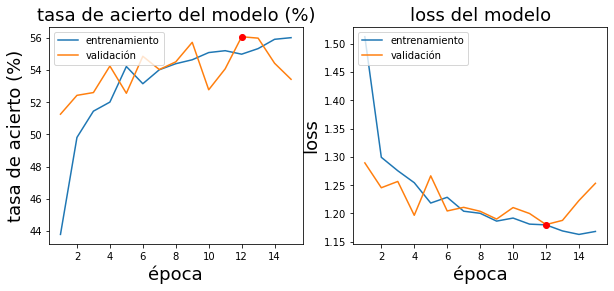

 67/109 [=================>............] - ETA: 1s - loss: 1.1593 - accuracy: 0.5655

KeyboardInterrupt: 

In [104]:
filepath='definitiva.h5'
checkpoint   = [EarlyStopping(monitor='val_loss', patience=30, mode='min', min_delta=0.0001),
                ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True, mode='min')]

acum_tr_acc = []
acum_val_acc = []
best_val_acc = -1000
acum_tr_loss  = []
acum_val_loss = []

epochs=50
batch_size=64


for e in range(epochs):
    history = model.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=1,
                        callbacks=checkpoint,
                        verbose=1,
                        validation_data=(X_val, y_val))

    if history.history['val_accuracy'][-1] > best_val_acc:
        print("Validation accuracy improved from",
              best_val_acc, 'to', history.history['val_accuracy'])
        print("saving weights")
        best_val_acc = history.history['val_accuracy'][-1]

    acum_tr_acc.append(history.history['accuracy'][0])
    acum_val_acc.append(history.history['val_accuracy'][0])
    acum_tr_loss.append(history.history['loss'][0])
    acum_val_loss.append(history.history['val_loss'][0])

    if len(acum_tr_acc) > 1:
        clear_output()
        best_i = np.argmax(acum_val_acc)
        grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

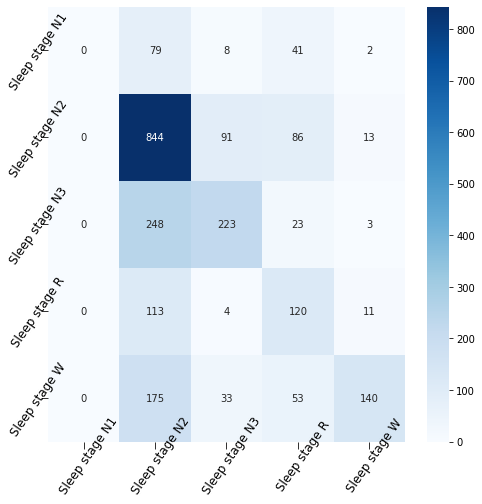

In [105]:
y_pred=np.argmax(model.predict(X_test),axis=1)

fig, ax = plt.subplots(figsize=(8,8))

cm=confusion_matrix(y_test,y_pred)
lista2=['Sleep stage N1','Sleep stage N2','Sleep stage N3','Sleep stage R','Sleep stage W']
sns.heatmap(pd.DataFrame(cm,index=['Sleep stage N1','Sleep stage N2','Sleep stage N3','Sleep stage R','Sleep stage W'],columns=['Sleep stage N1','Sleep stage N2','Sleep stage N3','Sleep stage R','Sleep stage W']),annot=True,fmt='d',cmap='Blues', ax=ax)

params = dict(rotation=55, ha='center', rotation_mode='anchor')
plt.setp(ax.get_yticklabels(), **params)
plt.setp(ax.get_xticklabels(), **params)
ax.tick_params(size=7)
ax.set_xticklabels(lista2,fontsize=12)
ax.set_yticklabels(lista2,fontsize=12);

In [112]:
np.transpose(X_juntados,axes=(2,0,1))[0].shape

(11550, 15360)

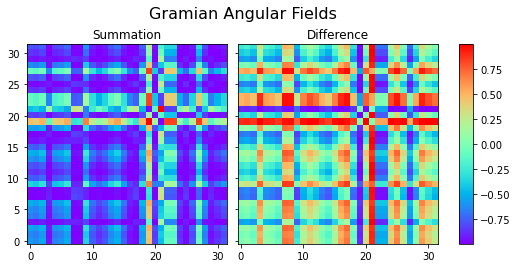

In [59]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from pyts.image import GramianAngularField
from pyts.datasets import load_gunpoint


# Transform the time series into Gramian Angular Fields
gasf = GramianAngularField(image_size=32, method='summation')
X_gasf = gasf.fit_transform(np.transpose(X_juntados,axes=(2,0,1))[0])
gadf = GramianAngularField(image_size=32, method='difference')
X_gadf = gadf.fit_transform(np.transpose(X_juntados,axes=(2,0,1))[0])

# Show the images for the first time series
fig = plt.figure(figsize=(8, 4))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(1, 2),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.3,
                 )
images = [X_gasf[0], X_gadf[0]]
titles = ['Summation', 'Difference']
for image, title, ax in zip(images, titles, grid):
    im = ax.imshow(image, cmap='rainbow', origin='lower')
    ax.set_title(title, fontdict={'fontsize': 12})
ax.cax.colorbar(im)
ax.cax.toggle_label(True)
plt.suptitle('Gramian Angular Fields', y=0.98, fontsize=16)
plt.show()

In [60]:
X_gadf2 = gadf.fit_transform(np.transpose(X_juntados,axes=(2,0,1))[1])
X_gadf3 = gadf.fit_transform(np.transpose(X_juntados,axes=(2,0,1))[2])

In [61]:
X_gadf_def=np.transpose(np.array([X_gadf,X_gadf2,X_gadf3]),axes=(1,2,3,0))

In [62]:
X_tr_trans=X_gadf_def[0:7500]
X_val_trans=X_gadf_def[7500:10000]
X_test_trans=X_gadf_def[10000:]

In [63]:
lab=LabelEncoder()
y_tr_trans=lab.fit_transform(y_todos[0:7500])
y_val_trans=lab.fit_transform(y_todos[7500:10000])
y_test_trans=lab.fit_transform(y_todos[10000:])

/home/pabloro/anaconda3/envs/tensorflow/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [69]:
from tensorflow.keras.applications.resnet50 import preprocess_input

X_tr_trans=preprocess_input(X_tr_trans)
X_val_trans=preprocess_input(X_val_trans)
X_test_trans=preprocess_input(X_test_trans)

In [74]:
from tensorflow.keras.applications import ResNet50, VGG16, ResNet50V2
from tensorflow.keras.layers import Input
from tensorflow.keras.regularizers import L1
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import AveragePooling1D,BatchNormalization, UpSampling1D,Input,Dense,LSTM,MaxPooling1D, Dropout,Conv1D, concatenate, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import tensorflow
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,auc
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"


model = Sequential()
model.add(ResNet50V2(include_top=False, input_shape=(32,32,3)))
model.add(Dense(5, activation = 'softmax'))
model.layers[0].trainable = False
model.compile('adam',loss='sparse_categorical_crossentropy',metrics='accuracy')
model.summary()

94674944/94668760 [==============================] - 8s 0us/step
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 1, 1, 2048)        23564800  
_________________________________________________________________
dense_5 (Dense)              (None, 1, 1, 5)           10245     
Total params: 23,575,045
Trainable params: 10,245
Non-trainable params: 23,564,800
_________________________________________________________________


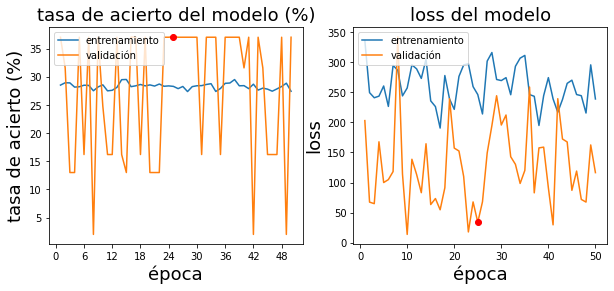

In [75]:
from matplotlib.ticker import MaxNLocator
from IPython.display import SVG, display, clear_output
import matplotlib.pyplot as plt

def grafica_entrenamiento(tr_acc, val_acc, tr_loss, val_loss, best_i,
                          figsize=(10,4)):
    plt.figure(figsize=figsize)
    ax = plt.subplot(1,2,1)
    plt.plot(1+np.arange(len(tr_acc)),  100*np.array(tr_acc))
    plt.plot(1+np.arange(len(val_acc)), 100*np.array(val_acc))
    plt.plot(1+best_i, 100*val_acc[best_i], 'or')
    plt.title('tasa de acierto del modelo (%)', fontsize=18)
    plt.ylabel('tasa de acierto (%)', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.subplot(1,2,2)
    plt.plot(1+np.arange(len(tr_acc)), np.array(tr_loss))
    plt.plot(1+np.arange(len(val_acc)), np.array(val_loss))
    plt.plot(1+best_i, val_loss[best_i], 'or')
    plt.title('loss del modelo', fontsize=18)
    plt.ylabel('loss', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

filepath='definitiva.h5'
checkpoint   = [EarlyStopping(monitor='val_loss', patience=30, mode='min', min_delta=0.0001),
                ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True, mode='min')]

acum_tr_acc = []
acum_val_acc = []
best_val_acc = -1000
acum_tr_loss  = []
acum_val_loss = []

epochs=50
batch_size=64


for e in range(epochs):
    history = model.fit(X_tr_trans, y_tr_trans,
                        batch_size=batch_size,
                        epochs=1,
                        callbacks=checkpoint,
                        verbose=1,
                        validation_data=(X_val_trans, y_val_trans))

    if history.history['val_accuracy'][-1] > best_val_acc:
        print("Validation accuracy improved from",
              best_val_acc, 'to', history.history['val_accuracy'])
        print("saving weights")
        best_val_acc = history.history['val_accuracy'][-1]

    acum_tr_acc.append(history.history['accuracy'][0])
    acum_val_acc.append(history.history['val_accuracy'][0])
    acum_tr_loss.append(history.history['loss'][0])
    acum_val_loss.append(history.history['val_loss'][0])

    if len(acum_tr_acc) > 1:
        clear_output()
        best_i = np.argmax(acum_val_acc)
        grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

In [ ]:
# from pyts.image import MarkovTransitionField
# from pyts.datasets import load_gunpoint

# # MTF transformation
# mtf = MarkovTransitionField(image_size=12)
# X_mtf = mtf.fit_transform(np.transpose(X_juntados,axes=(2,0,1))[0])

# # Show the image for the first time series
# plt.figure(figsize=(5, 5))
# plt.imshow(X_mtf[0], cmap='rainbow', origin='lower')
# plt.title('Markov Transition Field', fontsize=18)
# plt.colorbar(fraction=0.0457, pad=0.04)
# plt.tight_layout()
# plt.show()

In [40]:
# # Recurrence plot transformation
# import matplotlib.pyplot as plt
# from pyts.image import RecurrencePlot
# rp = RecurrencePlot(threshold='point', percentage=20)
# X_rp = rp.fit_transform(np.transpose(X_juntados,axes=(2,0,1))[0])

# # Show the results for the first time series
# plt.figure(figsize=(5, 5))
# plt.imshow(X_rp[0], cmap='binary', origin='lower')
# plt.title('Recurrence Plot', fontsize=16)
# plt.tight_layout()
# plt.show()